# Source data

Shelton, A.N., Seth, E.C., Mok, K.C. et al. Uneven distribution of cobamide biosynthesis and dependence in bacteria predicted by comparative genomics. ISME J 13, 789–804 (2019). https://doi.org/10.1038/s41396-018-0304-9

# Analyses

### Outline:
#### 1. Load necessary packages
#### 2. Import and merge necessary dataframes
    2.1 Import taxonomy dataframe and dataframe with updated taxonomy containing current names, and merge new and old names.\
    2.2 Import Amanda's supplementary table 5 which contains all the biosynthesis and dependence gene presence/absence data\
    2.3 Merge taxonomy and gene analysis data, cleanup.
#### 3. Group by corrinoid metabolism categories based on gene presence/absence
#### 4. Placing genomes into metabolism categories
    4.1 Biosynthesis subcategories\
    4.2 Independent\
    4.3 User\
    4.4 Corrinoid user with corrinoid independent gene alternatives\
    4.5 Dependent
#### 5. Dataframe cleanup (df2) before further analysis
#### 6. Group species by taxon -- phylum, class, order, family, genus
#### 7. Evaluating the percentages of species corresponding to each category by taxon group.
#### 8. Assigning predictions to genera with ≥ 20 species
#### 9. Heatmap generation
    9.1 Testing ecosystem analysis\
#### 10. Test Summary Figures\
    10.1 Phylum level summaries\
    10.2 Genus level test figures\
    10.3 Big-Phylum level figure for one of Michi's talks\
    10.4 Heatmap tests\
    10.5 Producer/User scatterplots that I showed at 2023 committee meeting\
    10.6 Some of Alekhya's plots


# 1. Load necessary packages

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
# %matplotlib inline

import seaborn as sns

import scipy as sp

# import statsmodels.formula.api as smf 

# 2. Import and merge necessary dataframes

Dataframes are from Shelton, 2019 [IsmeJ]

## 2.1 Import taxonomy dataframe and dataframe with updated taxonomy containing current names, and merge new and old names. 

Imported modified taxonomy table based on Amanda's paper.
Updated taxonomy: I did this by downloading the metadata for Amanda's genomes from IMG 230718 based on the IMG Genome IDs. These included the genome name, genome ID, and taxonomy info, which has been updated on IMG.

Note: 128 genomes from Amanda's dataset have been removed from IMG since she did her analysis. I will not be including those in further analyses. Hence, why I am doing an inner join below and the new dataframe is 11308 rows.

In [2]:
# import modified table containing taxonomic info prepared by 
# Zoila and Alekhya by combining Amanda's supplementary tables

cbataxon1 = pd.read_csv("cobamide_biosynthesis_by_taxonomy.csv")
cbataxon1

Unnamed: 0  IMG Genome ID                                 Genome Name  \
0               0     2562617177            Abiotrophia defectiva ATCC 49176   
1               1     2517572146            Acaricomes phytoseiuli DSM 14247   
2               2      641228474              Acaryochloris marina MBIC11017   
3               3     2513237397                 Acaryochloris sp CCMEE 5410   
4               4     2667527408  Acetanaerobacterium elongatum CGMCC 1.5012   
...           ...            ...                                         ...   
11431       11431      646564591                Zunongwangia profunda SM-A87   
11432       11432     2681812960               Zwartia alpina MWH-P2sevCIIIb   
11433       11433     2556921094                 Zymobacter palmae DSM 10491   
11434       11434     2558860209      Zymomonas mobilis mobilis NRRL B-12526   
11435       11435     2518645621        Zymophilus raffinosivorans DSM 20765   

       cobamide biosynthesis category          Phylum                Class  \
0            very likely non-producer      Firmicutes              Bacilli   
1            very likely non-producer  Actinobacteria       Actinobacteria   
2         possible corrinoid producer   Cyanobacteria         unclassified   
3         possible corrinoid producer   Cyanobacteria         unclassified   
4            very likely non-producer      Firmicutes           Clostridia   
...                               ...             ...                  ...   
11431        very likely non-producer   Bacteroidetes       Flavobacteriia   
11432        very likely non-producer  Proteobacteria   Betaproteobacteria   
11433     possible corrinoid producer  Proteobacteria  Gammaproteobacteria   
11434        very likely non-producer  Proteobacteria  Alphaproteobacteria   
11435  very likely corrinoid producer      Firmicutes        Negativicutes   

                   Order              Family                Genus  \
0        Lactobacillales       Aerococcaceae          Abiotrophia   
1          Micrococcales      Micrococcaceae           Acaricomes   
2        Synechococcales  Acaryochloridaceae        Acaryochloris   
3        Synechococcales  Acaryochloridaceae        Acaryochloris   
4          Clostridiales     Ruminococcaceae  Acetanaerobacterium   
...                  ...                 ...                  ...   
11431   Flavobacteriales   Flavobacteriaceae         Zunongwangia   
11432       unclassified        unclassified              Zwartia   
11433  Oceanospirillales      Halomonadaceae           Zymobacter   
11434   Sphingomonadales   Sphingomonadaceae            Zymomonas   
11435    Selenomonadales    Selenomonadaceae           Zymophilus   

                             Species Ecosystem Category  
0              Abiotrophia defectiva              Human  
1             Acaricomes phytoseiuli       Unclassified  
2               Acaryochloris marina             Animal  
3       Acaryochloris sp. CCMEE 5410            Aquatic  
4      Acetanaerobacterium elongatum                NaN  
...                              ...                ...  
11431          Zunongwangia profunda            Aquatic  
11432                 Zwartia alpina            Aquatic  
11433              Zymobacter palmae             Plants  
11434              Zymomonas mobilis                NaN  
11435     Zymophilus raffinosivorans     Lab enrichment  

[11436 rows x 11 columns]

In [3]:
updated_taxonomy = pd.read_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/updated_taxonomy/updated_taxonomy.csv')
cbataxon = cbataxon1.merge(updated_taxonomy, on = 'IMG Genome ID', how = 'inner')

In [4]:
# Renaming taxonomy columns so that my life is easier. 

cbataxon.rename(columns = {'Phylum':'Phylum_old',
                          'Class':'Class_old',
                          'Order':'Order_old',
                          'Family':'Family_old',
                          'Genus':'Genus_old',
                          'Species':'Species_old',
                          'Phylum_new':'Phylum',
                          'Class_new':'Class',
                          'Order_new':'Order',
                          'Family_new':'Family',
                          'Genus_new':'Genus',
                          'Species_new':'Species'},
               inplace=True)

In [ ]:
# Export to include as supplement
# cbataxon.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/supplement1_Amanda_genome_updated_taxonomy.csv')

In [5]:
cbataxon

Unnamed: 0  IMG Genome ID                                 Genome Name  \
0               0     2562617177            Abiotrophia defectiva ATCC 49176   
1               1     2517572146            Acaricomes phytoseiuli DSM 14247   
2               2      641228474              Acaryochloris marina MBIC11017   
3               3     2513237397                 Acaryochloris sp CCMEE 5410   
4               4     2667527408  Acetanaerobacterium elongatum CGMCC 1.5012   
...           ...            ...                                         ...   
11303       11431      646564591                Zunongwangia profunda SM-A87   
11304       11432     2681812960               Zwartia alpina MWH-P2sevCIIIb   
11305       11433     2556921094                 Zymobacter palmae DSM 10491   
11306       11434     2558860209      Zymomonas mobilis mobilis NRRL B-12526   
11307       11435     2518645621        Zymophilus raffinosivorans DSM 20765   

       cobamide biosynthesis category      Phylum_old            Class_old  \
0            very likely non-producer      Firmicutes              Bacilli   
1            very likely non-producer  Actinobacteria       Actinobacteria   
2         possible corrinoid producer   Cyanobacteria         unclassified   
3         possible corrinoid producer   Cyanobacteria         unclassified   
4            very likely non-producer      Firmicutes           Clostridia   
...                               ...             ...                  ...   
11303        very likely non-producer   Bacteroidetes       Flavobacteriia   
11304        very likely non-producer  Proteobacteria   Betaproteobacteria   
11305     possible corrinoid producer  Proteobacteria  Gammaproteobacteria   
11306        very likely non-producer  Proteobacteria  Alphaproteobacteria   
11307  very likely corrinoid producer      Firmicutes        Negativicutes   

               Order_old          Family_old            Genus_old  \
0        Lactobacillales       Aerococcaceae          Abiotrophia   
1          Micrococcales      Micrococcaceae           Acaricomes   
2        Synechococcales  Acaryochloridaceae        Acaryochloris   
3        Synechococcales  Acaryochloridaceae        Acaryochloris   
4          Clostridiales     Ruminococcaceae  Acetanaerobacterium   
...                  ...                 ...                  ...   
11303   Flavobacteriales   Flavobacteriaceae         Zunongwangia   
11304       unclassified        unclassified              Zwartia   
11305  Oceanospirillales      Halomonadaceae           Zymobacter   
11306   Sphingomonadales   Sphingomonadaceae            Zymomonas   
11307    Selenomonadales    Selenomonadaceae           Zymophilus   

                         Species_old Ecosystem Category  \
0              Abiotrophia defectiva              Human   
1             Acaricomes phytoseiuli       Unclassified   
2               Acaryochloris marina             Animal   
3       Acaryochloris sp. CCMEE 5410            Aquatic   
4      Acetanaerobacterium elongatum                NaN   
...                              ...                ...   
11303          Zunongwangia profunda            Aquatic   
11304                 Zwartia alpina            Aquatic   
11305              Zymobacter palmae             Plants   
11306              Zymomonas mobilis                NaN   
11307     Zymophilus raffinosivorans     Lab enrichment   

                        Genome Name / Sample Name           Phylum  \
0                Abiotrophia defectiva ATCC 49176        Bacillota   
1           Acaricomes phytoseiuli DSM 14247 test   Actinomycetota   
2                  Acaryochloris marina MBIC11017  Cyanobacteriota   
3                     Acaryochloris sp CCMEE 5410  Cyanobacteriota   
4      Acetanaerobacterium elongatum CGMCC 1.5012        Bacillota   
...                                           ...              ...   
11303                Zunongwangia profunda SM-A87     Bacteroidota   
11304      

## 2.2 Import Amanda's supplementary table 5 which contains all the biosynthesis and dependence gene presence/absence data

In [ ]:
# I don't think this does anything (ecosystem category still there)
# cbataxon.dropna(how="all")
# len(cbataxon)

In [6]:
# import supplementary table 5 from the paper (this is the main dataframe that we'll be manipulating)
# supp5 has all the dependence and biosynthesis genes presence/absence data
supp5 = pd.read_excel("41396_2018_304_MOESM6_ESM_Supp5.xlsx")
supp5

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


IMG Genome ID                                 Genome Name  \
0         2562617177            Abiotrophia defectiva ATCC 49176   
1         2517572146            Acaricomes phytoseiuli DSM 14247   
2          641228474              Acaryochloris marina MBIC11017   
3         2513237397                 Acaryochloris sp CCMEE 5410   
4         2667527408  Acetanaerobacterium elongatum CGMCC 1.5012   
...              ...                                         ...   
11431      646564591                Zunongwangia profunda SM-A87   
11432     2681812960               Zwartia alpina MWH-P2sevCIIIb   
11433     2556921094                 Zymobacter palmae DSM 10491   
11434     2558860209      Zymomonas mobilis mobilis NRRL B-12526   
11435     2518645621        Zymophilus raffinosivorans DSM 20765   

       B12-dependent RNR  B12-independent RNR   metH   metE  \
0                  False                 True  False   True   
1                  False                 True  False   True   
2                   True                 True   True   True   
3                   True                False   True  False   
4                  False                 True   True  False   
...                  ...                  ...    ...    ...   
11431               True                False   True  False   
11432              False                 True   True   True   
11433              False                 True  False   True   
11434              False                 True   True   True   
11435              False                 True   True  False   

       methylmalonyl-CoA mutase family  methylcitrate pathway  \
0                                False                  False   
1                                False                   True   
2                                False                  False   
3                                False                  False   
4                                False                  False   
...                                ...                    ...   
11431                             True                  False   
11432                            False                   True   
11433                            False                  False   
11434                            False                  False   
11435                             True                  False   

       glutamate mutase  ethanolamine ammonia lyase  \
0                 False                       False   
1                 False                       False   
2                 False                       False   
3                 False                       False   
4                 False                       False   
...                 ...                         ...   
11431             False                        True   
11432             False                        True   
11433             False                       False   
11434             False                       False   
11435             False                        True   

       B12-independent ethanolamine pathway  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   
...                                     ...   
11431                                 False   
11432                                 False   
11433                                 False   
11434                                 False   
11435                                 False   

       B12-dependent glycerol/diol dehydratase  \
0                                        False   
1                                        False   
2                                        False   
3                                        False   
4                                        False   
...                                        ...   
11431                                    False   
11432                     

In [7]:
# convert IMG Genome ID to string so that we can merge on this later

supp5["IMG Genome ID"] = supp5["IMG Genome ID"].astype(str)
cbataxon["IMG Genome ID"] = cbataxon["IMG Genome ID"].astype(str)

## 2.3 Merge taxonomy and gene analysis data, cleanup.
Clean up the table a little bit - drop unclassified genomes, drop repeat columns, rename columns, etc
after grouping and sorting, will do another round of "cleanup"/ Note I did not remove Candidatus genomes.

In [8]:
df1 = pd.merge(cbataxon, supp5, on="IMG Genome ID")
df1

# resulting merged df has taxonomic info for all genomes, which will be useful for sorting/grouping later

Unnamed: 0 IMG Genome ID                               Genome Name_x  \
0               0    2562617177            Abiotrophia defectiva ATCC 49176   
1               1    2517572146            Acaricomes phytoseiuli DSM 14247   
2               2     641228474              Acaryochloris marina MBIC11017   
3               3    2513237397                 Acaryochloris sp CCMEE 5410   
4               4    2667527408  Acetanaerobacterium elongatum CGMCC 1.5012   
...           ...           ...                                         ...   
11303       11431     646564591                Zunongwangia profunda SM-A87   
11304       11432    2681812960               Zwartia alpina MWH-P2sevCIIIb   
11305       11433    2556921094                 Zymobacter palmae DSM 10491   
11306       11434    2558860209      Zymomonas mobilis mobilis NRRL B-12526   
11307       11435    2518645621        Zymophilus raffinosivorans DSM 20765   

      cobamide biosynthesis category_x      Phylum_old            Class_old  \
0             very likely non-producer      Firmicutes              Bacilli   
1             very likely non-producer  Actinobacteria       Actinobacteria   
2          possible corrinoid producer   Cyanobacteria         unclassified   
3          possible corrinoid producer   Cyanobacteria         unclassified   
4             very likely non-producer      Firmicutes           Clostridia   
...                                ...             ...                  ...   
11303         very likely non-producer   Bacteroidetes       Flavobacteriia   
11304         very likely non-producer  Proteobacteria   Betaproteobacteria   
11305      possible corrinoid producer  Proteobacteria  Gammaproteobacteria   
11306         very likely non-producer  Proteobacteria  Alphaproteobacteria   
11307   very likely corrinoid producer      Firmicutes        Negativicutes   

               Order_old          Family_old            Genus_old  \
0        Lactobacillales       Aerococcaceae          Abiotrophia   
1          Micrococcales      Micrococcaceae           Acaricomes   
2        Synechococcales  Acaryochloridaceae        Acaryochloris   
3        Synechococcales  Acaryochloridaceae        Acaryochloris   
4          Clostridiales     Ruminococcaceae  Acetanaerobacterium   
...                  ...                 ...                  ...   
11303   Flavobacteriales   Flavobacteriaceae         Zunongwangia   
11304       unclassified        unclassified              Zwartia   
11305  Oceanospirillales      Halomonadaceae           Zymobacter   
11306   Sphingomonadales   Sphingomonadaceae            Zymomonas   
11307    Selenomonadales    Selenomonadaceae           Zymophilus   

                         Species_old Ecosystem Category  \
0              Abiotrophia defectiva              Human   
1             Acaricomes phytoseiuli       Unclassified   
2               Acaryochloris marina             Animal   
3       Acaryochloris sp. CCMEE 5410            Aquatic   
4      Acetanaerobacterium elongatum                NaN   
...                              ...                ...   
11303          Zunongwangia profunda            Aquatic   
11304                 Zwartia alpina            Aquatic   
11305              Zymobacter palmae             Plants   
11306              Zymomonas mobilis                NaN   
11307     Zymophilus raffinosivorans     Lab enrichment   

                        Genome Name / Sample Name           Phylum  \
0                Abiotrophia defectiva ATCC 49176        Bacillota   
1           Acaricomes phytoseiuli DSM 14247 test   Actinomycetota   
2                  Acaryochloris marina MBIC11017  Cyanobacteriota   
3                     Acaryochloris sp CCMEE 5410  Cyanobacteriota   
4      Acetanaerobacterium elongatum CGMCC 1.5012        Bacillota   
...                                           ...              ...   
11303                Zunongwangia profunda SM-A87     Bacteroidota   
11304      

In [ ]:
# clean up the table a little bit - drop candidate/unclassified genomes, drop repeat columns, rename columns, etc
# after grouping and sorting, will do another round of "cleanup"

In [9]:
df1.columns

Index(['Unnamed: 0', 'IMG Genome ID', 'Genome Name_x',
       'cobamide biosynthesis category_x', 'Phylum_old', 'Class_old',
       'Order_old', 'Family_old', 'Genus_old', 'Species_old',
       'Ecosystem Category', 'Genome Name / Sample Name', 'Phylum', 'Class',
       'Order', 'Family', 'Genus', 'Species', 'Genome Name_y',
       'B12-dependent RNR', 'B12-independent RNR', 'metH', 'metE',
       'methylmalonyl-CoA mutase family', 'methylcitrate pathway',
       'glutamate mutase', 'ethanolamine ammonia lyase',
       'B12-independent ethanolamine pathway',
       'B12-dependent glycerol/diol dehydratase',
       'B12-independent glycerol/diol dehydratase',
       'beta-lysine 5,6-aminomutase', 'D-ornithine 4,5-aminomutase',
       'epoxyqueuosine reductase', 'reductive dehalogenase',
       'Wood-Ljungdahl corrinoid protein',
       'corrinoid methyltransferase families', 'bacteriochlorophyll cyclase',
       'mercury methylation', 'B12 pfam binding domains', 'rSAM-B12 proteins',
   

In [10]:
# remove duplicated columns and rename
df1.drop(['Unnamed: 0', 'Genome Name_y', 'cobamide biosynthesis category_y'], axis=1, inplace=True)
df1.rename({'cobamide biosynthesis category_x' : 'cobamide biosynthesis category'}, axis=1, inplace=True)
df1.rename({'Genome Name_x':'GenomeName'}, axis = 1, inplace=True)

In [12]:
# create a copy of df for when we want to go back to it later

df2 = df1.copy()
# df2

# 3. Group by corrinoid metabolism categories based on gene presence/absence

The df that we created (and the original supplementary table 5) indicates whether or not a genome contains genes involved in each step of cobamide biosynthesis and genes involved in different cobamide-dependent metabolisms...which is a lot (>70 genes)

To simplify this and make the analysis easier to understand, I am going to categorize the cobamide biosynthesis genes (fig 2 in Shelton 2019) and dependent genes (fig 1 in Shelton 2019) into broad categories. 

For cobamide biosynthesis (see supp7 data table in Shelton 2019 for list of genes per category)
- aerobic cba biosynthesis
- anaerobic cba biosynthesis
- tetrapyrrole precursor biosynthesis 
- corrin ring biosynthesis
- nucleotide loop assembly
- core biosynthesis

For cobamide-dependent metabolisms:
- carbon and nitrogen metabolism --> glycerol/diol dehydratase, MCM, ethanolamine lyase, D-ornithine 45 aminomutase, beta lysine 56 aminomutase
- one carbon metabolism --> Wood-Ljungdahl corrinoid proteins, corrinoid methyltransferase families
- natural product synthesis --> rSAM B12 proteins
- bacteriochlorophyll synthesis
- methionine synthesis
- mercury methylation
- nucleotide metabolism --> B12-dep RNR, epoxyqueosine reductase
- reductive dehalogenase


In [13]:
# retrieve index and label for each column to facilitate grouping by cba-dep metabolism

df2.columns

Index(['IMG Genome ID', 'GenomeName', 'cobamide biosynthesis category',
       'Phylum_old', 'Class_old', 'Order_old', 'Family_old', 'Genus_old',
       'Species_old', 'Ecosystem Category', 'Genome Name / Sample Name',
       'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species',
       'B12-dependent RNR', 'B12-independent RNR', 'metH', 'metE',
       'methylmalonyl-CoA mutase family', 'methylcitrate pathway',
       'glutamate mutase', 'ethanolamine ammonia lyase',
       'B12-independent ethanolamine pathway',
       'B12-dependent glycerol/diol dehydratase',
       'B12-independent glycerol/diol dehydratase',
       'beta-lysine 5,6-aminomutase', 'D-ornithine 4,5-aminomutase',
       'epoxyqueuosine reductase', 'reductive dehalogenase',
       'Wood-Ljungdahl corrinoid protein',
       'corrinoid methyltransferase families', 'bacteriochlorophyll cyclase',
       'mercury methylation', 'B12 pfam binding domains', 'rSAM-B12 proteins',
       'aerobic cobamide biosynthesis (max=23)

In [14]:
# create a dictionary to store all gene names (per their column label and index) for each cba-dependent metabolic group

cba_dep_metab_label = {
    'carbon_nitrogen_metabolism':['methylmalonyl-CoA mutase family', 'glutamate mutase',
                                  'ethanolamine ammonia lyase', 'B12-dependent glycerol/diol dehydratase', 
                                  'beta-lysine 5,6-aminomutase', 'D-ornithine 4,5-aminomutase'],
    'one_carbon_metabolism':['Wood-Ljungdahl corrinoid protein','corrinoid methyltransferase families'],
    'natural_product_synthesis':'rSAM-B12 proteins',
    'bacteriochlorophyll_synthesis':'bacteriochlorophyll cyclase',
    'methionine_synthesis':'metH',
    'mercury_methylation':'mercury methylation',
    'nucleotide_metabolism':['B12-dependent RNR','epoxyqueuosine reductase'],
    'reductive_dehalogenation':'reductive dehalogenase',
    'corrinoid_binding_domain':'B12 pfam binding domains', 
    'all' : ['methylmalonyl-CoA mutase family', 'glutamate mutase','ethanolamine ammonia lyase',
             'B12-dependent glycerol/diol dehydratase','beta-lysine 5,6-aminomutase', 
             'D-ornithine 4,5-aminomutase','Wood-Ljungdahl corrinoid protein',
             'corrinoid methyltransferase families','rSAM-B12 proteins',
             'bacteriochlorophyll cyclase', 'metH', 'mercury methylation', 
             'B12-dependent RNR','epoxyqueuosine reductase', 
             'reductive dehalogenase','B12 pfam binding domains']
                }

cba_dep_metab_index = {
    'carbon_nitrogen_metabolism': [14, 16, 17, 19, 21, 22],
    'one_carbon_metabolism': [25, 26],
    'natural_product_synthesis': 30,
    'bacteriochlorophyll_synthesis': 27,
    'methionine synthesis': 12,
    'mercury_methylation': 28,
    'nucleotide_metabolism': [10, 23],
    'reductive_dehalogenation': 24,
    'corrinoid_binding_domain': 29
                    }

In [15]:
# Doing the same as above for cba independent enzymes

cba_indep_metab_label = {
    'carbon_nitrogen_metabolism':['methylcitrate pathway', 'B12-independent ethanolamine pathway',
                                  'B12-independent glycerol/diol dehydratase'],
    'nucleotide_metabolism':'B12-independent RNR',
    'methionine_synthesis':'metE',
    'all':['methylcitrate pathway', 'B12-independent ethanolamine pathway',
           'B12-independent glycerol/diol dehydratase','B12-independent RNR','metE']
}

cba_indep_metab_index = {
    'carbon_nitrogen_metabolism':[15,18,20],
    'nucleotide_metabolism':11,
    'methionine_synthesis':13
}

In [16]:
# create a dictionary to store all gene names/numbers for cba biosynthesis
# 'EC:1.14.13.54' should be 1.14.13.83; fixed after asking Amanda
# check if 2.1.1.131 and 2.1.1.131.1 are the same column
cba_biosyn = {
    'aerobic_biosynthesis' : ['ALA synthesis','EC:4.2.1.24','EC:2.5.1.61','EC:4.2.1.75','EC:2.1.1.107',
                              'EC:2.1.1.130','EC:1.14.13.83','EC:2.1.1.131','EC:2.1.1.133','EC:2.1.1.152',
                              'EC:1.3.1.54','EC:2.1.1.132','EC:5.4.99.61','EC:6.3.5.9','EC:6.6.1.2',
                              'EC:2.5.1.17','EC:6.3.5.10','EC:6.3.1.10','EC:2.7.1.156','cobinamide activation',
                              'EC:2.7.8.26','cbl phosphatase'],
    'anaerobic_biosynthesis' : ['ALA synthesis','EC:4.2.1.24','EC:2.5.1.61','EC:4.2.1.75','EC:2.1.1.107',
                                'EC:1.3.1.76','EC:4.99.1.3','EC:2.1.1.151','EC:2.1.1.131','EC:2.1.1.271',
                                'EC:3.7.1.12','EC:2.1.1.195','EC:1.3.1.106','EC:2.1.1.196','EC:2.1.1.289',
                                'EC:5.4.99.60','EC:6.3.5.11','EC:2.5.1.17','EC:6.3.5.10','EC:6.3.1.10',
                                'EC:2.7.1.156','cobinamide activation','EC:2.7.8.26','cbl phosphatase'],
    'tetrapyrrole_precursor_biosynthesis' : ['ALA synthesis','EC:4.2.1.24','EC:2.5.1.61','EC:4.2.1.75',
                                             'EC:2.1.1.107'],
    'corrin_ring_biosynthesis' : ['EC:2.1.1.130','EC:2.1.1.151','EC:2.1.1.131','EC:1.14.13.83','EC:2.1.1.133',
                                  'EC:2.1.1.271','EC:2.1.1.152','EC:3.7.1.12','EC:2.1.1.195','EC:1.3.1.106',
                                  'EC:1.3.1.54','EC:2.1.1.132','EC:2.1.1.289','EC:2.1.1.196','EC:5.4.99.61',
                                  'EC:5.4.99.60','EC:6.3.5.9','EC:6.3.5.11','EC:6.6.1.2','EC:4.99.1.3'],
    'aminopropanol_linker' : ['EC:2.7.1.177', 'EC:4.1.1.81'],
    'adenosylation' : 'EC:2.5.1.17',
    'nucleotide_loop_assembly' : ['EC:6.3.5.10', 'EC:6.3.1.10', 'EC:2.7.1.156', 'cobinamide activation',
                                  'cbl phosphatase', 'EC:2.7.8.26'],
    'core_biosynthesis' : ['EC:2.1.1.130', 'EC:2.1.1.151', 'EC:2.1.1.133','EC:2.1.1.271','EC:5.4.99.61',
                           'EC:5.4.99.60','EC:6.3.5.10','EC:6.3.1.10','EC:2.7.1.156','cobinamide activation',
                           'EC:2.7.8.26' ],
    'corrinoid_remodeling' : 'CbiZ',
    'all' : ['CbiZ',
             'ALA synthesis',
             'EC:4.2.1.24', 
             'EC:2.5.1.61', 
             'EC:4.2.1.75',
             'EC:2.1.1.107', 
             'EC:2.1.1.130', 
             'EC:1.14.13.83',
             'EC:2.1.1.131',
             'EC:2.1.1.133', 
             'EC:2.1.1.152', 
             'EC:1.3.1.54',
             'EC:2.1.1.132',
             'EC:5.4.99.61',
             'EC:6.3.5.9',
             'EC:6.6.1.2',
             'EC:1.3.1.76',
             'EC:4.99.1.3',
             'EC:2.1.1.151', 
             'EC:2.1.1.131.1',
             'EC:2.1.1.271',
             'EC:3.7.1.12',
             'EC:2.1.1.195',
             'EC:1.3.1.106',
             'EC:2.1.1.196',
             'EC:2.1.1.289',
             'EC:5.4.99.60',
             'EC:6.3.5.11',
             'EC:2.5.1.17',
             'EC:6.3.5.10',
             'EC:6.3.1.10', 
             'EC:2.7.1.156',
             'cobinamide activation',
             'EC:2.4.2.21',
             'cbl phosphatase',
             'EC:2.7.8.26', 
             'EC:2.7.1.177',
             'EC:4.1.1.81']
                    }


In [17]:
# create a new column that counts presence/absence of genes involved in each cba-dependent metabolism

# any cba dep metabolism

df2['cba dependent metabolism genes'] = False

for row in df2.index:
    for column in cba_dep_metab_label['all']:
        if df2.loc[row, column] == True:
            df2.loc[row, "cba dependent metabolism genes"] = True

            
# carbon and nitrogen metabolism

df2['carbon nitrogen metabolism genes'] = False

for row in df2.index:
    for column in cba_dep_metab_label['carbon_nitrogen_metabolism']:
        if df2.loc[row, column] == True:
            df2.loc[row, "carbon nitrogen metabolism genes"] = True

            
# one carbon metabolism

df2['one carbon metabolism genes'] = False

for row in df2.index:
    for column in cba_dep_metab_label['one_carbon_metabolism']:
        if df2.loc[row, column] == True:
            df2.loc[row, "one carbon metabolism genes"] = True

            
# natural product synthesis

df2['natl product synthesis genes'] = False

for row in df2.index:
    if df2.loc[df2.index[row], cba_dep_metab_label['natural_product_synthesis']] >= 1:
        df2.loc[df2.index[row], 'natl product synthesis genes'] = True

        
# bacteriochlorophyll synthesis

df2['bacteriochlorophyll synthesis genes'] = False

for row in df2.index:
    if df2.loc[df2.index[row], cba_dep_metab_label['bacteriochlorophyll_synthesis']] == True:
        df2.loc[df2.index[row], 'bacteriochlorophyll synthesis genes'] = True

        
# methionine synthesis

df2['methionine synthesis genes'] = False

for row in df2.index:
    if df2.loc[df2.index[row], cba_dep_metab_label['methionine_synthesis']] == True:
        df2.loc[df2.index[row], 'methionine synthesis genes'] = True

        
# mercury methylation

df2['mercury methylation genes'] = False

for row in df2.index:
    if df2.loc[df2.index[row], cba_dep_metab_label['methionine_synthesis']] == True:
        df2.loc[df2.index[row], 'mercury methylation genes'] = True
        

# nucleotide metabolism

df2['nucleotide metabolism genes'] = False

for row in df2.index:
    for column in cba_dep_metab_label['nucleotide_metabolism']:
        if df2.loc[row, column] == True:
            df2.loc[row, "nucleotide metabolism genes"] = True
                   

# reductive dehalogenation

df2['reductive dehalogenation genes'] = False

for row in df2.index:
    if df2.loc[df2.index[row], cba_dep_metab_label['reductive_dehalogenation']] == True:
        df2.loc[row, 'reductive dehalogenation genes'] = True


In [18]:
# create a new column that counts presence/absence of genes in corrinoid independent alternative pathways

# any cba independent metabolism gene
df2['cba independent alternative genes'] = False

for row in df2.index:
    for column in cba_indep_metab_label['all']:
        if df2.loc[row, column] == True:
            df2.loc[row, "cba independent alternative genes"] = True

# CN metabolism cba independent genes
df2['independent carbon nitrogen metabolism genes'] = False

for row in df2.index:
    for column in cba_indep_metab_label['carbon_nitrogen_metabolism']:
        if df2.loc[row, column] == True:
            df2.loc[row, 'independent carbon nitrogen metabolism genes'] = True
            
# nucleotide metabolism cba independent genes
df2['independent nucleotide metabolism'] = False

for row in df2.index:
    if df2.loc[df2.index[row], cba_indep_metab_label['nucleotide_metabolism']] == True:
        df2.loc[row, 'independent nucleotide metabolism'] = True        
        
# methionine syntase cba independent genes
df2['independent methionine synthesis'] = False

for row in df2.index:
    if df2.loc[df2.index[row], cba_indep_metab_label['methionine_synthesis']] == True:
        df2.loc[row, 'independent methionine synthesis'] = True   


In [19]:
# create a new column that counts presence of genes involved in each cba biosynthesis sub-pathway

# any cba biosynthesis genes

df2['cba biosynthesis genes'] = False

for row in df2.index:
    for column in cba_biosyn['all']:
        if df2.loc[row, column] == True:
            df2.loc[row, 'cba biosynthesis genes'] = True

# aerobic cba biosynthesis

df2['aerobic biosynthesis genes'] = False

for row in df2.index:
    for column in cba_biosyn['aerobic_biosynthesis']:
        if df2.loc[row, column] == True:
            df2.loc[row, "aerobic biosynthesis genes"] = True

# anaerobic cba biosynthesis

df2['anaerobic biosynthesis genes'] = False

for row in df2.index:
    for column in cba_biosyn['anaerobic_biosynthesis']:
        if df2.loc[row, column] == True:
            df2.loc[row, 'anaerobic biosynthesis genes'] = True
            

# tetrapyrrole precursor biosynthesis

df2['tetrapyrrole precursor biosynthesis genes'] = False

for row in df2.index:
    for column in cba_biosyn['tetrapyrrole_precursor_biosynthesis']:
        if df2.loc[row, column] == True:
            df2.loc[row, 'tetrapyrrole precursor biosynthesis genes'] = True


# corrin ring biosynthesis

df2['corrin ring biosynthesis genes'] = False

for row in df2.index:
    for column in cba_biosyn['corrin_ring_biosynthesis']:
        if df2.loc[row, column] == True:
            df2.loc[row, 'corrin ring biosynthesis genes'] = True


# aminopropanol linker

df2['aminopropanol linker genes'] = False

for row in df2.index:
    for column in cba_biosyn['aminopropanol_linker']:
        if df2.loc[row, column] == True:
            df2.loc[row, 'aminopropanol linker genes'] = True
            

# adenosylation 

df2['adenosylation genes'] = False

for row in df2.index:
    if df2.loc[df2.index[row], cba_biosyn['adenosylation']] == True:
        df2.loc[row, 'adenosylation genes'] = True
        


# nucleotide loop assembly

df2['nucleotide loop assembly genes'] = False

for row in df2.index:
    for column in cba_biosyn['nucleotide_loop_assembly']:
        if df2.loc[row, column] == True:
            df2.loc[row, 'nucleotide loop assembly genes'] = True


# core biosynthesis genes

df2['core biosynthesis genes'] = False

for row in df2.index:
    for column in cba_biosyn['core_biosynthesis']:
        if df2.loc[row, column] == True:
            df2.loc[row, 'core biosynthesis genes'] = True 

            
# corrinoid remodeling 

df2['corrinoid remodeling gene'] = False

for row in df2.index:
    if df2.loc[df2.index[row], cba_biosyn['corrinoid_remodeling']] == True:
        df2.loc[df2.index[row], 'corrinoid remodeling gene'] = True

In [ ]:
df2
# BEFORE SAVING, UPDATE DATE

# df2.to_csv('genomes_annotated_for_corrinoid_function_230718.csv')

# 4. Categorizing genomes

Based on the presence or absence of cba biosynthesis genes and cba-dependent metabolism genes, each genome was classified into 7 cobamide biosynthesis categories in Amanda's paper.

cobamide biosynthesis categories:
- tetrapyrrole precursor salvager
- Cbi salvager
- possible / likely / very likely corrinoid producer
- likely / very likely non-producer (this includes those with cba-dep metabolisms aka cba users)

For this analysis, I will categorize as follows:
biosynthesis:
- producer (includes possible / likely / very likely corrinoid producer)
- not producer (includes likely / very likely non-producer)
- corrinoid precursor salvager (includes cbi and tetrapyrrole salvagers)
- cbi salvager
- tetrapyrrole precursor salvager

use:
- user (at least one dependent gene)
- not user (no dependent genes)
- conditional user (has independent alternative enzyme and no solely dependent enzymes)

dependent:
- user not producer

independent:
- not user not producer

## 4.1 Biosynthesis subcategories

In [23]:
# create new columns for each cba biosynthesis category/classifier

# tetrapyrrole precursor salvager
df2['tetrapyrrole precursor salvager'] = False
for row in df2.index:
    if df2.loc[df2.index[row], 'cobamide biosynthesis category'] =='tetrapyrrole precursor salvager':
        df2.loc[df2.index[row], 'tetrapyrrole precursor salvager'] = True
        
tet_salv_ct= list(df2['tetrapyrrole precursor salvager'])
print(tet_salv_ct.count(True))


# Cbi salvager
df2['Cbi salvager'] = False

for row in df2.index:
    if df2.loc[df2.index[row], 'cobamide biosynthesis category'] == 'Cbi salvager':
        df2.loc[df2.index[row], 'Cbi salvager'] = True

cbi_salv_ct = list(df2['Cbi salvager'])
print(cbi_salv_ct.count(True))

# Precursor salvager (Cbi + Tetrapyrrole)
df2['corrinoid precursor salvager'] = False
for row in df2.index:
    if df2.loc[df2.index[row], 'cobamide biosynthesis category'] == 'Cbi salvager' or df2.loc[df2.index[row], 'cobamide biosynthesis category'] == 'tetrapyrrole precursor salvager':
        df2.loc[df2.index[row], 'corrinoid precursor salvager'] = True

prec_salv_ct = list(df2['corrinoid precursor salvager'])
print(prec_salv_ct.count(True))  


201
1720
1921


In [21]:
201+1720
# cbi + tet = total

1921

In [22]:
# corrinoid producer

df2['corrinoid producer'] = False

for row in df2.index:
    if df2.loc[df2.index[row], 'cobamide biosynthesis category'] == 'possible corrinoid producer':
        df2.loc[df2.index[row], 'corrinoid producer'] = True
    elif df2.loc[df2.index[row], 'cobamide biosynthesis category'] == 'likely corrinoid producer':
        df2.loc[df2.index[row], 'corrinoid producer'] = True
    elif df2.loc[df2.index[row],'cobamide biosynthesis category'] == 'very likely corrinoid producer':
        df2.loc[df2.index[row], 'corrinoid producer'] = True

prod_ct = list(df2['corrinoid producer'])
prod_ct.count(True)

4135

In [24]:
# corrinoid non-producer

df2['corrinoid non-producer'] = False

for row in df2.index:
    if df2.loc[df2.index[row], 'cobamide biosynthesis category'] == 'likely non-producer':
        df2.loc[df2.index[row], 'corrinoid non-producer'] = True

    elif df2.loc[df2.index[row], 'cobamide biosynthesis category'] == 'very likely non-producer':
        df2.loc[df2.index[row], 'corrinoid non-producer'] = True
        
        
nonp_ct = list(df2['corrinoid non-producer'])
nonp_ct.count(True)

5252

In [27]:
4135 + 5252  + 1720 + 201

# each biosynthesis category = total number of genomes

11308

In [28]:
df2.shape

(11308, 113)

## 4.2 Independent

In [29]:
# no corrinoid interaction

df2['corrinoid independent'] = False
    
for row in df2.index:
    if ((df2.loc[row, 'cba dependent metabolism genes'] == False) and (df2.loc[row, 'corrinoid producer'] == False)):
        df2.loc[row, 'corrinoid independent'] = True

ind_ct = list(df2['corrinoid independent'])
ind_ct.count(True)

1563

In [ ]:
# print(df2.columns.tolist())

## 4.3 User

In [30]:
# if a genome has no corrinoid dependent genes: non user

df2['not corrinoid user'] = False
df2['corrinoid user'] = False

for row in df2.index:
        if df2.loc[row, 'cba dependent metabolism genes'] == False:
            df2.loc[row, "not corrinoid user"] = True

notu_ct = list(df2['not corrinoid user'])
print(notu_ct.count(True))

for row in df2.index:
        if df2.loc[row, 'cba dependent metabolism genes'] == True:
            df2.loc[row, "corrinoid user"] = True

user_ct = list(df2['corrinoid user'])
print(user_ct.count(True))

1563
9745


In [31]:
# not user + user = no. of genomes
1563 + 9745

11308

## 4.4 Corrinoid user with corrinoid independent gene alternatives

corrinoid dependent genes with no known alternative independent genes at the moment:
- glutamate mutase
- beta-lysine 5,6-aminomutase
- D-ornithine 4,5-aminomutase
- Wood-Ljungdahl corrinoid protein
- corrinoid methyltransferase families
- rSAM-B12 proteins
- bacteriochlorophyll cyclase
- mercury methylation
- epoxyqueuosine reductase
- reductive dehalogenase
- B12 pfam binding domains

corrinoid dependent genes with known alternative independent genes at the moment:
- methylmalonyl-CoA mutase family: methylcitrate pathway
- ethanolamine ammonia lyase: B12-independent ethanolamine pathway
- B12-dependent glycerol/diol dehydratase: B12-independent glycerol/diol dehydratase
- metH: metE
- B12-dependent RNR: B12-independent RNR


In [33]:
df2['corrinoid user with alternative'] = False

for row in df2.index:
    if df2.loc[row, 'corrinoid user'] == True:
        if df2.loc[row, 'methylmalonyl-CoA mutase family'] == True and df2.loc[row, 'methylcitrate pathway'] == True:
            df2.loc[row, "corrinoid user with alternative"] = True
        elif df2.loc[row, 'ethanolamine ammonia lyase'] == True and  df2.loc[row, 'B12-independent ethanolamine pathway'] == True:
            df2.loc[row, 'corrinoid user with alternative'] = True
        elif df2.loc[row, 'B12-dependent glycerol/diol dehydratase'] == True and  df2.loc[row, 'B12-independent glycerol/diol dehydratase'] == True:
            df2.loc[row, 'corrinoid user with alternative'] = True        
        elif df2.loc[row, 'metH'] == True and  df2.loc[row, 'metE'] == True:
            df2.loc[row, 'corrinoid user with alternative'] = True    
        elif df2.loc[row, 'B12-dependent RNR'] == True and  df2.loc[row, 'B12-independent RNR'] == True:
            df2.loc[row, 'corrinoid user with alternative'] = True       
        else:
            df2.loc[row, 'corrinoid user with alternative'] = False
            
df2

alt_ct = list(df2['corrinoid user with alternative'])
print(alt_ct.count(True))
print(alt_ct.count(False))

6615
4693


In [34]:
# Making the complementary column (no alternative)
# This is the one that really matters, because anything that is True here, has corrinoid dependent genes and no alt at all

df2['corrinoid user no alternative'] = False

for row in df2.index:
    if df2.loc[row, 'corrinoid user'] == True:
        if df2.loc[row, 'corrinoid user with alternative'] == False:
            df2.loc[row, 'corrinoid user no alternative'] = True
            
noalt_ct = list(df2['corrinoid user no alternative'])
print(noalt_ct.count(True)) # should be a subset of the alternative,false bc not all falses are users

3130


In [ ]:
df2.columns

# 4.5 Dependent

In [39]:
# Adding dependent category

df2['corrinoid dependent'] = False
df2['corrinoid dependent no alternatives'] = False

for row in df2.index:
    if df2.loc[row, 'corrinoid user'] == True and df2.loc[row, 'corrinoid producer'] == False:
        df2.loc[row, "corrinoid dependent"] = True

for row in df2.index:
    if df2.loc[row, 'corrinoid dependent'] == True and df2.loc[row, 'corrinoid user with alternative'] == False:
        df2.loc[row, "corrinoid dependent no alternatives"] = True

dep_ct = list(df2['corrinoid dependent'])
print(dep_ct.count(True))

dep_no_alt_ct = list(df2['corrinoid dependent no alternatives'])
print(dep_no_alt_ct.count(True))

5610
1932


In [41]:
5610+1563+4135
# dep + prod + not u = total no. of genomes

11308

# 5. Dataframe cleanup (df2) before further analysis

remove all of the individual gene columns, ecosystem category, etc \
should only have IMG Genome ID + taxonomic info + all of the groupings (the new columns) that were just made


In [42]:
# I want to remove things that are unclassified in any category above species to ease analysis

df2 = df2[~df2.GenomeName.str.contains("nclassif")]
df2 = df2[~df2.Genus.str.contains("nclassif")]
df2 = df2[~df2.Family.str.contains("nclassif")]
df2 = df2[~df2.Order.str.contains("nclassif")]
df2 = df2[~df2.Class.str.contains("nclassif")]
df2 = df2[~df2.Phylum.str.contains("nclassif")]

In [43]:
# I'll leave Candidatus genomes and genera but will remove candidatus at other categories

# df2 = df2[~df2.GenomeName.str.contains("andidat")]
# df2 = df2[~df2.Genus.str.contains("andidat")]
df2 = df2[~df2.Family.str.contains("andidat")]
df2 = df2[~df2.Order.str.contains("andidat")]
df2 = df2[~df2.Class.str.contains("andidat")]
df2 = df2[~df2.Phylum.str.contains("andidat")]

In [44]:
df3 = df2.copy()
# df3

# df3 contains all the core gene info in case I want to refer back to it.

In [45]:
# Drop columns with specific genes that I don't need.

df2.drop(['Ecosystem Category', 'B12-dependent RNR', 'B12-independent RNR', 'metH', 'metE', 'methylmalonyl-CoA mutase family', 
          'methylcitrate pathway', 'glutamate mutase', 'ethanolamine ammonia lyase', 'B12-independent ethanolamine pathway', 
          'B12-dependent glycerol/diol dehydratase', 'B12-independent glycerol/diol dehydratase', 'beta-lysine 5,6-aminomutase',
          'D-ornithine 4,5-aminomutase', 'epoxyqueuosine reductase', 'reductive dehalogenase', 'Wood-Ljungdahl corrinoid protein', 
          'corrinoid methyltransferase families', 'bacteriochlorophyll cyclase', 'mercury methylation', 'B12 pfam binding domains',
          'rSAM-B12 proteins', 'aerobic cobamide biosynthesis (max=23)', 'anaerobic cobamide biosynthesis (max= 25)', 
          'tetrapyrrole precursor biosynthesis (max=5)', 'corrin ring biosynthesis (max=9)', 'nucleotide loop assembly (max=7)', 
          'core biosynthesis genes (max=8)', 'CbiZ', 'CblS', 'BluB', 'ArsAB', 'ALA synthesis', 'EC:4.2.1.24', 'EC:2.5.1.61', 
          'EC:4.2.1.75', 'EC:2.1.1.107', 'EC:2.1.1.130', 'EC:1.14.13.83', 'EC:2.1.1.131', 'EC:2.1.1.133', 'EC:2.1.1.152', 
          'EC:1.3.1.54', 'EC:2.1.1.132', 'EC:5.4.99.61', 'EC:6.3.5.9', 'EC:6.6.1.2', 'EC:1.3.1.76', 'EC:4.99.1.3', 'EC:2.1.1.151', 
          'EC:2.1.1.131.1', 'EC:2.1.1.271', 'EC:3.7.1.12', 'EC:2.1.1.195', 'EC:1.3.1.106', 'EC:2.1.1.196', 'EC:2.1.1.289', 'EC:5.4.99.60', 
          'EC:6.3.5.11', 'EC:2.5.1.17', 'EC:6.3.5.10', 'EC:6.3.1.10', 'EC:2.7.1.156', 'cobinamide activation', 'EC:2.4.2.21', 
          'cbl phosphatase', 'EC:2.7.8.26', 'EC:2.7.1.177', 'EC:4.1.1.81'], axis=1, inplace=True)

# df2.columns

In [88]:
df2.shape # I lost 1,403 genomes when I dropped unclassified and candidatus.

(9905, 51)

# 6. Group species by taxon -- phylum, class, order, family, genus

Can we make predictions about a species/genome's cba biosynthesis or cba-dependent metabolism knowing only its taxonomy? Are cba trends consistent at the genus level? Family? Order, class, phylum?

The next step is to group genomes by taxon, determine how many species are represented per taxon.

For each taxon:
- group by taxon and return counts. This provides total # of species per taxon
- group by taxon and return sum (T=1, F=0). This provides # of species per cba category created above
- merge both dfs on taxon
- do some df polishing: drop repeat rows, rename IMG Genome ID/Genome Name columns to 'total # of species', etc

In [47]:
# 1. GROUP BY PHYLUM

# counts non missing values
df_phylum1 = df2.groupby('Phylum').count()['IMG Genome ID']

# sums ones and zeros
df_phylum2 = df2.groupby('Phylum').sum()

# merge
df_phylum = pd.merge(df_phylum1, df_phylum2, on='Phylum')

# rename columns
df_phylum.rename(columns = {'IMG Genome ID':'total # of species'}, inplace = True)

<AxesSubplot:xlabel='Phylum'>

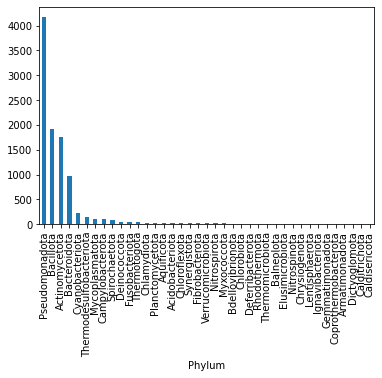

In [48]:
# plot by rank abundance the total # of species per phyla

df_phylum_sort = df_phylum.sort_values(by=['total # of species'], ascending=False)
df_phylum_sort['total # of species'].plot.bar()

In [50]:
# 2. GROUP BY CLASS

# counts non missing values
df_class1 = df2.groupby(['Class','Phylum']).count()['IMG Genome ID']

# sums ones and zeros
df_class2 = df2.groupby(['Class','Phylum']).sum()

# merge
df_class = pd.merge(df_class1, df_class2, on=['Class','Phylum'])

# rename columns
df_class.rename(columns = {'IMG Genome ID':'total # of species'}, inplace = True)

In [58]:
# Gives an idea of the range of sp per class but isn't very helpful. Commenting out for now.
# plot by rank abundance the total # of species per class

# df_class_sort = df_class.sort_values(by=['total # of species'], ascending=False)
# ax = df_class_sort[['total # of species']].plot.bar()

In [52]:
# 3. GROUP BY ORDER

# counts non missing values
df_order1 = df2.groupby(['Order','Phylum']).count()['IMG Genome ID']

# sums ones and zeros
df_order2 = df2.groupby(['Order','Phylum']).sum()

# merge
df_order = pd.merge(df_order1, df_order2, on=['Order','Phylum'])

# rename columns
df_order.rename(columns = {'IMG Genome ID':'total # of species'}, inplace = True)

In [59]:
# plot by rank abundance the total # of species per order

# df_order_sort = df_order.sort_values(by=['total # of species'], ascending=False)
# df_order_sort[['total # of species']].plot.bar(figsize=(25,5))

In [54]:
# 4. GROUP BY FAMILY

# counts non missing values
df_family1 = df2.groupby(['Family','Phylum']).count()['IMG Genome ID']

# sums ones and zeros
df_family2 = df2.groupby(['Family','Phylum']).sum()

# merge
df_family = pd.merge(df_family1, df_family2, on=['Family','Phylum'])

# rename columns
df_family.rename(columns = {'IMG Genome ID':'total # of species'}, inplace = True)

In [60]:
# plot by rank abundance the total # of species per family

# df_family_sort = df_family.sort_values(by=['total # of species'], ascending=False)
# df_family_sort[['total # of species']].plot.bar(figsize=(25,5))

In [56]:
# 5. GROUP BY GENUS

# counts non missing values
df_genus1 = df2.groupby('Genus').count()['IMG Genome ID']

# sums ones and zeros
df_genus2 = df2.groupby('Genus').sum()

# merge
df_genus = pd.merge(df_genus1, df_genus2, on='Genus')

# rename columns
df_genus.rename(columns = {'IMG Genome ID':'total # of species'}, inplace = True)


<AxesSubplot:xlabel='Genus'>

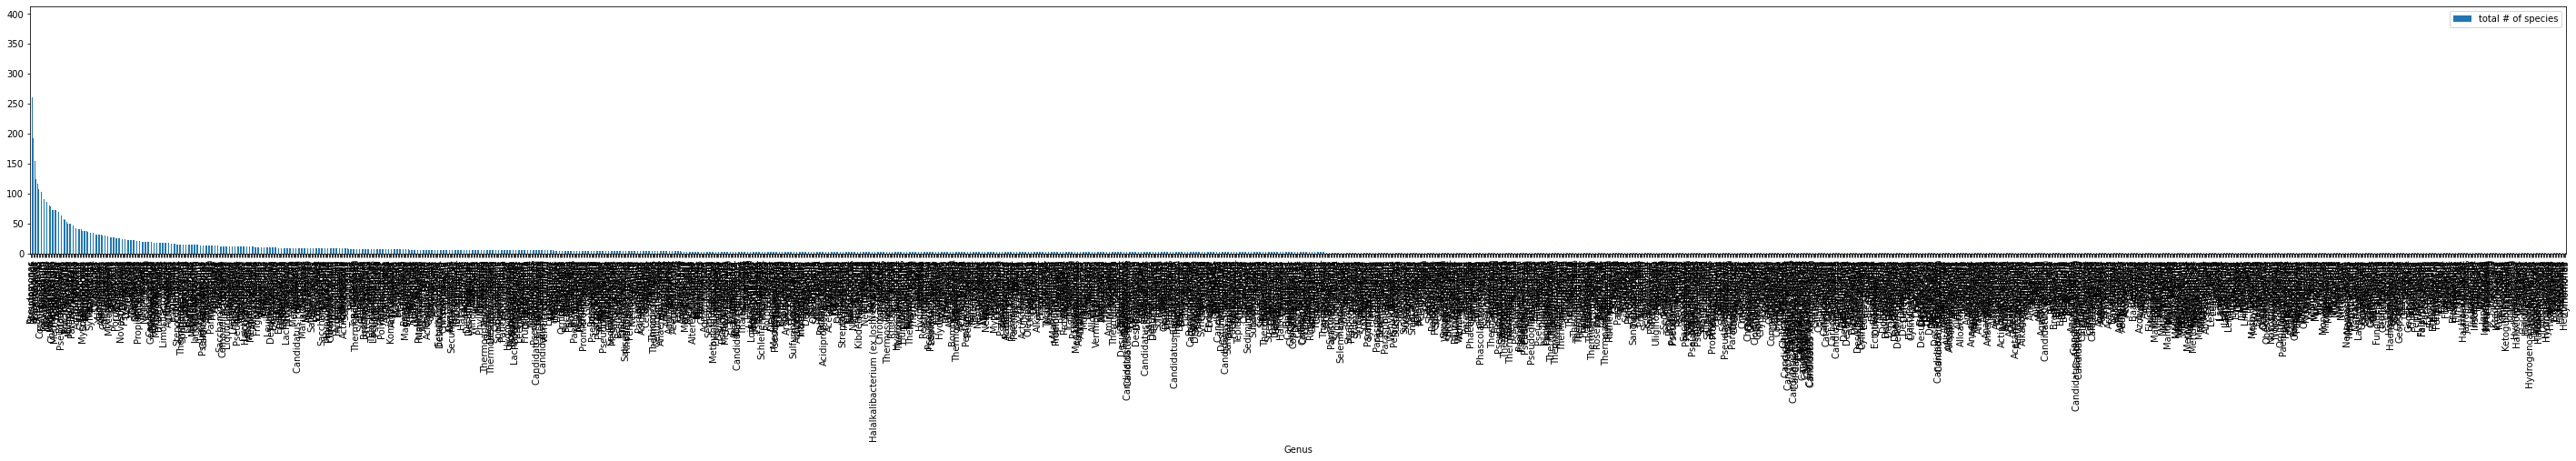

In [57]:
# plot by rank abundance the total # of species per genus

# df_genus_sort = df_genus.sort_values(by=['total # of species'], ascending=False)
# df_genus_sort[['total # of species']].plot.bar(figsize=(50,5))

In [61]:
# I want to also group by genus and phylum so I can break up my graphs
# This is the dataframe I will be using for most analuyses

# 6. GROUP BY GENUS & PHYLUM

# counts non missing values
df_gp1 = df2.groupby(['Genus','Phylum']).count()['IMG Genome ID']

# sums ones and zeros
df_gp2 = df2.groupby(['Genus','Phylum']).sum()

# merge
df_gp = pd.merge(df_gp1, df_gp2, on=['Genus','Phylum'])

# rename columns
df_gp.rename(columns = {'IMG Genome ID':'total # of species'}, inplace = True)

In [63]:
print(df_gp.shape)

(1914, 36)


# 7. Evaluating the percentages of species corresponding to each category by taxon group.
I'm going to start making calls - insted of %, what number/number of species in a taxonomic category are producer/user. Can determine cutoffs later.
At this point I have not filtered anything yet.

In [65]:
list(df_phylum.columns)

['total # of species',
 'cba dependent metabolism genes',
 'carbon nitrogen metabolism genes',
 'one carbon metabolism genes',
 'natl product synthesis genes',
 'bacteriochlorophyll synthesis genes',
 'methionine synthesis genes',
 'mercury methylation genes',
 'nucleotide metabolism genes',
 'reductive dehalogenation genes',
 'cba independent alternative genes',
 'independent carbon nitrogen metabolism genes',
 'independent nucleotide metabolism',
 'independent methionine synthesis',
 'cba biosynthesis genes',
 'aerobic biosynthesis genes',
 'anaerobic biosynthesis genes',
 'tetrapyrrole precursor biosynthesis genes',
 'corrin ring biosynthesis genes',
 'aminopropanol linker genes',
 'adenosylation genes',
 'nucleotide loop assembly genes',
 'core biosynthesis genes',
 'corrinoid remodeling gene',
 'tetrapyrrole precursor salvager',
 'Cbi salvager',
 'corrinoid precursor salvager',
 'corrinoid producer',
 'corrinoid non-producer',
 'corrinoid independent',
 'not corrinoid user',
 'cor

In [69]:
# Defining columns for which I want to get a percentage (sp with x / total sp)

pct_columns = ['cba dependent metabolism genes',
               'carbon nitrogen metabolism genes',
               'one carbon metabolism genes',
               'natl product synthesis genes',
               'bacteriochlorophyll synthesis genes',
               'methionine synthesis genes',
               'mercury methylation genes',
               'nucleotide metabolism genes',
               'reductive dehalogenation genes',
               'cba independent alternative genes',
               'independent carbon nitrogen metabolism genes',
               'independent nucleotide metabolism',
               'independent methionine synthesis',
               'cba biosynthesis genes',
               'aerobic biosynthesis genes',
               'anaerobic biosynthesis genes',
               'tetrapyrrole precursor biosynthesis genes',
               'corrin ring biosynthesis genes',
               'aminopropanol linker genes',
               'adenosylation genes',
               'nucleotide loop assembly genes',
               'core biosynthesis genes',
               'corrinoid remodeling gene',
               'tetrapyrrole precursor salvager',
               'Cbi salvager',
               'corrinoid precursor salvager',
               'corrinoid producer',
               'corrinoid non-producer',
               'corrinoid independent',
               'corrinoid user',
               'not corrinoid user',
               'corrinoid user with alternative',
               'corrinoid user no alternative',
               'corrinoid precursor salvager',
               'corrinoid dependent',
               'corrinoid dependent no alternatives'
              ]

In [67]:
# Function to quickly get percentages for each dataframe

def get_percent(df):
    for c in pct_columns:
        df['% '+c] = (df[c]/df['total # of species']) * 100
    
    return df

In [70]:
get_percent(df_phylum)

total # of species  cba dependent metabolism genes  \
Phylum                                                                        
Acidobacteriota                          21                              21   
Actinomycetota                         1749                            1236   
Aquificota                               21                              13   
Armatimonadota                            2                               2   
Bacillota                              1926                            1662   
Bacteroidota                            971                             934   
Balneolota                                3                               3   
Bdellovibrionota                         12                              10   
Caldisericota                             1                               0   
Calditrichota                             1                               1   
Campylobacterota                        108                              48   
Chlamydiota                              26                              15   
Chlorobiota                              10                              10   
Chloroflexota                            20                              20   
Chrysiogenota                             2                               2   
Coprothermobacterota                      2                               2   
Cyanobacteriota                         218                             218   
Deferribacterota                          7                               7   
Deinococcota                             52                              52   
Dictyoglomota                             2                               2   
Elusimicrobiota                           3                               2   
Fibrobacterota                           19                              19   
Fusobacteriota                           51                              48   
Gemmatimonadota                           2                               2   
Ignavibacteriota                          2                               2   
Lentisphaerota                            2                               2   
Mycoplasmatota                          111                              15   
Myxococcota                              17                              17   
Nitrospinota                              2                               2   
Nitrospirota                             17                              16   
Planctomycetota                          26                              26   
Pseudomonadota                         4172                            3916   
Rhodothermota                             4                               4   
Spirochaetota                            93                              64   
Synergistota                             19                              19   
Thermodesulfobacteriota                 154                             152   
Thermomicrobiota                          3                               3   
Thermotogota                             35                              35   
Verrucomicrobiota                        19                              15   

                         carbon nitrogen metabolism genes  \
Phylum                                                      
Acidobacteriota                                        20   
Actinomycetota                                       1095   
Aquificota                                              0   
Armatimonadota                                          1   
Bacillota                                             838   
Bacteroidota                                          873   
Balneolota                                              3   
Bdellovibrionota                                       10   
Caldisericota                                           0   
Calditrichota                                           1   
Campylobacterota                                     

In [71]:
get_percent(df_class)

total # of species  \
Class                  Phylum                                        
Acidimicrobiia         Actinomycetota                            7   
Acidithiobacillia      Pseudomonadota                            5   
Actinomycetes          Actinomycetota                         1688   
Alphaproteobacteria    Pseudomonadota                         1450   
Anaerolineae           Chloroflexota                             2   
Aquificae              Aquificota                               21   
Ardenticatenia         Chloroflexota                             1   
Bacilli                Bacillota                              1230   
Bacteriovoracia        Bdellovibrionota                          7   
Bacteroidia            Bacteroidota                            260   
Balneolia              Balneolota                                3   
Bdellovibrionia        Bdellovibrionota                          4   
Betaproteobacteria     Pseudomonadota                          671   
Blastocatellia         Acidobacteriota                           1   
Caldilineae            Chloroflexota                             1   
Caldisericia           Caldisericota                             1   
Calditrichia           Calditrichota                             1   
Chitinispirillia       Fibrobacterota                            1   
Chitinivibrionia       Fibrobacterota                            1   
Chitinophagia          Bacteroidota                             43   
Chlamydiia             Chlamydiota                              26   
Chlorobiia             Chlorobiota                              10   
Chloroflexia           Chloroflexota                            10   
Chrysiogenetes         Chrysiogenota                             2   
Chthonomonadetes       Armatimonadota                            1   
Clostridia             Bacillota                               525   
Coprothermobacteria    Coprothermobacterota                      2   
Coriobacteriia         Actinomycetota                           44   
Cyanophyceae           Cyanobacteriota                         218   
Cytophagia             Bacteroidota                            126   
Deferribacteres        Deferribacterota                          7   
Deferrisomatia         Thermodesulfobacteriota                   1   
Dehalococcoidia        Chloroflexota                             2   
Deinococci             Deinococcota                             52   
Desulfarculia          Thermodesulfobacteriota                   3   
Desulfobaccia          Thermodesulfobacteriota                   1   
Desulfobacteria        Thermodesulfobacteriota                  24   
Desulfobulbia          Thermodesulfobacteriota                   9   
Desulfomonilia         Thermodesulfobacteriota                   1   
Desulfovibrionia       Thermodesulfobacteriota                  69   
Desulfurellia          Campylobacterota                          6   
Desulfuromonadia       Thermodesulfobacteriota                  28   
Dictyoglomia           Dictyoglomota                             2   
Elusimicrobia          Elusimicrobiota                           1   
Endomicrobiia          Elusimicrobiota                           2   
Epsilonproteobacteria  Campylobacterota                        102   
Erysipelotrichia       Bacillota                                34   
Fibrobacteria          Fibrobacterota                           17   
Fimbriimonadia         Armatimonadota                            1   
Flavobacteriia         Bacteroidota                            460   
Fusobacteriia          Fusobacteriota                           51   
Gammaproteobacteria    Pseudomonadota                         2041   
Gemmatimonadetes       Gemmatimonadota                           2   
Holophagae             Acidobacteriota                           2   
Hydrogenophilia        Pseudomonadota                            2   
Ignavibacteria         Ignavibacteriota                   

In [72]:
get_percent(df_order)

total # of species  \
Order               Phylum                                  
Acholeplasmatales   Mycoplasmatota                     19   
Acidaminococcales   Bacillota                           9   
Acidimicrobiales    Actinomycetota                      7   
Acidithiobacillales Pseudomonadota                      5   
Acidothermales      Actinomycetota                      1   
...                                                   ...   
Verrucomicrobiales  Verrucomicrobiota                  11   
Vibrionales         Pseudomonadota                    139   
Vicinamibacterales  Acidobacteriota                     1   
Victivallales       Lentisphaerota                      1   
Xanthomonadales     Pseudomonadota                    143   

                                       cba dependent metabolism genes  \
Order               Phylum                                              
Acholeplasmatales   Mycoplasmatota                                  2   
Acidaminococcales   Bacillota                                       9   
Acidimicrobiales    Actinomycetota                                  7   
Acidithiobacillales Pseudomonadota                                  2   
Acidothermales      Actinomycetota                                  1   
...                                                               ...   
Verrucomicrobiales  Verrucomicrobiota                              10   
Vibrionales         Pseudomonadota                                137   
Vicinamibacterales  Acidobacteriota                                 1   
Victivallales       Lentisphaerota                                  1   
Xanthomonadales     Pseudomonadota                                142   

                                       carbon nitrogen metabolism genes  \
Order               Phylum                                                
Acholeplasmatales   Mycoplasmatota                                    0   
Acidaminococcales   Bacillota                                         3   
Acidimicrobiales    Actinomycetota                                    7   
Acidithiobacillales Pseudomonadota                                    0   
Acidothermales      Actinomycetota                                    1   
...                                                                 ...   
Verrucomicrobiales  Verrucomicrobiota                                 4   
Vibrionales         Pseudomonadota                                   32   
Vicinamibacterales  Acidobacteriota                                   1   
Victivallales       Lentisphaerota                                    0   
Xanthomonadales     Pseudomonadota                                  121   

                                       one carbon metabolism genes  \
Order               Phylum                                           
Acholeplasmatales   Mycoplasmatota                               0   
Acidaminococcales   Bacillota                                    0   
Acidimicrobiales    Actinomycetota                               1   
Acidithiobacillales Pseudomonadota                               0   
Acidothermales      Actinomycetota                               0   
...                                                            ...   
Verrucomicrobiales  Verrucomicrobiota                            0   
Vibrionales         Pseudomonadota                               0   
Vicinamibacterales  Acidobacteriota                              0   
Victivallales       Lentisphaerota                               0   
Xanthomonadales     Pseudomonadota                               0   

                                       natl product synthesis genes  \
Order               Phylum                                            
Acholeplasmatales   Mycoplasmatota                                0   
Acidaminococcales   Bacillota                                     3   
Acidimicrobiales    Actinomycetota                                0   
Acidithiobacillales Pseudomonadota                   

In [73]:
get_percent(df_family)

total # of species  \
Family             Phylum                                
Acaryochloridaceae Cyanobacteriota                   2   
Acetobacteraceae   Pseudomonadota                   58   
Acetomicrobiaceae  Synergistota                      4   
Acholeplasmataceae Mycoplasmatota                   19   
Acidaminococcaceae Bacillota                         9   
...                                                ...   
Xenococcaceae      Cyanobacteriota                   1   
Yersiniaceae       Pseudomonadota                   50   
Zoogloeaceae       Pseudomonadota                   16   
Zooshikellaceae    Pseudomonadota                    1   
Zymomonadaceae     Pseudomonadota                    1   

                                    cba dependent metabolism genes  \
Family             Phylum                                            
Acaryochloridaceae Cyanobacteriota                               2   
Acetobacteraceae   Pseudomonadota                               56   
Acetomicrobiaceae  Synergistota                                  4   
Acholeplasmataceae Mycoplasmatota                                2   
Acidaminococcaceae Bacillota                                     9   
...                                                            ...   
Xenococcaceae      Cyanobacteriota                               1   
Yersiniaceae       Pseudomonadota                               49   
Zoogloeaceae       Pseudomonadota                               16   
Zooshikellaceae    Pseudomonadota                                1   
Zymomonadaceae     Pseudomonadota                                1   

                                    carbon nitrogen metabolism genes  \
Family             Phylum                                              
Acaryochloridaceae Cyanobacteriota                                 0   
Acetobacteraceae   Pseudomonadota                                 45   
Acetomicrobiaceae  Synergistota                                    4   
Acholeplasmataceae Mycoplasmatota                                  0   
Acidaminococcaceae Bacillota                                       3   
...                                                              ...   
Xenococcaceae      Cyanobacteriota                                 0   
Yersiniaceae       Pseudomonadota                                 34   
Zoogloeaceae       Pseudomonadota                                 16   
Zooshikellaceae    Pseudomonadota                                  0   
Zymomonadaceae     Pseudomonadota                                  0   

                                    one carbon metabolism genes  \
Family             Phylum                                         
Acaryochloridaceae Cyanobacteriota                            0   
Acetobacteraceae   Pseudomonadota                             0   
Acetomicrobiaceae  Synergistota                               0   
Acholeplasmataceae Mycoplasmatota                             0   
Acidaminococcaceae Bacillota                                  0   
...                                                         ...   
Xenococcaceae      Cyanobacteriota                            0   
Yersiniaceae       Pseudomonadota                             0   
Zoogloeaceae       Pseudomonadota                             1   
Zooshikellaceae    Pseudomonadota                             0   
Zymomonadaceae     Pseudomonadota                             0   

                                    natl product synthesis genes  \
Family             Phylum                                          
Acaryochloridaceae Cyanobacteriota                             2   
Acetobacteraceae   Pseudomonadota                             33   
Acetomicrobiaceae  Synergistota                                4   
Acholeplasmataceae Mycoplasmatota                              0   
Acidaminococcaceae Bacillota                                   3   
...                                                          ...   
Xenococcaceae    

In [74]:
get_percent(df_genus)

total # of species  cba dependent metabolism genes  \
Genus                                                                     
Abiotrophia                           1                               0   
Abyssisolibacter                      1                               1   
Acaricomes                            1                               0   
Acaryochloris                         2                               2   
Acetanaerobacterium                   1                               1   
...                                 ...                             ...   
Zoogloea                              1                               1   
Zooshikella                           1                               1   
Zunongwangia                          2                               2   
Zymobacter                            1                               1   
Zymomonas                             1                               1   

                     carbon nitrogen metabolism genes  \
Genus                                                   
Abiotrophia                                         0   
Abyssisolibacter                                    1   
Acaricomes                                          0   
Acaryochloris                                       0   
Acetanaerobacterium                                 0   
...                                               ...   
Zoogloea                                            1   
Zooshikella                                         0   
Zunongwangia                                        2   
Zymobacter                                          0   
Zymomonas                                           0   

                     one carbon metabolism genes  \
Genus                                              
Abiotrophia                                    0   
Abyssisolibacter                               1   
Acaricomes                                     0   
Acaryochloris                                  0   
Acetanaerobacterium                            0   
...                                          ...   
Zoogloea                                       0   
Zooshikella                                    0   
Zunongwangia                                   0   
Zymobacter                                     0   
Zymomonas                                      0   

                     natl product synthesis genes  \
Genus                                               
Abiotrophia                                     0   
Abyssisolibacter                                1   
Acaricomes                                      0   
Acaryochloris                                   2   
Acetanaerobacterium                             1   
...                                           ...   
Zoogloea                                        1   
Zooshikella                                     0   
Zunongwangia                                    0   
Zymobacter                                      0   
Zymomonas                                       0   

                     bacteriochlorophyll synthesis genes  \
Genus                                                      
Abiotrophia                                            0   
Abyssisolibacter                                       0   
Acaricomes                                             0   
Acaryochloris                                          0   
Acetanaerobacterium                                    0   
...                                                  ...   
Zoogloea                                               0   
Zooshikella                                            0   
Zunongwangia                                           0   
Zymobacter                                             0   
Zymomonas                                              0   

                     methionine synthesis genes  mercury methylation genes  \
Genus                                                                        

In [75]:
get_percent(df_gp)

total # of species  \
Genus               Phylum                                
Abiotrophia         Bacillota                         1   
Abyssisolibacter    Bacillota                         1   
Acaricomes          Actinomycetota                    1   
Acaryochloris       Cyanobacteriota                   2   
Acetanaerobacterium Bacillota                         1   
...                                                 ...   
Zoogloea            Pseudomonadota                    1   
Zooshikella         Pseudomonadota                    1   
Zunongwangia        Bacteroidota                      2   
Zymobacter          Pseudomonadota                    1   
Zymomonas           Pseudomonadota                    1   

                                     cba dependent metabolism genes  \
Genus               Phylum                                            
Abiotrophia         Bacillota                                     0   
Abyssisolibacter    Bacillota                                     1   
Acaricomes          Actinomycetota                                0   
Acaryochloris       Cyanobacteriota                               2   
Acetanaerobacterium Bacillota                                     1   
...                                                             ...   
Zoogloea            Pseudomonadota                                1   
Zooshikella         Pseudomonadota                                1   
Zunongwangia        Bacteroidota                                  2   
Zymobacter          Pseudomonadota                                1   
Zymomonas           Pseudomonadota                                1   

                                     carbon nitrogen metabolism genes  \
Genus               Phylum                                              
Abiotrophia         Bacillota                                       0   
Abyssisolibacter    Bacillota                                       1   
Acaricomes          Actinomycetota                                  0   
Acaryochloris       Cyanobacteriota                                 0   
Acetanaerobacterium Bacillota                                       0   
...                                                               ...   
Zoogloea            Pseudomonadota                                  1   
Zooshikella         Pseudomonadota                                  0   
Zunongwangia        Bacteroidota                                    2   
Zymobacter          Pseudomonadota                                  0   
Zymomonas           Pseudomonadota                                  0   

                                     one carbon metabolism genes  \
Genus               Phylum                                         
Abiotrophia         Bacillota                                  0   
Abyssisolibacter    Bacillota                                  1   
Acaricomes          Actinomycetota                             0   
Acaryochloris       Cyanobacteriota                            0   
Acetanaerobacterium Bacillota                                  0   
...                                                          ...   
Zoogloea            Pseudomonadota                             0   
Zooshikella         Pseudomonadota                             0   
Zunongwangia        Bacteroidota                               0   
Zymobacter          Pseudomonadota                             0   
Zymomonas           Pseudomonadota                             0   

                                     natl product synthesis genes  \
Genus               Phylum                                          
Abiotrophia         Bacillota                                   0   
Abyssisolibacter    Bacillota                                   1   
Acaricomes          Actinomycetota                              0   
Acaryochloris       Cyanobacteriota                             2   
Acetanaerobacterium Bacillota                                   1   
...                        

# 8. Assigning predictions to genera with ≥ 20 species

20 was chosen by me and Michi because we want to make calls at 95% accuracy, and 19/20 = .95. This means that we should have at least 20 to get good enough prediction accuracy.

In [80]:
df_gp['call'] = 'None'
for row in df_gp.index:
    if df_gp.loc[row, 'total # of species'] >= 20:
        if df_gp.loc[row, '% corrinoid producer'] >= 95:
            df_gp.loc[row, 'call'] = 'Producer'
        elif df_gp.loc[row, '% corrinoid dependent'] >= 95:
            df_gp.loc[row, 'call'] = 'Dependent'
        elif df_gp.loc[row, '% corrinoid independent'] >= 95:
            df_gp.loc[row, 'call'] = 'Independent'
        else:
            df_gp.loc[row,'call'] = 'None'

# In case I need individual columns:

# df_gp['call_producer'] = False
# df_gp['call_non_producer'] = False
# df_gp['call_dependent'] = False
# df_gp['call_dependent_noalt'] = False
# df_gp['call_independent'] = False
# df_gp['no_call'] = False

# for row in df_gp.index:
#     if df_gp.loc[row, '% corrinoid producer'] > 95:
#         df_gp.loc[row, 'call_producer'] = True
#     elif df_gp.loc[row, '% corrinoid producer'] < 5:
#         df_gp.loc[row, 'call_non_producer'] = True
#     elif df_gp.loc[row, '% corrinoid dependent'] > 95:
#         df_gp.loc[row, 'call_dependent'] = True
#     elif df_gp.loc[row, '% corrinoid dependent no alternatives'] > 95:
#         df_gp.loc[row, 'call_dependent_noalt'] = True
#     elif df_gp.loc[row, '% corrinoid independent'] > 95:
#         df_gp.loc[row, 'call_independent'] = True
#     else:
#         df_gp.loc[row,'no_call'] = True

In [81]:
df_gp[df_gp['call']!='None'].shape

(47, 72)

In [ ]:
# SAVE TO CSV
# Update date before saving
# df_gp[df_gp['call']!='None'].to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/calls_true_230727.csv')
# df_gp.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/dfgp_230727.csv')
# df_phylum.to_csv('df_phylum_230727.csv')

In [82]:
# Pulling genera with at least 20 species
twenty_sp = df_gp[df_gp['total # of species']>= 20]
twenty_sp

total # of species  \
Genus             Phylum                                 
Achromobacter     Pseudomonadota                    41   
Acidovorax        Pseudomonadota                    27   
Acinetobacter     Pseudomonadota                   124   
Actinomyces       Actinomycetota                    37   
Aeromonas         Pseudomonadota                    35   
Amycolatopsis     Actinomycetota                    30   
Arthrobacter      Actinomycetota                    70   
Bacillus          Bacillota                        192   
Bacteroides       Bacteroidota                      62   
Bartonella        Pseudomonadota                    27   
Bifidobacterium   Actinomycetota                    50   
Bradyrhizobium    Pseudomonadota                    65   
Brucella          Pseudomonadota                    32   
Burkholderia      Pseudomonadota                    73   
Butyrivibrio      Bacillota                         42   
Campylobacter     Campylobacterota                  30   
Cellulomonas      Actinomycetota                    21   
Chryseobacterium  Bacteroidota                      73   
Citrobacter       Pseudomonadota                    32   
Clostridium       Bacillota                         90   
Corynebacterium   Actinomycetota                   105   
Cupriavidus       Pseudomonadota                    22   
Deinococcus       Deinococcota                      24   
Demequina         Actinomycetota                    22   
Devosia           Pseudomonadota                    23   
Ensifer           Pseudomonadota                    21   
Enterobacter      Pseudomonadota                    80   
Enterococcus      Bacillota                         41   
Flavobacterium    Bacteroidota                     102   
Fusobacterium     Fusobacteriota                    29   
Geobacillus       Bacillota                         27   
Gordonia          Actinomycetota                    29   
Halomonas         Pseudomonadota                    57   
Helicobacter      Campylobacterota                  32   
Klebsiella        Pseudomonadota                    52   
Lactobacillus     Bacillota                         40   
Legionella        Pseudomonadota                    47   
Leifsonia         Actinomycetota                    22   
Leptospira        Spirochaetota                     26   
Lysinibacillus    Bacillota                         25   
Lysobacter        Pseudomonadota                    24   
Marinobacter      Pseudomonadota                    38   
Mesorhizobium     Pseudomonadota                    86   
Methylobacterium  Pseudomonadota                    73   
Microbacterium    Actinomycetota                    79   
Micromonospora    Actinomycetota                    49   
Mycobacterium     Actinomycetota                    84   
Mycolicibacterium Actinomycetota                    38   
Mycoplasma        Mycoplasmatota                    22   
Mycoplasmopsis    Mycoplasmatota                    28   
Neisseria         Pseudomonadota                    20   
Nocardia          Actinomycetota                    45   
Nocardioides      Actinomycetota                    35   
Nocardiopsis      Actinomycetota                    21   
Novosphingobium   Pseudomonadota                    25   
Paenibacillus     Bacillota                        155   
Pantoea           Pseudomonadota                    34   
Paraburkholderia  Pseudomonadota                    47   
Paracoccus        Pseudomonadota                    25   
Pedobacter        Bacteroidota                      34   
Porphyromonas     Bacteroidota                      26   
Prevotella        Bacteroidota                      71   
Prochlorococcus   Cyanobacteriota                   56   
Propionibacterium Actinomycetota                    21   
Pseudoalteromonas Pseudomonadota                    63   
Pseudomonas       Pseudomonadota                   393   
Psychrobacter     Pseudomonadota                    24   
Rhizobium         Pseudomonadota  

In [84]:
df_gp['total # of species'].sum() # Checking that it is still the same as the total number of genomes when I dropped candidatus and unclassified genomes

9905

# 9. Heatmap generation

In [ ]:
# SAVING TO CSV TO GENERATE HEATMAP IN ITOL

twenty_sp[['total # of species',
           '% corrinoid producer',
           '% corrinoid dependent',
           '% corrinoid independent',
           'call']]#.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/genera_in_heatmap_230725.csv')



In [89]:
twenty_heatmap = twenty_sp[['% corrinoid producer','% corrinoid dependent','% corrinoid independent']]
# twenty_heatmap

<AxesSubplot:ylabel='Genus-Phylum'>

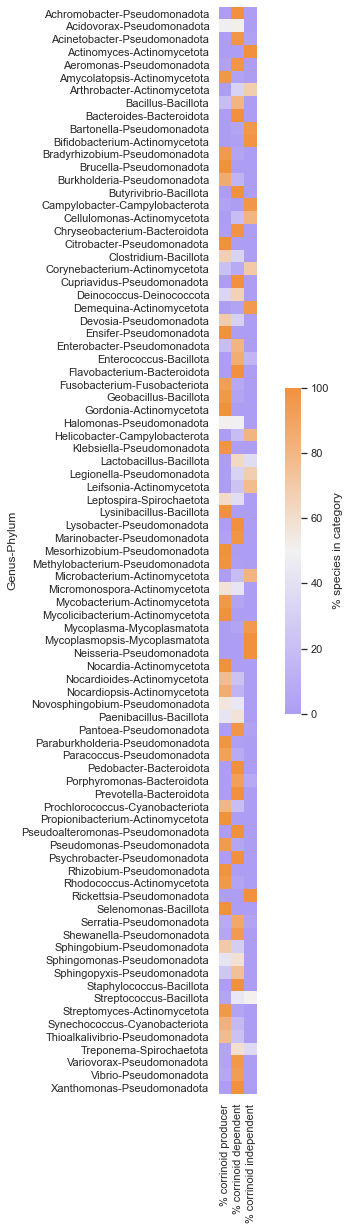

In [90]:
# HEATMAP SHOWING PRODUCER/DEPENDENT/INDEPENDENT PERCENTAGES FOR GENERA WITH MORE THAN 20 SPECIES
sns.set(font_scale=1)

fig, ax = plt.subplots(figsize=(10,20))  
# grid_spec = {"width_ratios": (.9, .05)}
# f, (ax, cbar_ax) = plt.subplots(1,2, figsize=(10,15),gridspec_kw=grid_spec) 
sns.heatmap(data = twenty_heatmap,
#             ax = ax,
           square = True,
            cmap = sns.diverging_palette(272, 36, as_cmap=True, s = 86, l=69),
#             cbar_ax = cbar_ax,
            cbar_kws={'label': '% species in category',"shrink": 0.3},

 )
# plt.savefig("/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/heatmap_draft1.png", dpi = 300)

## 9.1 Testing ecosystem analysis

In [ ]:
# Grouping by exosystem to see if the annotations are good enough for analysis
# It doesn't seem like they are
twenty_genera = list(twenty_sp.reset_index()['Genus'])
ecosys = df2[df2['Genus'].isin(twenty_genera)][['Genus','GenomeName','Ecosystem Category',
                                       'corrinoid producer','corrinoid dependent',
                                       'corrinoid independent']]#.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/twenty_genome_ecosystem.csv')
# twenty_sp

In [ ]:
ecosys.groupby(by = ['Genus','Ecosystem Category']).sum()#.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/twenty_genus_ecosystem_grouped.csv')
ecosys.groupby(by = ['Ecosystem Category']).sum()#.to_csv('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/twenty_ecosystem_grouped.csv')

# 10. Test Summary Figures

<AxesSubplot:xlabel='Phylum'>

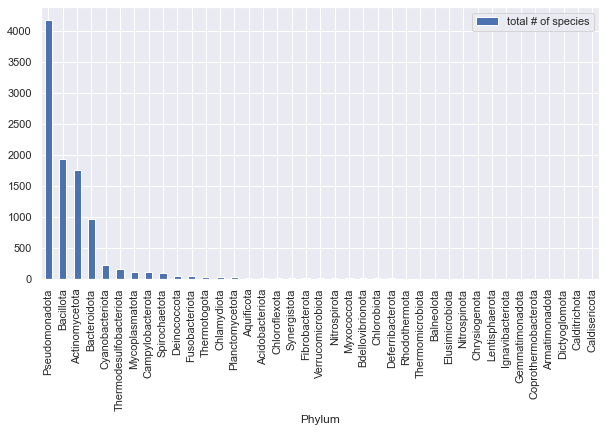

In [94]:
# plot by rank abundance the total # of species per phylum

df_phylum_sort = df_phylum.sort_values(by=['total # of species'], ascending=False)

df_phylum_sort[['total # of species']].plot.bar(figsize=(10,5))

<AxesSubplot:xlabel='Genus'>

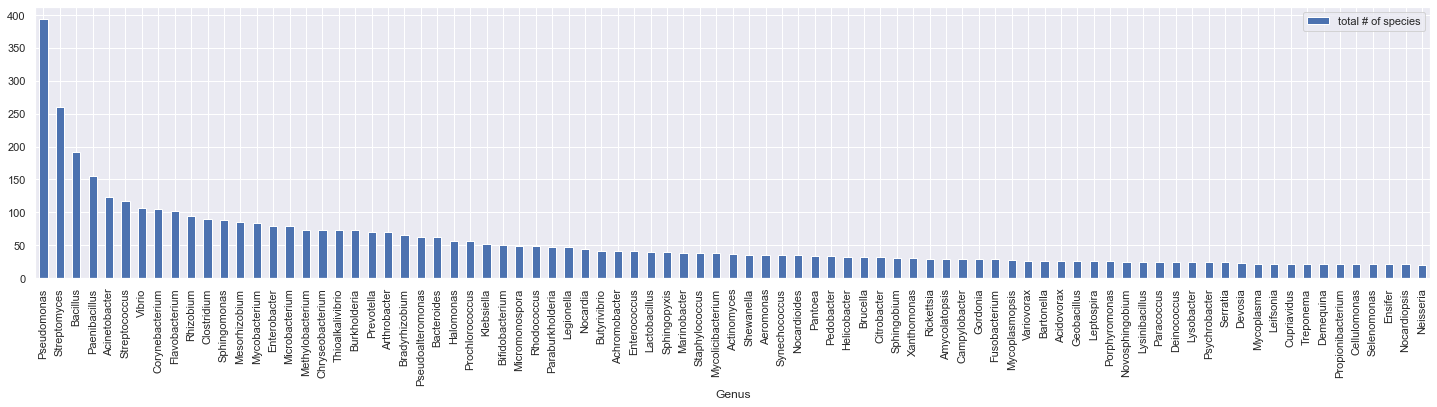

In [93]:
# plot by rank abundance the total # of species per genus in filtered dataset

df_genus_filtered = df_genus[df_genus['total # of species'] >= 20]
df_genus_filtered
df_genus_sort = df_genus_filtered.sort_values(by=['total # of species'], ascending=False)
df_genus_sort[['total # of species']].plot.bar(figsize=(25,5))

## 10.1 Phylum level summaries

<AxesSubplot:xlabel='Phylum', ylabel='Genus'>

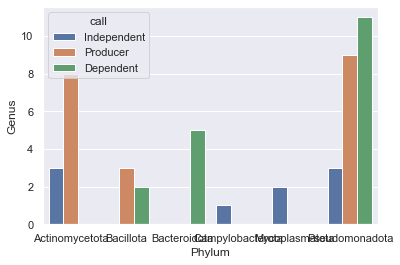

In [91]:
df_calls = df_gp[df_gp['call']!='None'].reset_index()
df_calls = df_calls.groupby(['Phylum','call']).count().reset_index()
df_calls
sns.barplot(data = df_calls,
           x = 'Phylum',
           y = 'Genus',
           hue = 'call')

In [96]:
# subset into big phyla and non big phyla (in terms of number of species)
sns.set_style("white")
# sns.set(font_scale=1.6)

big_phylum=df_phylum.loc[['Pseudomonadota','Actinomycetota','Bacillota','Bacteroidota']]  
big_phylum

small_phylum = df_phylum.drop(['Pseudomonadota','Actinomycetota','Bacillota','Bacteroidota']).sort_values('total # of species', ascending = False)
small_phylum

small_phylum = small_phylum[small_phylum['total # of species']>3]
df_phylum = df_phylum[df_phylum['total # of species']>3]

Text(0.5, 0, 'Phylum')

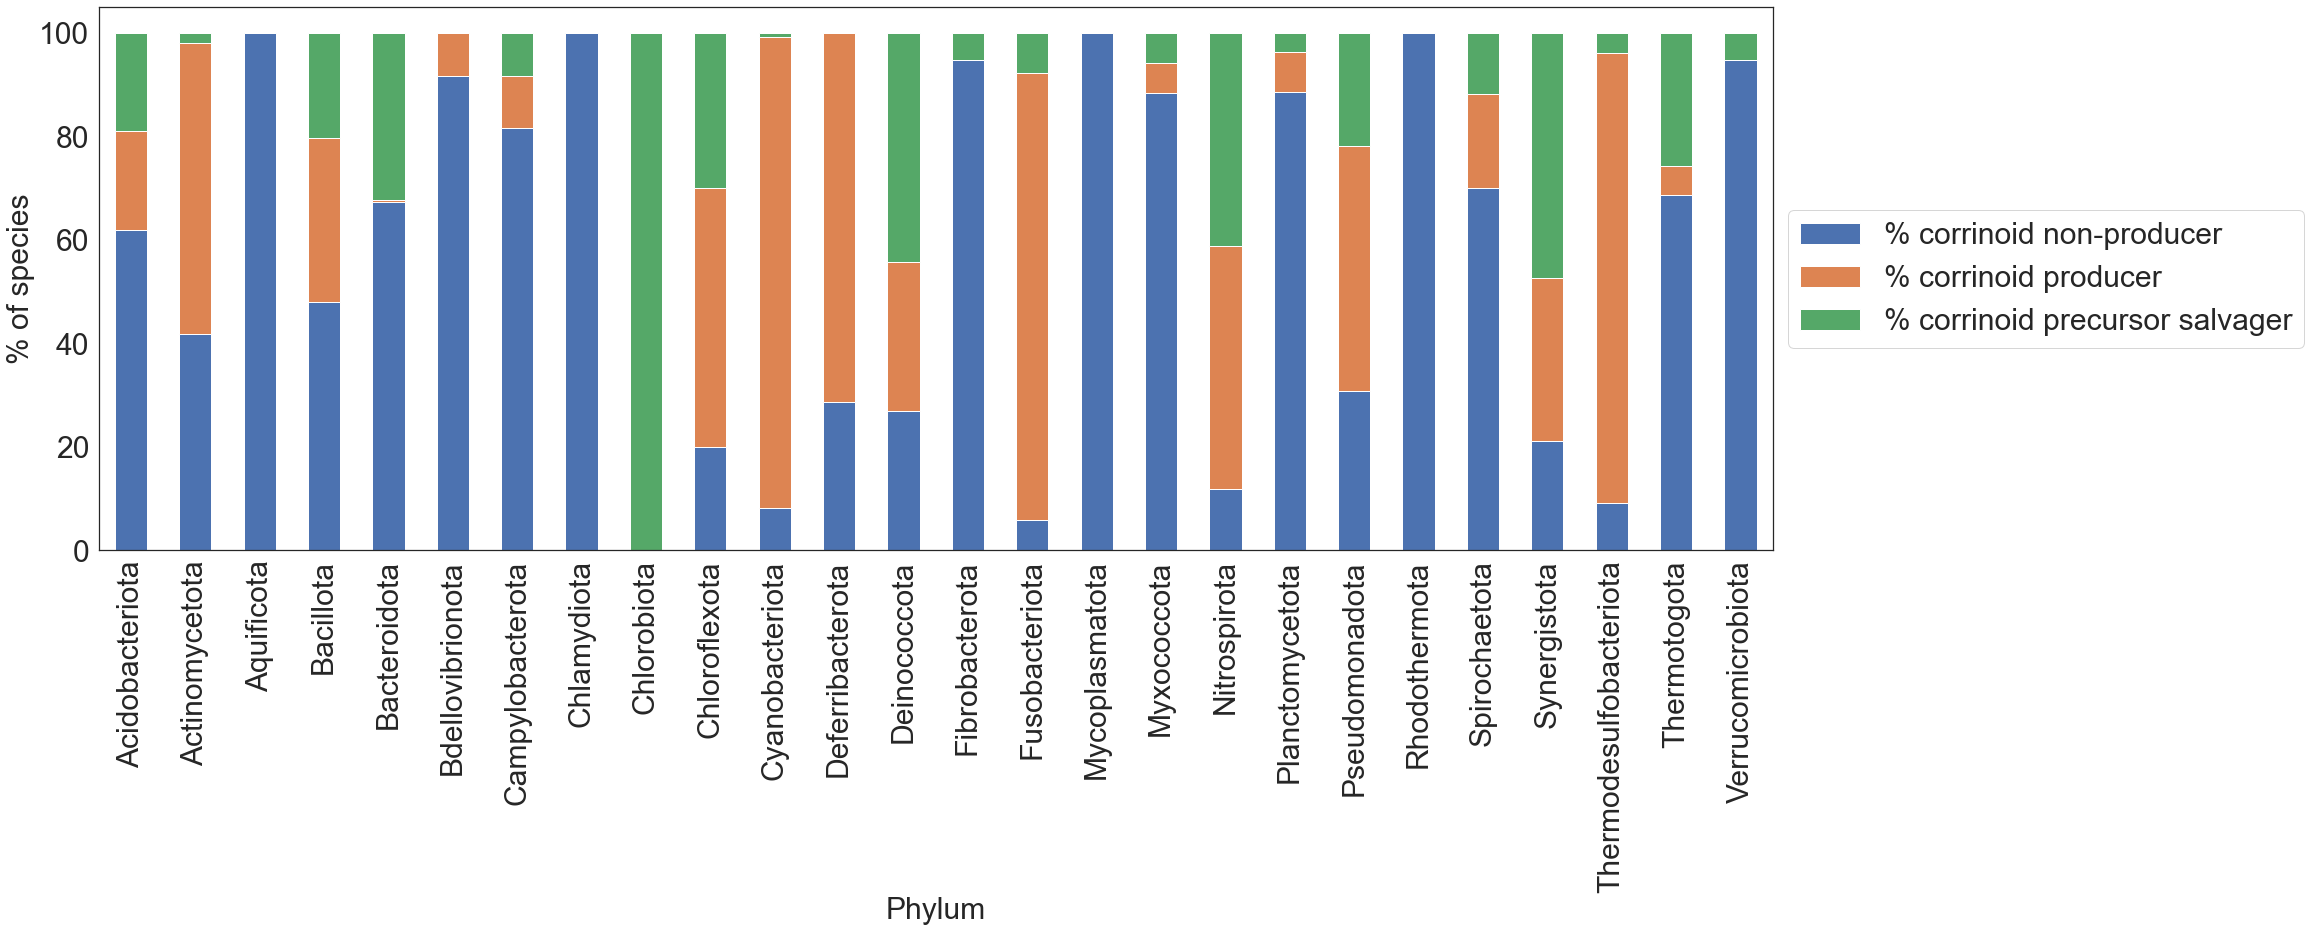

In [97]:
# sns.set(font_scale=1.6)
df_phylum[['% corrinoid non-producer',
              '% corrinoid producer',
              '% corrinoid precursor salvager'
              ]].plot.bar(stacked=True, figsize=(30,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 30)
plt.tick_params(labelsize = 30)
plt.ylabel('% of species', size=30)
plt.xlabel('Phylum',size=30)

Text(0.5, 0, 'Phylum')

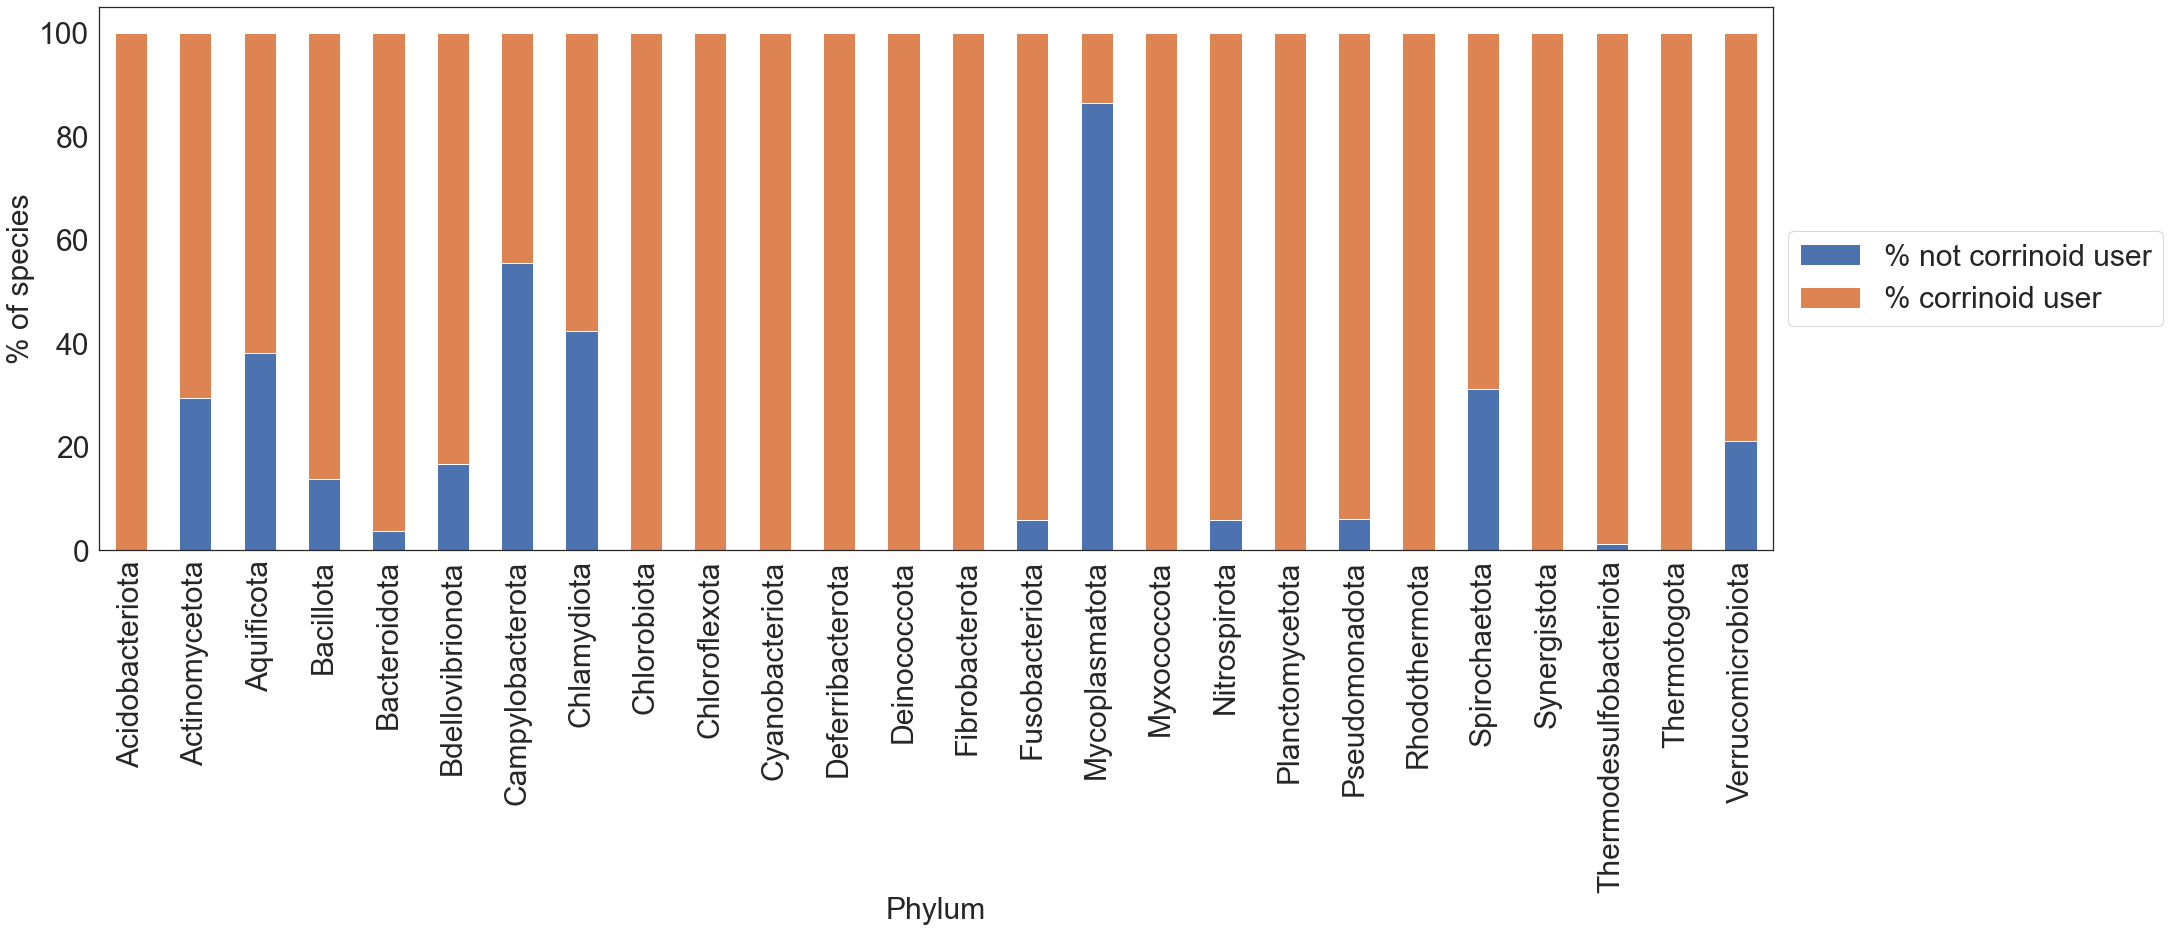

In [98]:
df_phylum[['% not corrinoid user',
           '% corrinoid user',
              ]].plot.bar(stacked=True, figsize=(30,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 30)
plt.tick_params(labelsize = 30)
plt.ylabel('% of species', size=30)
plt.xlabel('Phylum',size=30)

Text(0.5, 0, 'Phylum')

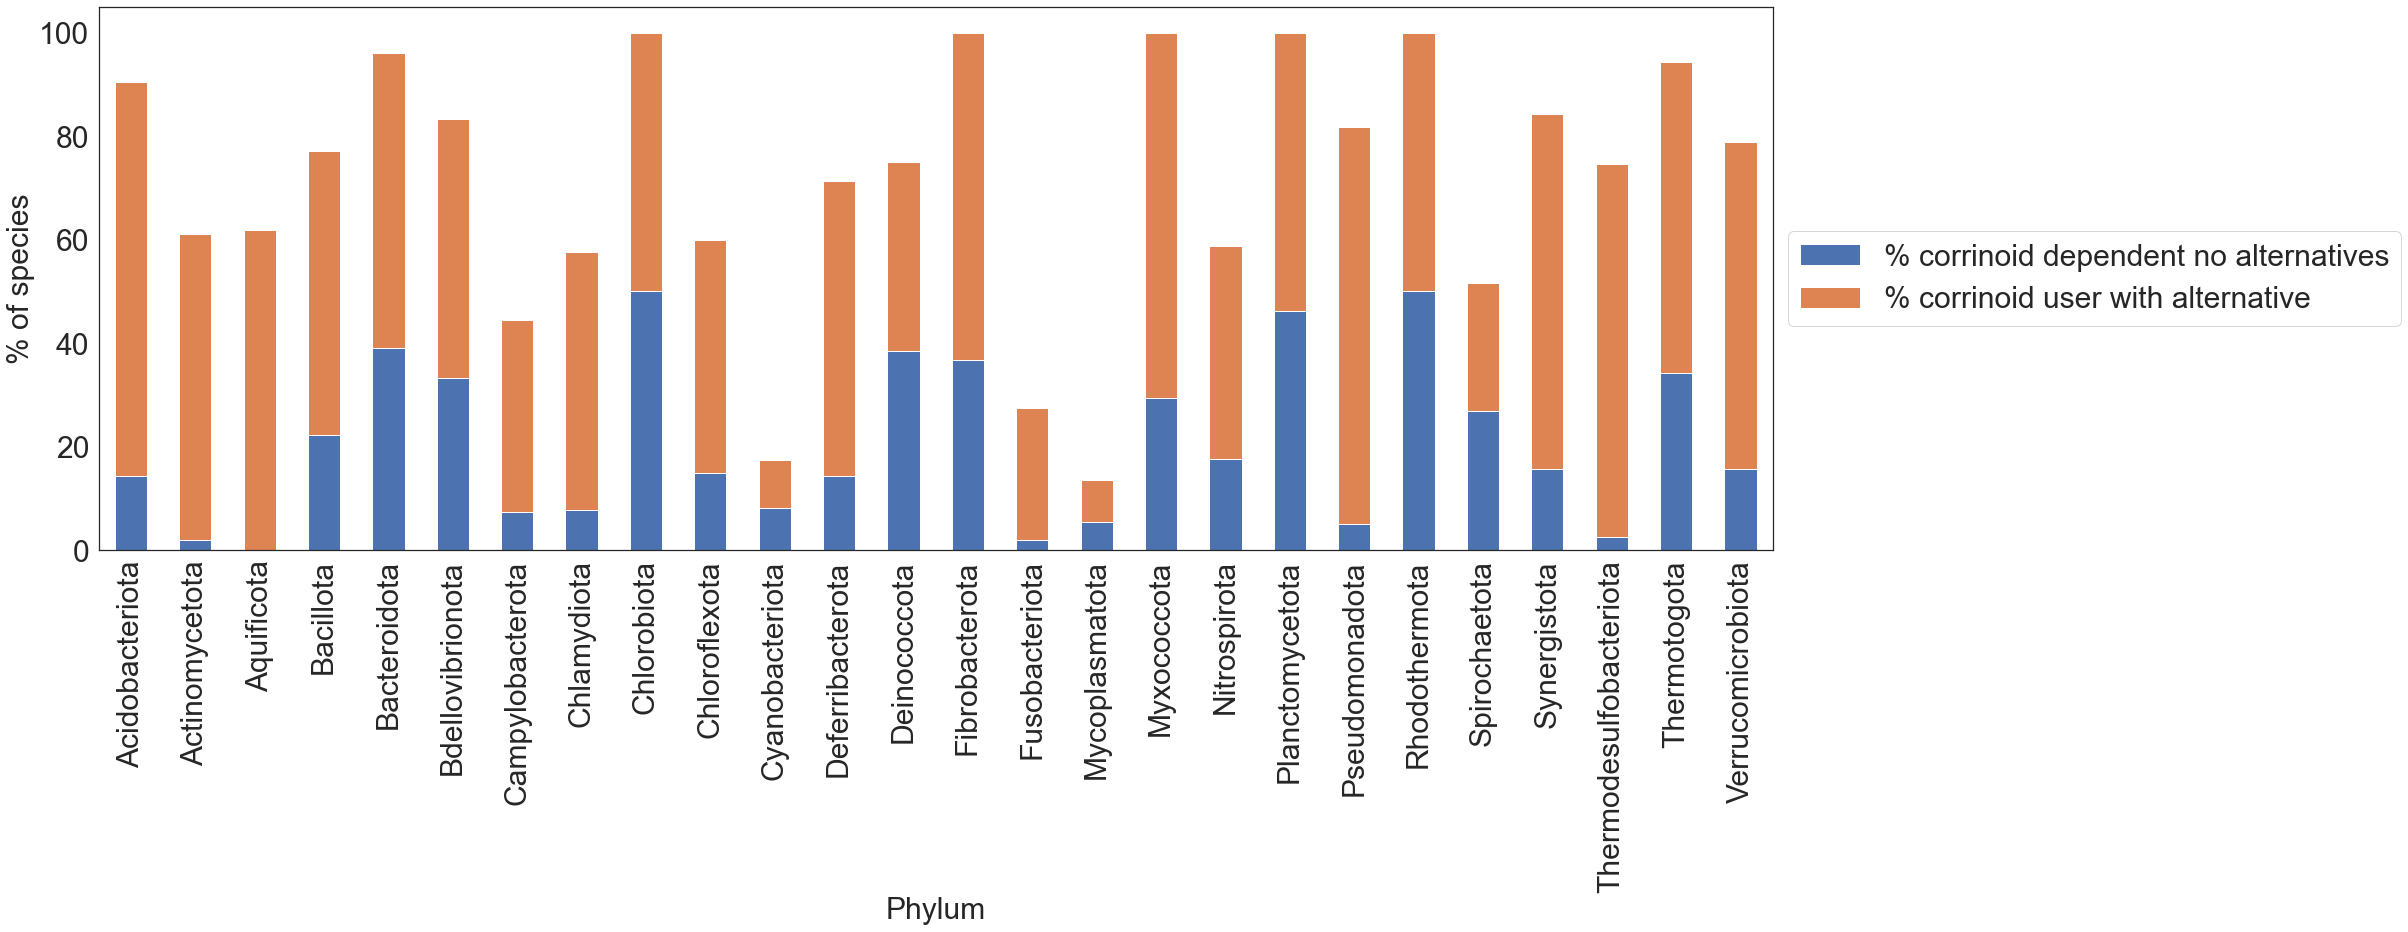

In [99]:
df_phylum[['% corrinoid dependent no alternatives',
           '% corrinoid user with alternative',
              ]].plot.bar(stacked=True, figsize=(30,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 30)
plt.tick_params(labelsize = 30)
plt.ylabel('% of species', size=30)
plt.xlabel('Phylum',size=30)


Text(0.5, 0, 'Phylum')

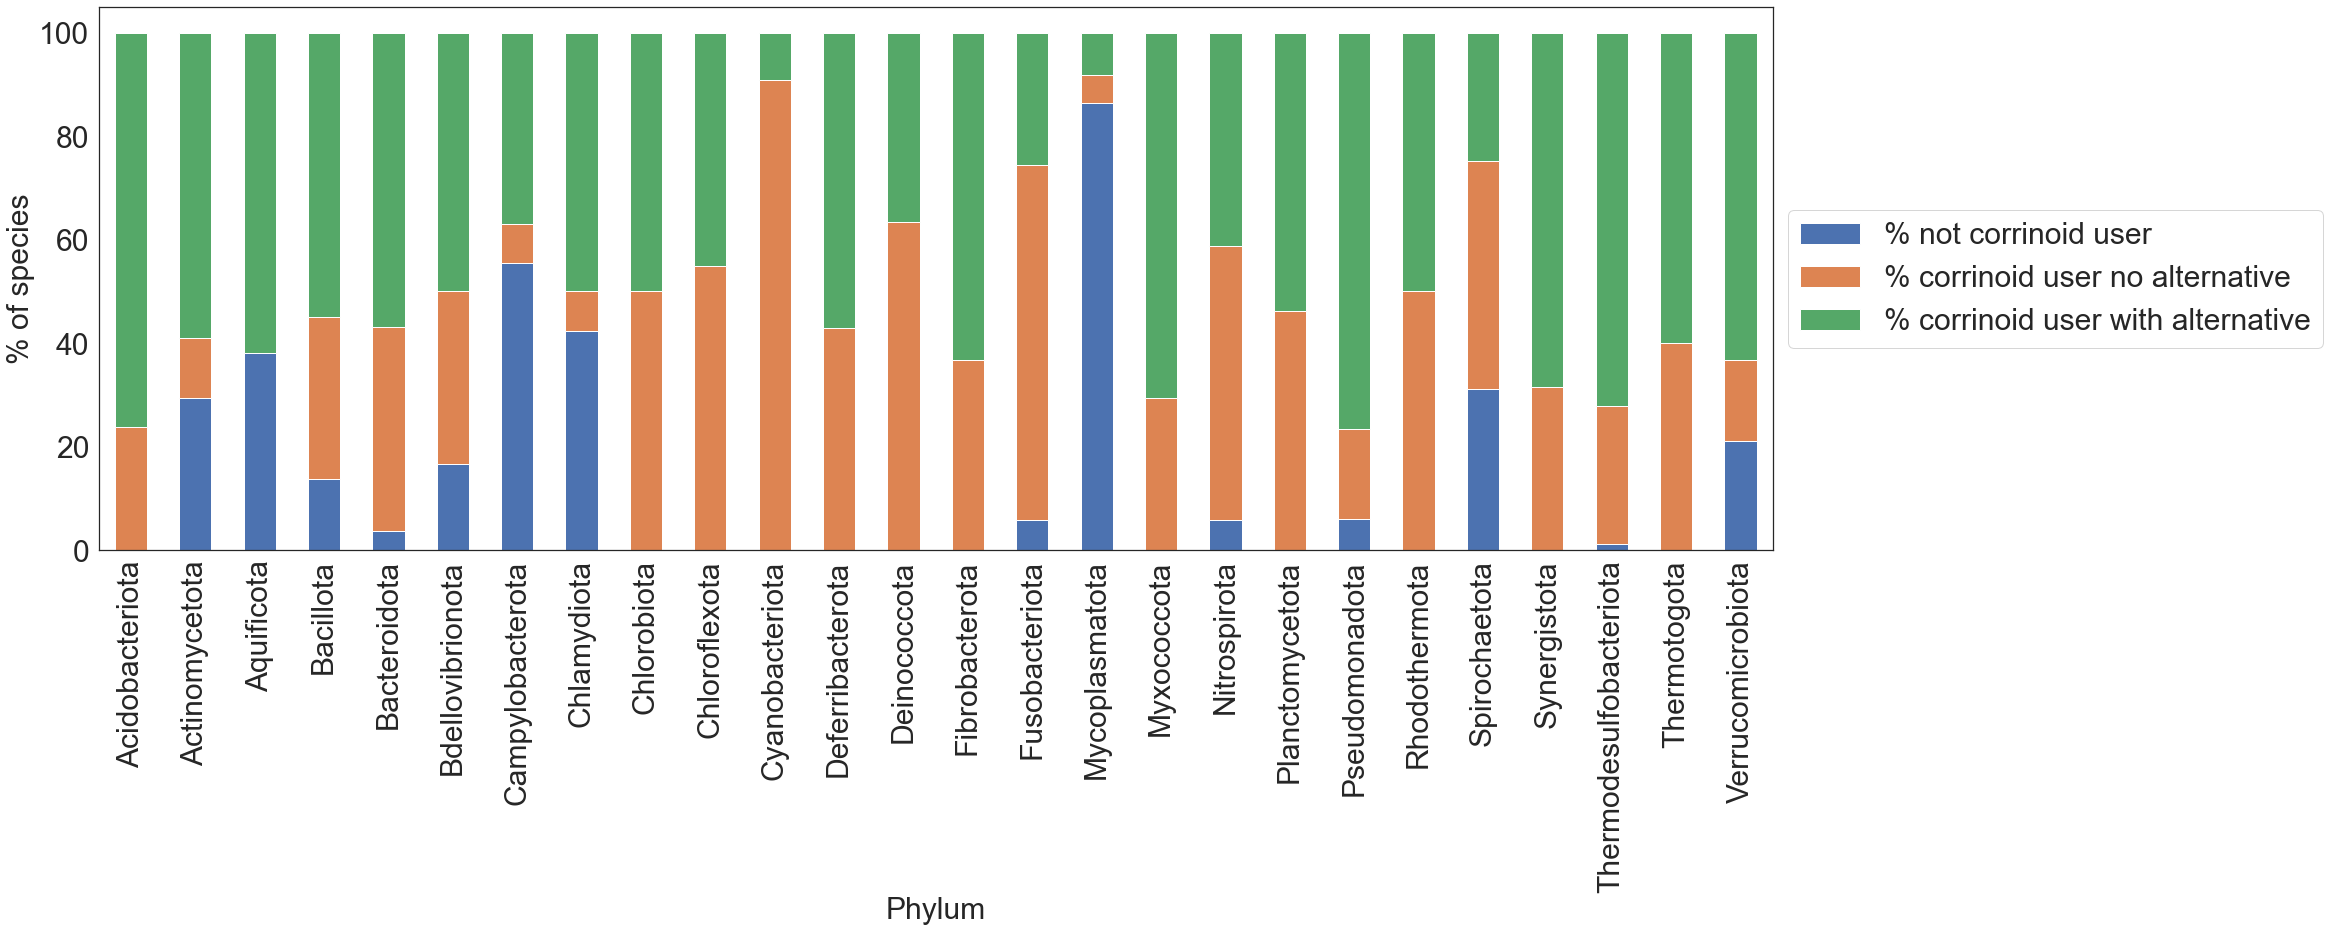

In [100]:
# I like this one <3 
df_phylum[['% not corrinoid user',
           '% corrinoid user no alternative',
           '% corrinoid user with alternative',
              ]].plot.bar(stacked=True, figsize=(30,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 30)
plt.tick_params(labelsize = 30)
plt.ylabel('% of species', size=30)
plt.xlabel('Phylum',size=30)

Text(0.5, 0, 'Phylum')

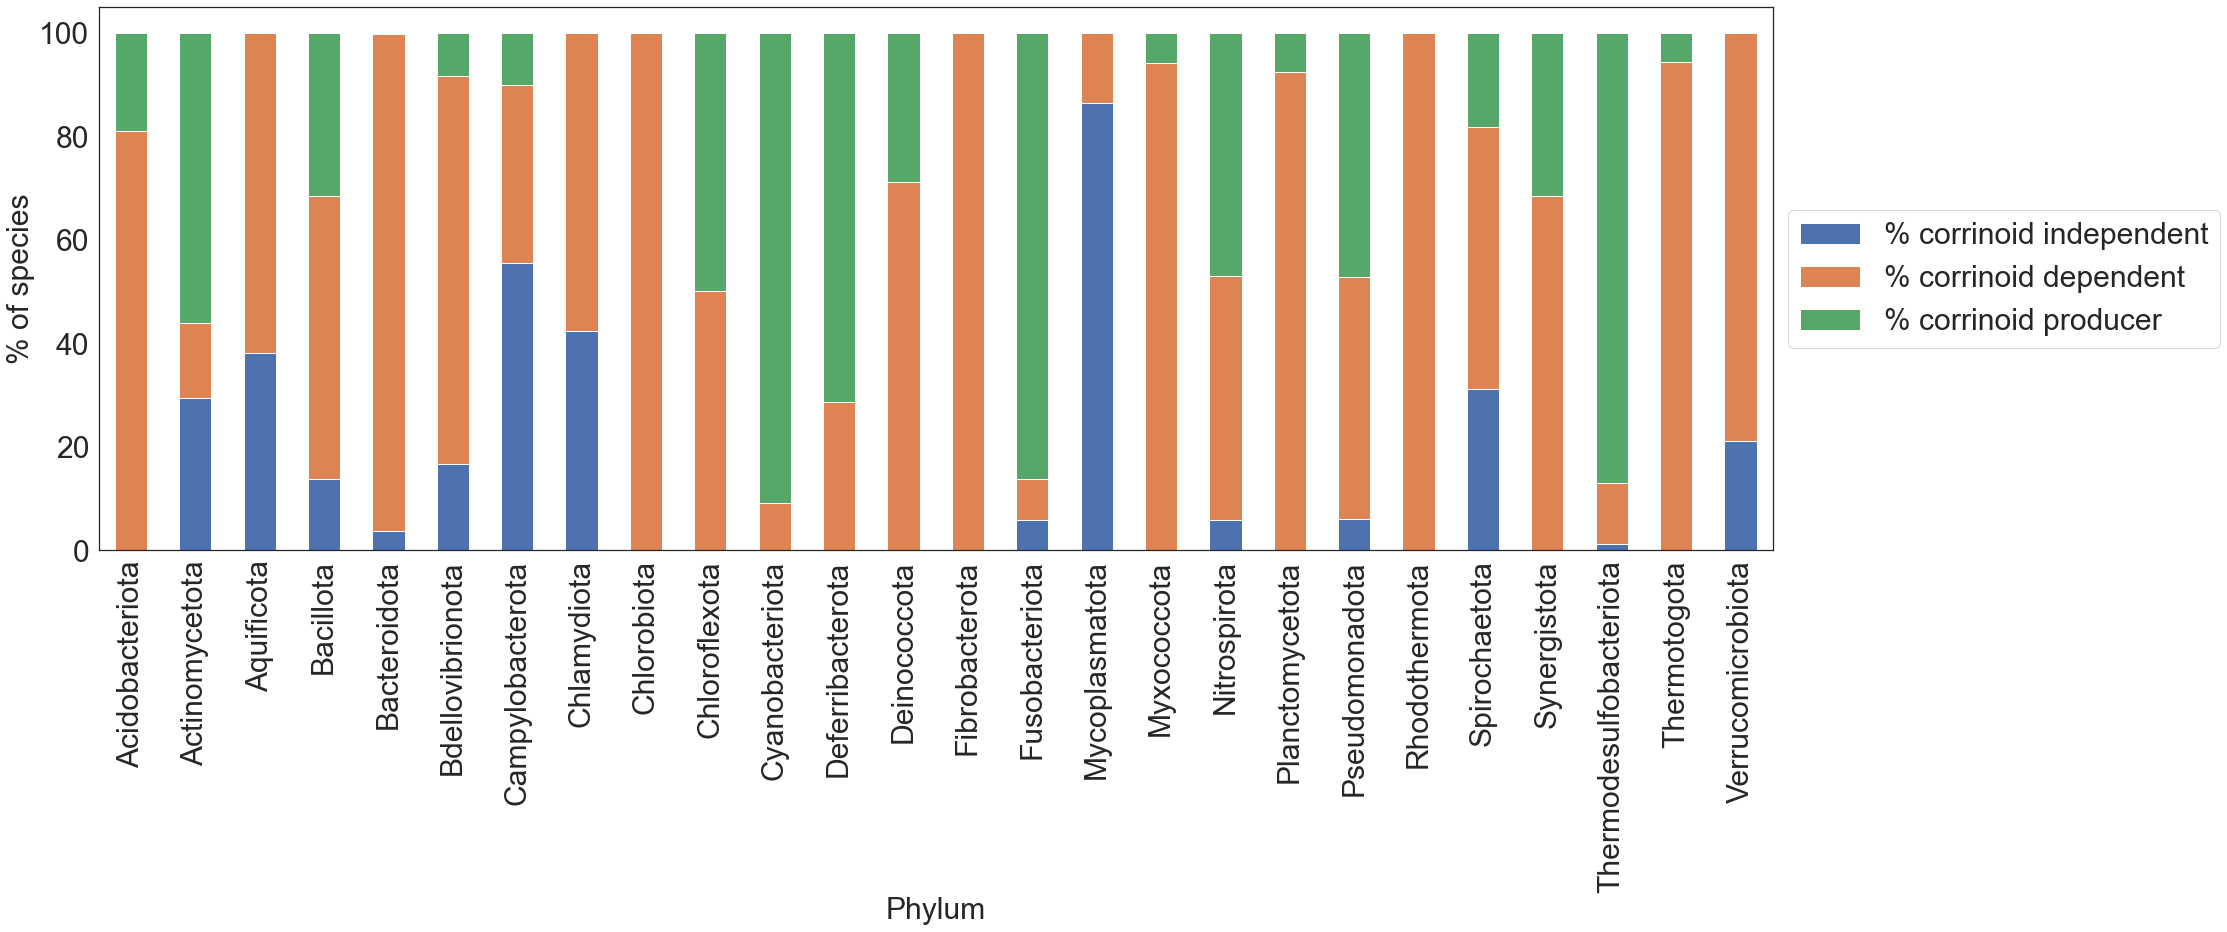

In [101]:
df_phylum[['% corrinoid independent',
           '% corrinoid dependent',
           '% corrinoid producer'
              ]].plot.bar(stacked=True, figsize=(30,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 30)
plt.tick_params(labelsize = 30)
plt.ylabel('% of species', size=30)
plt.xlabel('Phylum',size=30)

## 10.2 Genus level test figures
These were iterations before the heatmap and did not work. 

In [102]:
# sns.set_style('white')
sns.set(font_scale =2, style = 'white')


In [103]:
df_gp_plot = df_gp.reset_index()
df_gp_plot['total # of genera in phylum'] = df_gp_plot.groupby(['Phylum'])['Genus'].transform('count')
df_gp_plot = df_gp_plot.sort_values(by=['total # of genera in phylum','Genus'],ascending=[False,True])

# df_gp_plot

In [106]:
df_gp_test = df_gp_plot[['Phylum','Genus','total # of genera in phylum', 'total # of species', '% corrinoid producer', '% corrinoid dependent', '% corrinoid independent']]
df_gp_test = df_gp_test.melt(id_vars=['Phylum','Genus','total # of genera in phylum', 'total # of species'], value_vars=['% corrinoid producer','% corrinoid dependent','% corrinoid independent'],
                value_name='% species in genus',var_name = 'Category')
# df_gp_test

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'Pseudomonadota'),
  Text(1, 0, 'Bacillota'),
  Text(2, 0, 'Actinomycetota'),
  Text(3, 0, 'Bacteroidota'),
  Text(4, 0, 'Thermodesulfobacteriota'),
  Text(5, 0, 'Cyanobacteriota'),
  Text(6, 0, 'Campylobacterota'),
  Text(7, 0, 'Planctomycetota'),
  Text(8, 0, 'Acidobacteriota'),
  Text(9, 0, 'Mycoplasmatota'),
  Text(10, 0, 'Spirochaetota'),
  Text(11, 0, 'Chloroflexota'),
  Text(12, 0, 'Synergistota'),
  Text(13, 0, 'Thermotogota'),
  Text(14, 0, 'Fusobacteriota'),
  Text(15, 0, 'Verrucomicrobiota'),
  Text(16, 0, 'Aquificota'),
  Text(17, 0, 'Myxococcota'),
  Text(18, 0, 'Chlamydiota'),
  Text(19, 0, 'Deinococcota'),
  Text(20, 0, 'Bdellovibrionota'),
  Text(21, 0, 'Chlorobiota'),
  Text(22, 0, 'Nitrospirota'),
  Text(23, 0, 'Fibrobacterota')])

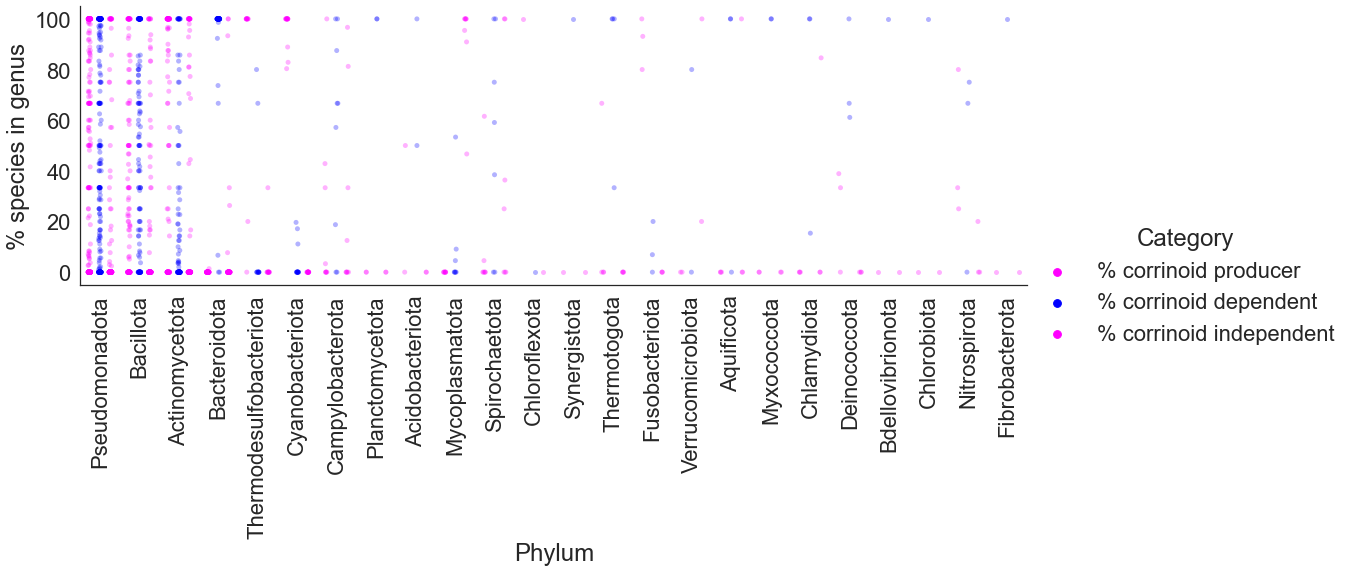

In [105]:
# plot only genera with more than 3 species
df_gp_test = df_gp_test[df_gp_test['total # of species']>=3]
df_gp_test = df_gp_test[df_gp_test['total # of genera in phylum']>=3]


strip = sns.catplot(data = df_gp_test,
                    x = 'Phylum',
                    y = '% species in genus',
                    hue = 'Category',
                    alpha = 0.3,
                    height = 5,
                    aspect=3, 
                   dodge = True,
                   kind = 'strip',
                   palette = ['magenta','blue'],
                   )

plt.xticks(rotation=90)
# plt.savefig('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/phyla_overview_230527_1.png',dpi=300,bbox_inches="tight")
# plt.savefig('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/phyla_overview_230527_1.svg',bbox_inches="tight")


<AxesSubplot:label='f2c3dad1-4f28-4f8c-b793-f8e605577c96', xlabel='Phylum', ylabel='% corrinoid producer'>

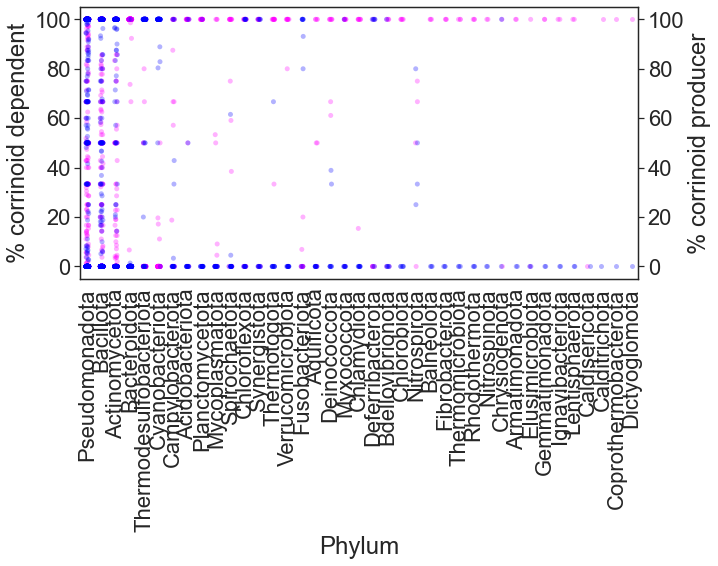

In [109]:
# sns.lineplot(data=df.column1, color="g")
# ax2 = plt.twinx()
# sns.lineplot(data=df.column2, color="b", ax=ax2)


fig, ax = plt.subplots(figsize=(10,5))  
sns.stripplot(data = df_gp_plot,
              x = 'Phylum',
              y = '% corrinoid dependent',
              color = 'magenta',
              size = 5,
             alpha = 0.3)
plt.xticks(rotation=90)

ax2 = plt.twinx()

sns.stripplot(data = df_gp_plot,
              x = 'Phylum',
              y = '% corrinoid producer',
              color = 'blue',
              size = 5,
             alpha = 0.3,
             ax = ax2,
             dodge=5)

# plt.legend(title = 'Number', bbox_to_anchor = (1, 1))


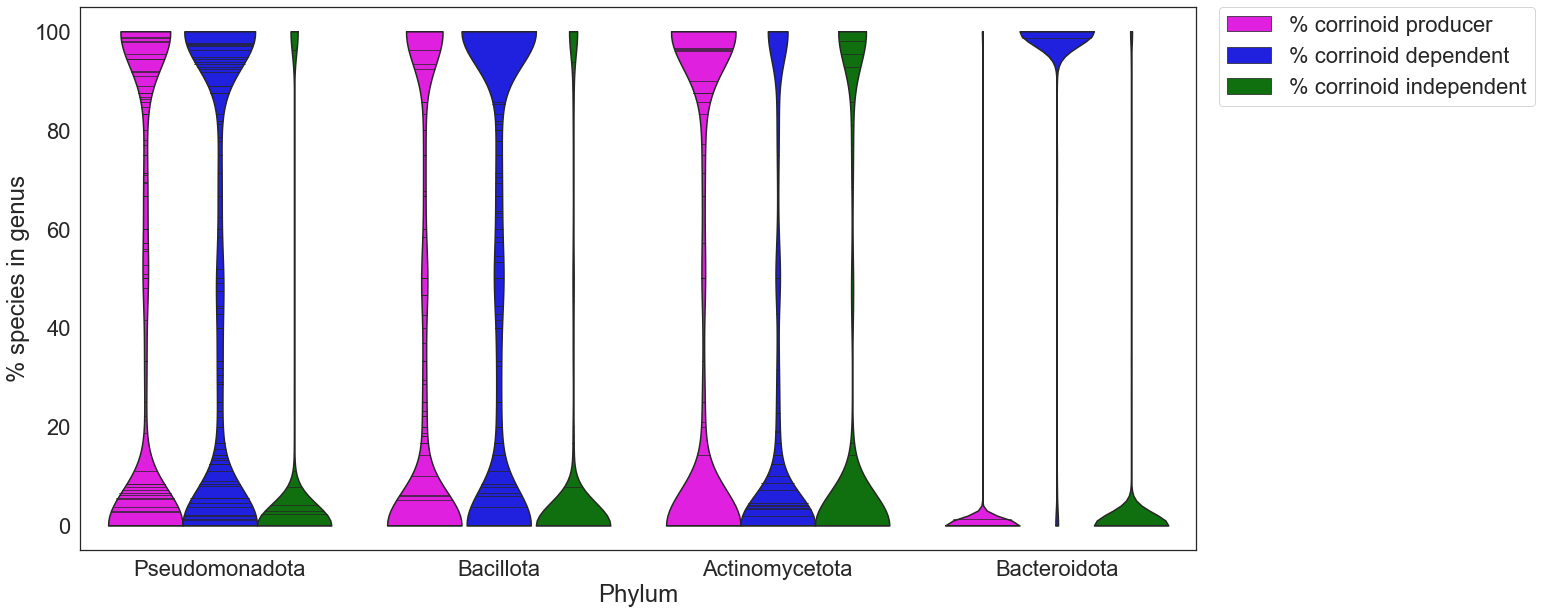

In [110]:
main_phyla = ['Pseudomonadota','Actinomycetota','Bacteroidota','Bacillota']
fig, ax = plt.subplots(figsize=(20,10)) 
sns.violinplot(data = df_gp_test[df_gp_test['Phylum'].isin(main_phyla)],
                    x = 'Phylum',
                    y = '% species in genus',
                    hue = 'Category',
                    alpha = 0.3,
                    height = 5,
                    aspect=3, 
                   dodge = True,
                   palette = ['magenta','blue','green'],
               bw=.15,
               inner = 'stick',
               scale = 'count',
               cut = 0)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# move legend
# make larger and pretty
# https://seaborn.pydata.org/generated/seaborn.violinplot.html

Text(0.5, 1.0, 'Bacteroidota')

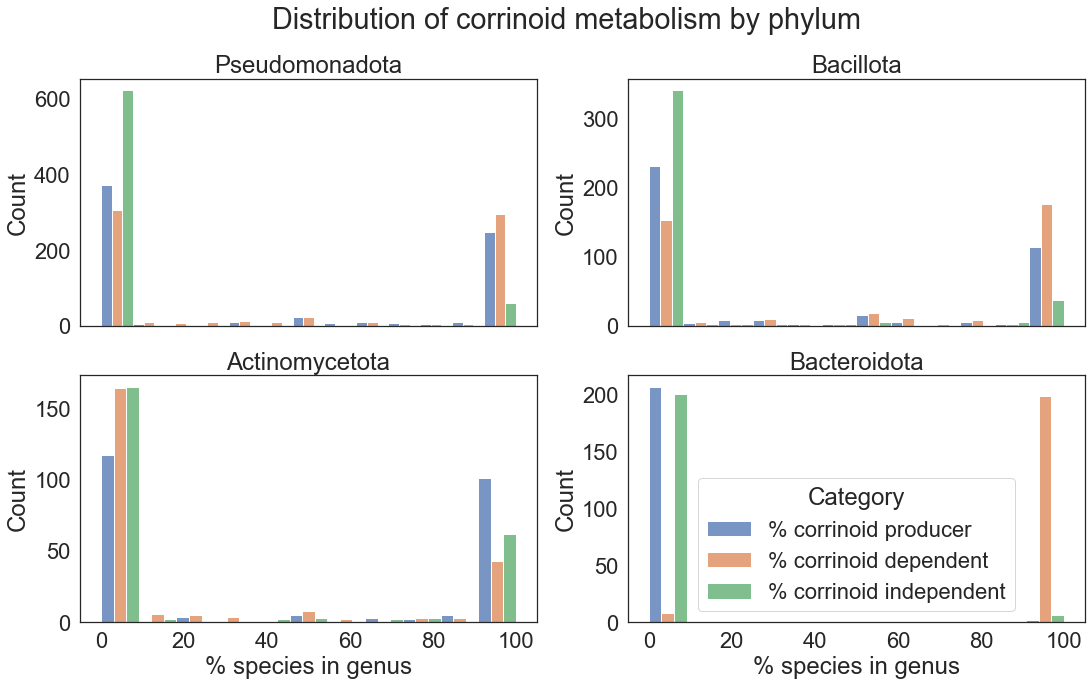

In [107]:
pseudomonadota = df_gp_test[df_gp_test['Phylum']=='Pseudomonadota']
bacillota = df_gp_test[df_gp_test['Phylum']=='Bacillota']
actinomycetota = df_gp_test[df_gp_test['Phylum']=='Actinomycetota']
bacteroidota = df_gp_test[df_gp_test['Phylum']=='Bacteroidota']
acidobacteriota = df_gp_test[df_gp_test['Phylum']=='Acidobacteriota']
verrucomicrobiota = df_gp_test[df_gp_test['Phylum']=='Verrucomicrobiota']

fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey = False, sharex = True)

fig.suptitle('Distribution of corrinoid metabolism by phylum')

sns.histplot(ax=axes[0, 0], data = pseudomonadota, x = '% species in genus', hue = 'Category',
             multiple = 'dodge', kde = False, legend = False)
axes[0,0].set_title('Pseudomonadota')

sns.histplot(ax=axes[0, 1], data = bacillota, x = '% species in genus', hue = 'Category',
             multiple = 'dodge', kde = False, legend = False)
axes[0,1].set_title('Bacillota')

sns.histplot(ax=axes[1, 0], data = actinomycetota, x = '% species in genus', hue = 'Category',
             multiple = 'dodge', kde = False, legend = False)
axes[1,0].set_title('Actinomycetota')

sns.histplot(ax=axes[1, 1], data = bacteroidota, x = '% species in genus', hue = 'Category',
             multiple = 'dodge', kde = False, legend = True )
axes[1,1].set_title('Bacteroidota')

# axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)


# sns.histplot(ax=axes[1, 1], data = acidobacteria, x = '% species in genus', hue = 'Category',
#              multiple = 'dodge', kde = False, legend = False)
# axes[1,1].set_title('Acidobacteria')

# sns.histplot(ax=axes[1,2], data = verrucomicrobia, x = '% species in genus', hue = 'Category',
#              multiple = 'dodge', kde = False, legend = False)
# axes[1,2].set_title('Verrucomicrobia')

## 10.3 Big-Phylum level figure for one of Michi's talks

In [117]:
big_phylum['% corrinoid dependent'] = big_phylum['% corrinoid user'] - big_phylum['% corrinoid producer']
# big_phylum['% corrinoid independent test'] = 100 - (big_phylum['% corrinoid user'] + big_phylum['% corrinoid producer'] + big_phylum['% corrinoid precursor salvager']) 

In [118]:
sns.set_style('white')

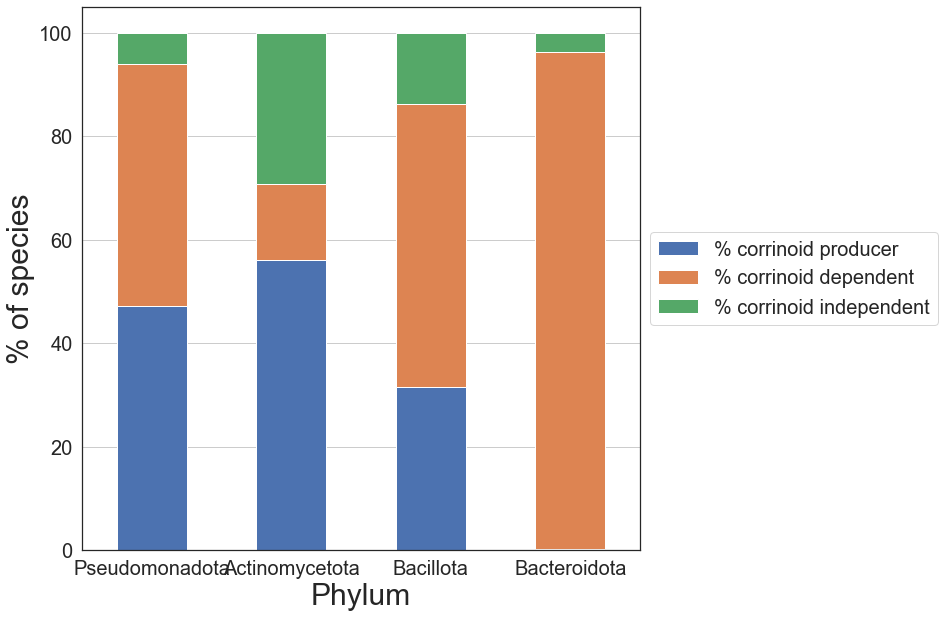

In [119]:
big_phylum[['% corrinoid producer',
            '% corrinoid dependent',
            '% corrinoid independent'
              ]].plot.bar(stacked=True, figsize=(10,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 20)
plt.tick_params(labelsize = 20)
plt.ylabel('% of species', size=30)
plt.xlabel('Phylum',size=30)
plt.xticks(rotation = 0)
plt.grid(axis='y')



(array([0, 1, 2, 3]),
 [Text(0, 0, 'Pseudomonadota'),
  Text(1, 0, 'Actinomycetota'),
  Text(2, 0, 'Bacillota'),
  Text(3, 0, 'Bacteroidota')])

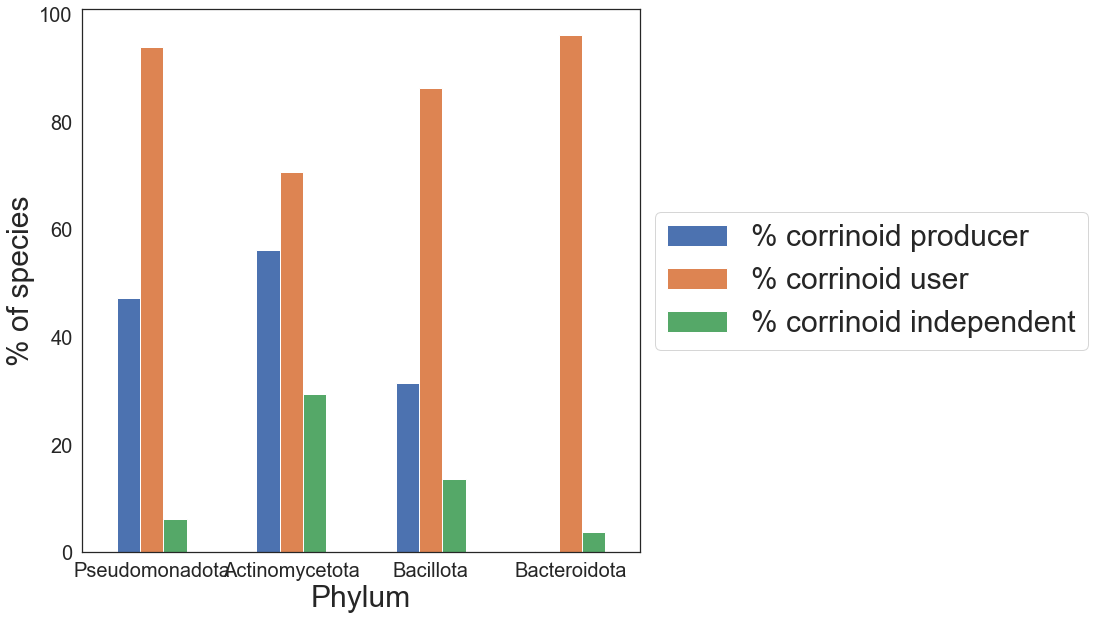

In [120]:
big_phylum[['% corrinoid producer',
            '% corrinoid user',
            '% corrinoid independent'
              ]].plot.bar(stacked=False, figsize=(10,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize = 30)
plt.tick_params(labelsize = 20)
plt.ylabel('% of species', size=30)
plt.xlabel('Phylum',size=30)
plt.xticks(rotation = 0)

## 10.4 Heatmap tests

In [126]:
filt_gp.columns

Index(['total # of species', 'cba dependent metabolism genes',
       'carbon nitrogen metabolism genes', 'one carbon metabolism genes',
       'natl product synthesis genes', 'bacteriochlorophyll synthesis genes',
       'methionine synthesis genes', 'mercury methylation genes',
       'nucleotide metabolism genes', 'reductive dehalogenation genes',
       'cba independent alternative genes',
       'independent carbon nitrogen metabolism genes',
       'independent nucleotide metabolism', 'independent methionine synthesis',
       'cba biosynthesis genes', 'aerobic biosynthesis genes',
       'anaerobic biosynthesis genes',
       'tetrapyrrole precursor biosynthesis genes',
       'corrin ring biosynthesis genes', 'aminopropanol linker genes',
       'adenosylation genes', 'nucleotide loop assembly genes',
       'core biosynthesis genes', 'corrinoid remodeling gene',
       'tetrapyrrole precursor salvager', 'Cbi salvager',
       'corrinoid precursor salvager', 'corrinoid producer

In [127]:
# Making a heatmap-ready dataframe

heatmap_gp = filt_gp.drop(['cba dependent metabolism genes',
       'carbon nitrogen metabolism genes', 'one carbon metabolism genes',
       'natl product synthesis genes', 'bacteriochlorophyll synthesis genes',
       'methionine synthesis genes', 'mercury methylation genes',
       'nucleotide metabolism genes', 'reductive dehalogenation genes',
       'cba independent alternative genes',
       'independent carbon nitrogen metabolism genes',
       'independent nucleotide metabolism', 'independent methionine synthesis',
       'cba biosynthesis genes', 'aerobic biosynthesis genes',
       'anaerobic biosynthesis genes',
       'tetrapyrrole precursor biosynthesis genes',
       'corrin ring biosynthesis genes', 'aminopropanol linker genes',
       'adenosylation genes', 'nucleotide loop assembly genes',
       'core biosynthesis genes', 'corrinoid remodeling gene',
       'tetrapyrrole precursor salvager', 'Cbi salvager',
       'corrinoid precursor salvager', 'corrinoid producer',
       'corrinoid non-producer', 'corrinoid independent', 'not corrinoid user',
       'corrinoid user', 'corrinoid user with alternative',
       'corrinoid user no alternative', 'corrinoid dependent',
       'corrinoid dependent no alternatives','call'],
    axis = 1)

<AxesSubplot:ylabel='Genus-Phylum'>

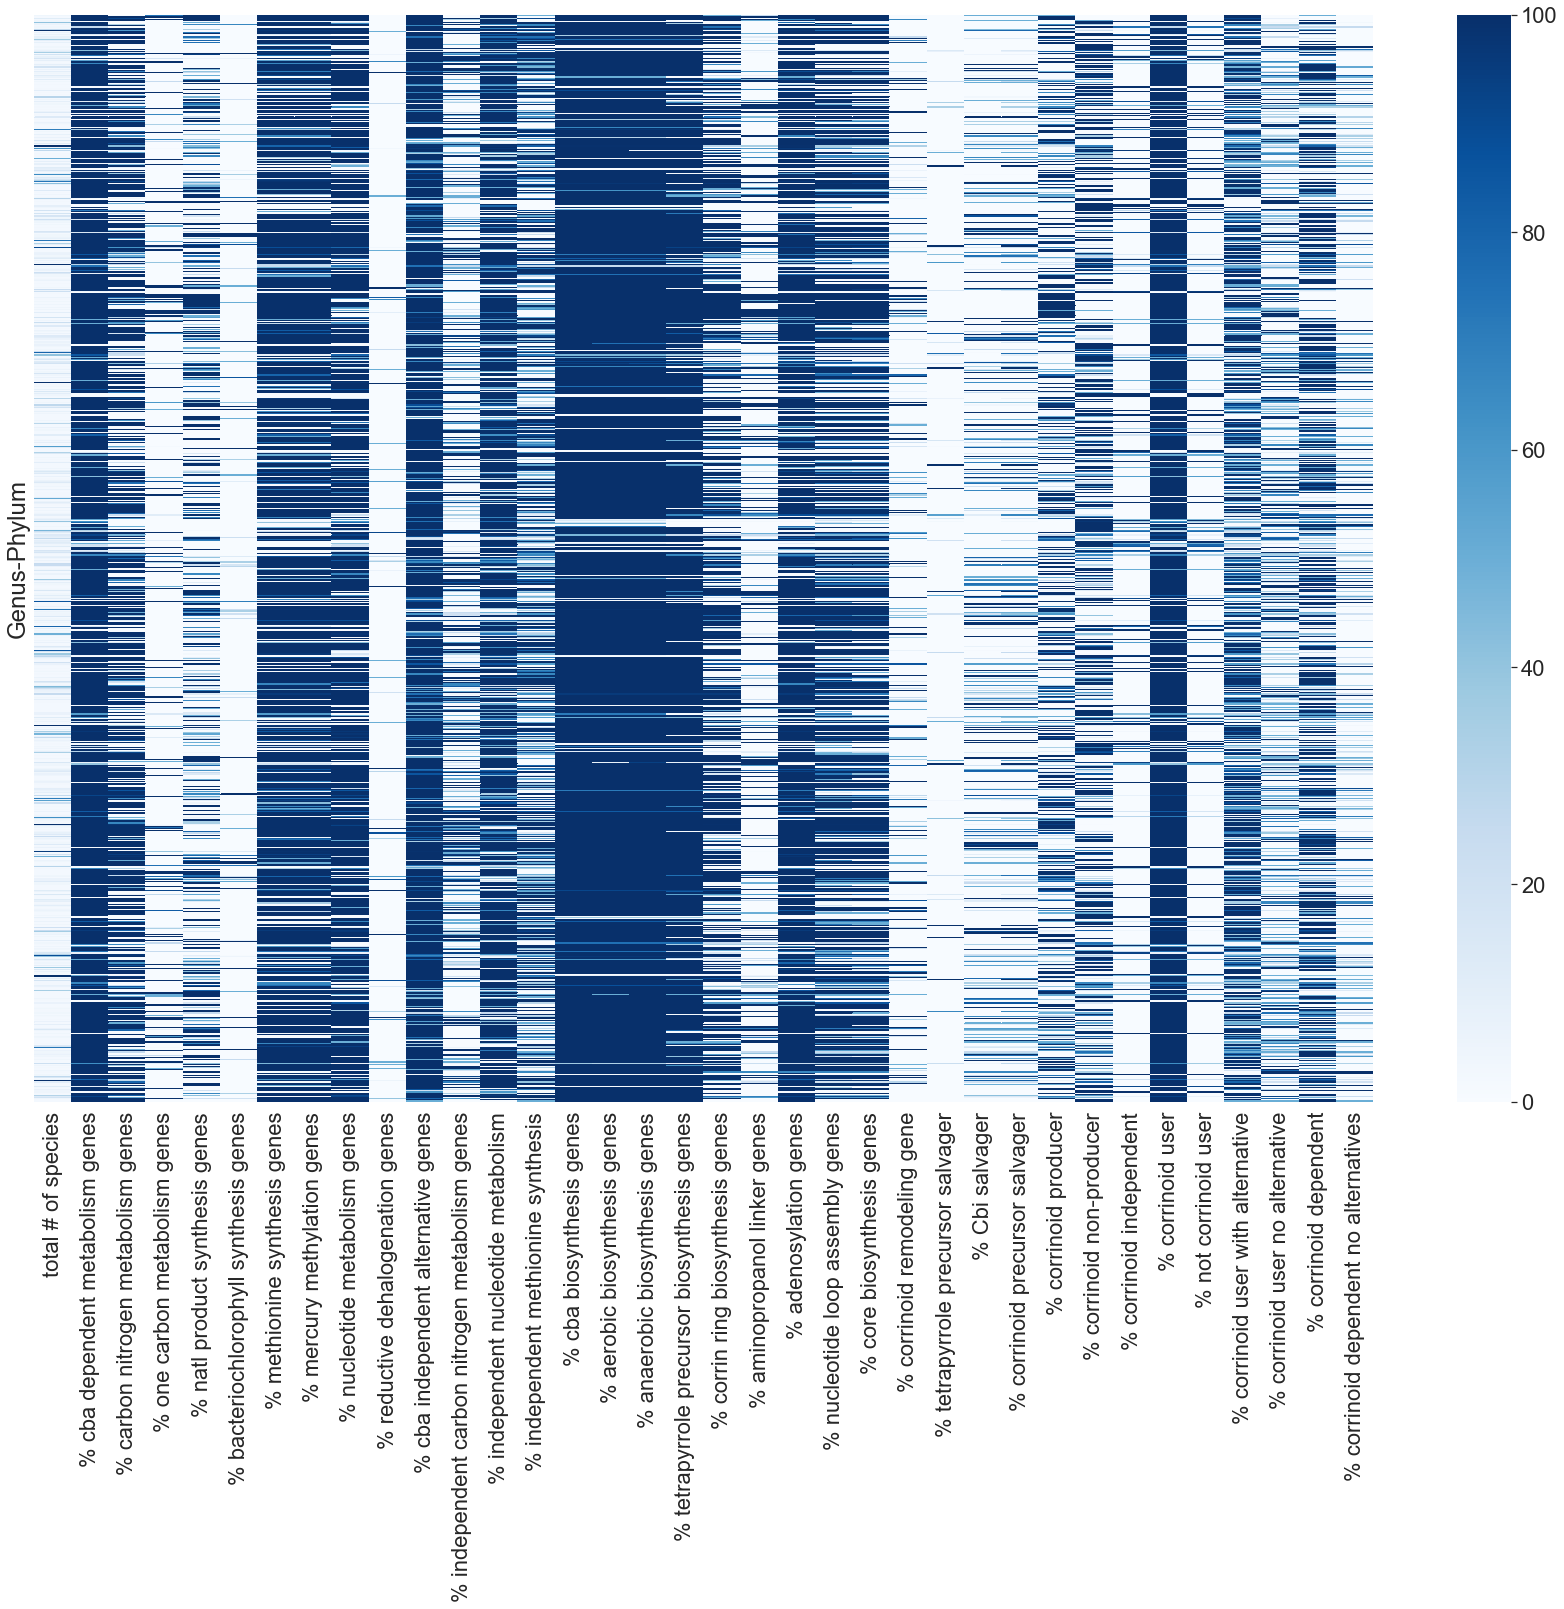

In [128]:
fig, ax = plt.subplots(figsize=(30,20))  
sns.heatmap(data=heatmap_gp,
            vmin = 0,
            vmax = 100,
            yticklabels = False,
           ax = ax,
           cmap='Blues')

In [134]:
heatmap1_gp = heatmap_gp[['% corrinoid producer',
                          '% corrinoid precursor salvager',
                          '% corrinoid independent',
                         '% not corrinoid user',
                         '% corrinoid user',
                         '% corrinoid user with alternative',
                         '% corrinoid user no alternative',
                         '% corrinoid dependent',
                         '% corrinoid dependent no alternatives']]


In [135]:
heatmap1_gp = heatmap1_gp.sort_index(level='Phylum')
heatmap1_gp

% corrinoid producer  \
Genus                  Phylum                                    
Granulicella           Acidobacteriota                    50.0   
Terriglobus            Acidobacteriota                     0.0   
Acidipropionibacterium Actinomycetota                    100.0   
Actinacidiphila        Actinomycetota                    100.0   
Actinoalloteichus      Actinomycetota                      0.0   
...                                                        ...   
Methylacidiphilum      Verrucomicrobiota                   0.0   
Opitutus               Verrucomicrobiota                   0.0   
Prosthecobacter        Verrucomicrobiota                   0.0   
Rubritalea             Verrucomicrobiota                   0.0   
Verrucomicrobium       Verrucomicrobiota                   0.0   

                                          % corrinoid precursor salvager  \
Genus                  Phylum                                              
Granulicella           Acidobacteriota                              50.0   
Terriglobus            Acidobacteriota                               0.0   
Acidipropionibacterium Actinomycetota                                0.0   
Actinacidiphila        Actinomycetota                                0.0   
Actinoalloteichus      Actinomycetota                                0.0   
...                                                                  ...   
Methylacidiphilum      Verrucomicrobiota                             0.0   
Opitutus               Verrucomicrobiota                             0.0   
Prosthecobacter        Verrucomicrobiota                             0.0   
Rubritalea             Verrucomicrobiota                             0.0   
Verrucomicrobium       Verrucomicrobiota                             0.0   

                                          % corrinoid independent  \
Genus                  Phylum                                       
Granulicella           Acidobacteriota                        0.0   
Terriglobus            Acidobacteriota                        0.0   
Acidipropionibacterium Actinomycetota                         0.0   
Actinacidiphila        Actinomycetota                         0.0   
Actinoalloteichus      Actinomycetota                         0.0   
...                                                           ...   
Methylacidiphilum      Verrucomicrobiota                    100.0   
Opitutus               Verrucomicrobiota                      0.0   
Prosthecobacter        Verrucomicrobiota                      0.0   
Rubritalea             Verrucomicrobiota                      0.0   
Verrucomicrobium       Verrucomicrobiota                     20.0   

                                          % not corrinoid user  \
Genus                  Phylum                                    
Granulicella           Acidobacteriota                     0.0   
Terriglobus            Acidobacteriota                     0.0   
Acidipropionibacterium Actinomycetota                      0.0   
Actinacidiphila        Actinomycetota                      0.0   
Actinoalloteichus      Actinomycetota                      0.0   
...                                                        ...   
Methylacidiphilum      Verrucomicrobiota                 100.0   
Opitutus               Verrucomicrobiota                   0.0   
Prosthecobacter        Verrucomicrobiota                   0.0   
Rubritalea             Verrucomicrobiota                   0.0   
Verrucomicrobium       Verrucomicrobiota                  20.0   

                                          % corrinoid user  \
Genus                  Phylum                                
Granulicella           Acidobacteriota               100.0   
Terriglobus            Acidobacteriota               100.0   
Acidipropionibacterium Actinomycetota                100.0   
Actinacidiphila        Actinomycetota                100.0   
Actinoalloteichus      Actinomycetota                100.0   
...

In [136]:
heatmap2_gp = heatmap1_gp.reset_index()
heatmap2_gp.index = heatmap2_gp['Genus']
heatmap2_gp.drop(['Genus'],axis=1,inplace=True)
heatmap2_gp

Phylum  % corrinoid producer  \
Genus                                                             
Granulicella              Acidobacteriota                  50.0   
Terriglobus               Acidobacteriota                   0.0   
Acidipropionibacterium     Actinomycetota                 100.0   
Actinacidiphila            Actinomycetota                 100.0   
Actinoalloteichus          Actinomycetota                   0.0   
...                                   ...                   ...   
Methylacidiphilum       Verrucomicrobiota                   0.0   
Opitutus                Verrucomicrobiota                   0.0   
Prosthecobacter         Verrucomicrobiota                   0.0   
Rubritalea              Verrucomicrobiota                   0.0   
Verrucomicrobium        Verrucomicrobiota                   0.0   

                        % corrinoid precursor salvager  \
Genus                                                    
Granulicella                                      50.0   
Terriglobus                                        0.0   
Acidipropionibacterium                             0.0   
Actinacidiphila                                    0.0   
Actinoalloteichus                                  0.0   
...                                                ...   
Methylacidiphilum                                  0.0   
Opitutus                                           0.0   
Prosthecobacter                                    0.0   
Rubritalea                                         0.0   
Verrucomicrobium                                   0.0   

                        % corrinoid independent  % not corrinoid user  \
Genus                                                                   
Granulicella                                0.0                   0.0   
Terriglobus                                 0.0                   0.0   
Acidipropionibacterium                      0.0                   0.0   
Actinacidiphila                             0.0                   0.0   
Actinoalloteichus                           0.0                   0.0   
...                                         ...                   ...   
Methylacidiphilum                         100.0                 100.0   
Opitutus                                    0.0                   0.0   
Prosthecobacter                             0.0                   0.0   
Rubritalea                                  0.0                   0.0   
Verrucomicrobium                           20.0                  20.0   

                        % corrinoid user  % corrinoid user with alternative  \
Genus                                                                         
Granulicella                       100.0                          50.000000   
Terriglobus                        100.0                         100.000000   
Acidipropionibacterium             100.0                          66.666667   
Actinacidiphila                    100.0                         100.000000   
Actinoalloteichus                  100.0                         100.000000   
...                                  ...                                ...   
Methylacidiphilum                    0.0                           0.000000   
Opitutus                           100.0                          50.000000   
Prosthecobacter                    100.0                          50.000000   
Rubritalea                         100.0                         100.000000   
Verrucomicrobium                    80.0                          60.000000   

                        % corrinoid user no alternative  \
Genus                                                     
Granulicella                                  50.000000   
Terriglobus                                    0.000000   
Acidipropionibacterium                        33.333333   
Actinacidiphila                                0.000000   
Actinoalloteichus                              0.000000   
...              

In [137]:
heatmap1_gp_phylum = heatmap1_gp.reset_index()
heatmap1_gp_phylum.index = heatmap1_gp_phylum['Genus']
heatmap1_gp_phylum.drop(['Genus'],axis=1,inplace=True)
# heatmap1_gp_phylum = heatmap1_gp_phylum.T
# heatmap1_gp_phylum

In [138]:
phy = heatmap1_gp_phylum.pop("Phylum")
lut = dict(zip(phy.unique(), ['#FF4136', '#FF851B', '#FFDC00', '#2ECC40', 
                                                           '#3D9970', '#39CCCC', '#0074D9', '#001f3f', 
                                                           '#7FDBFF', '#B10DC9', '#F012BE', '#85144b', 
                                                           '#FF4136', '#FF851B', '#FFDC00', '#2ECC40',
                                                           '#3D9970', '#39CCCC', '#0074D9', '#001f3f', 
                                                           '#7FDBFF', '#B10DC9', '#F012BE', '#85144b']))
row_colors = phy.map(lut)

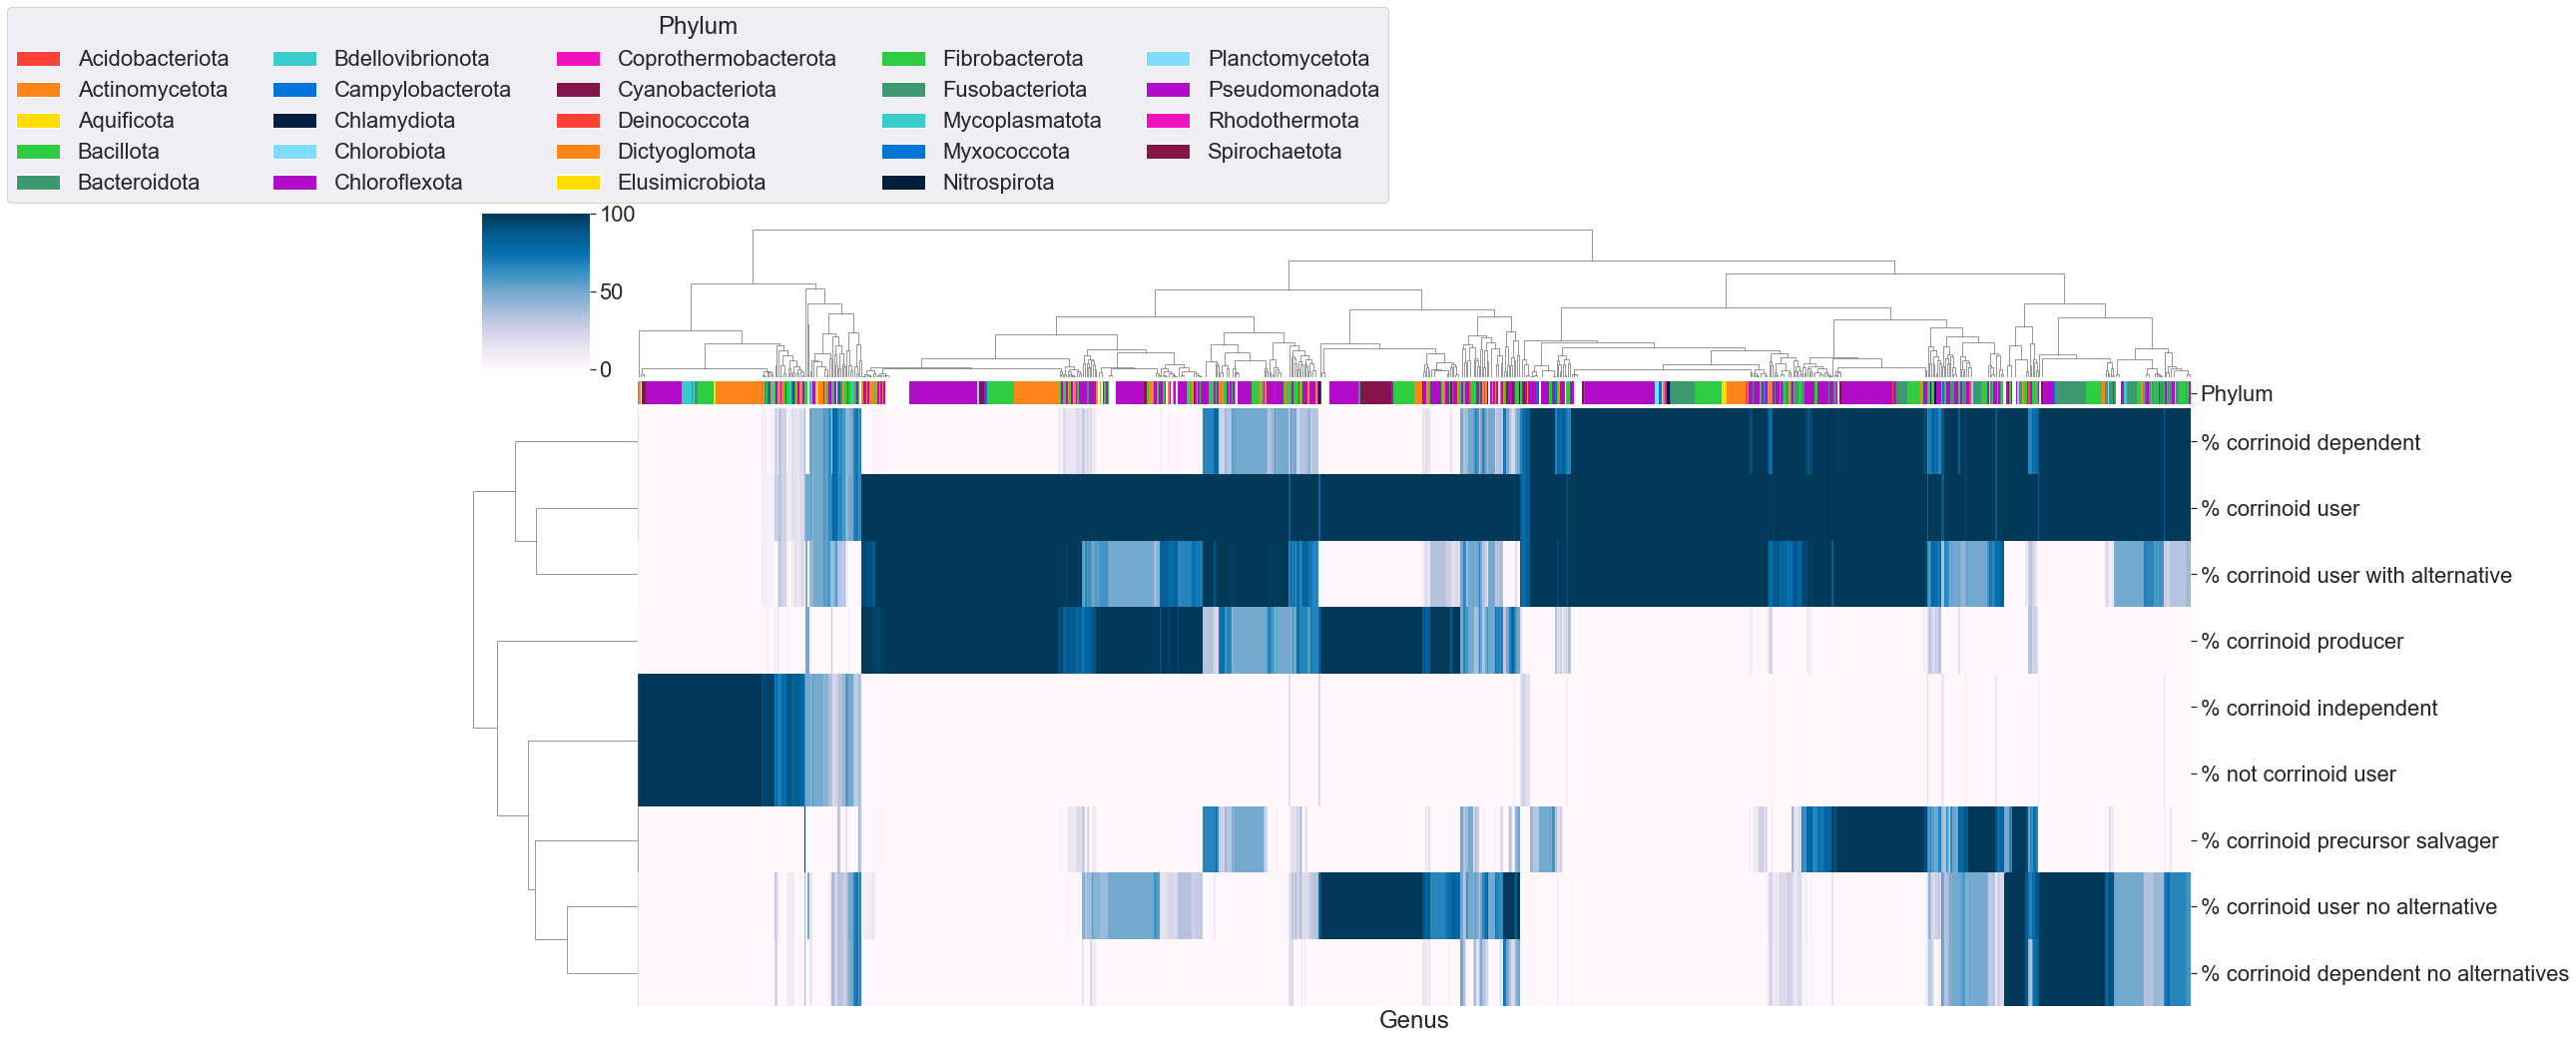

In [139]:
sns.set(font_scale=2)
sns.clustermap(data=heatmap1_gp_phylum.T,
               figsize = (30,12),
               dendrogram_ratio=(.1, .2),
               vmin = 0,
               vmax = 100,
               xticklabels = False,
               col_colors=row_colors,
              cmap = 'PuBu')

from matplotlib.patches import Patch
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Phylum', loc = 'lower center',
           bbox_to_anchor=(2, 1), ncol=5)
# plt.savefig('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/heatmap_by_phylum.png')

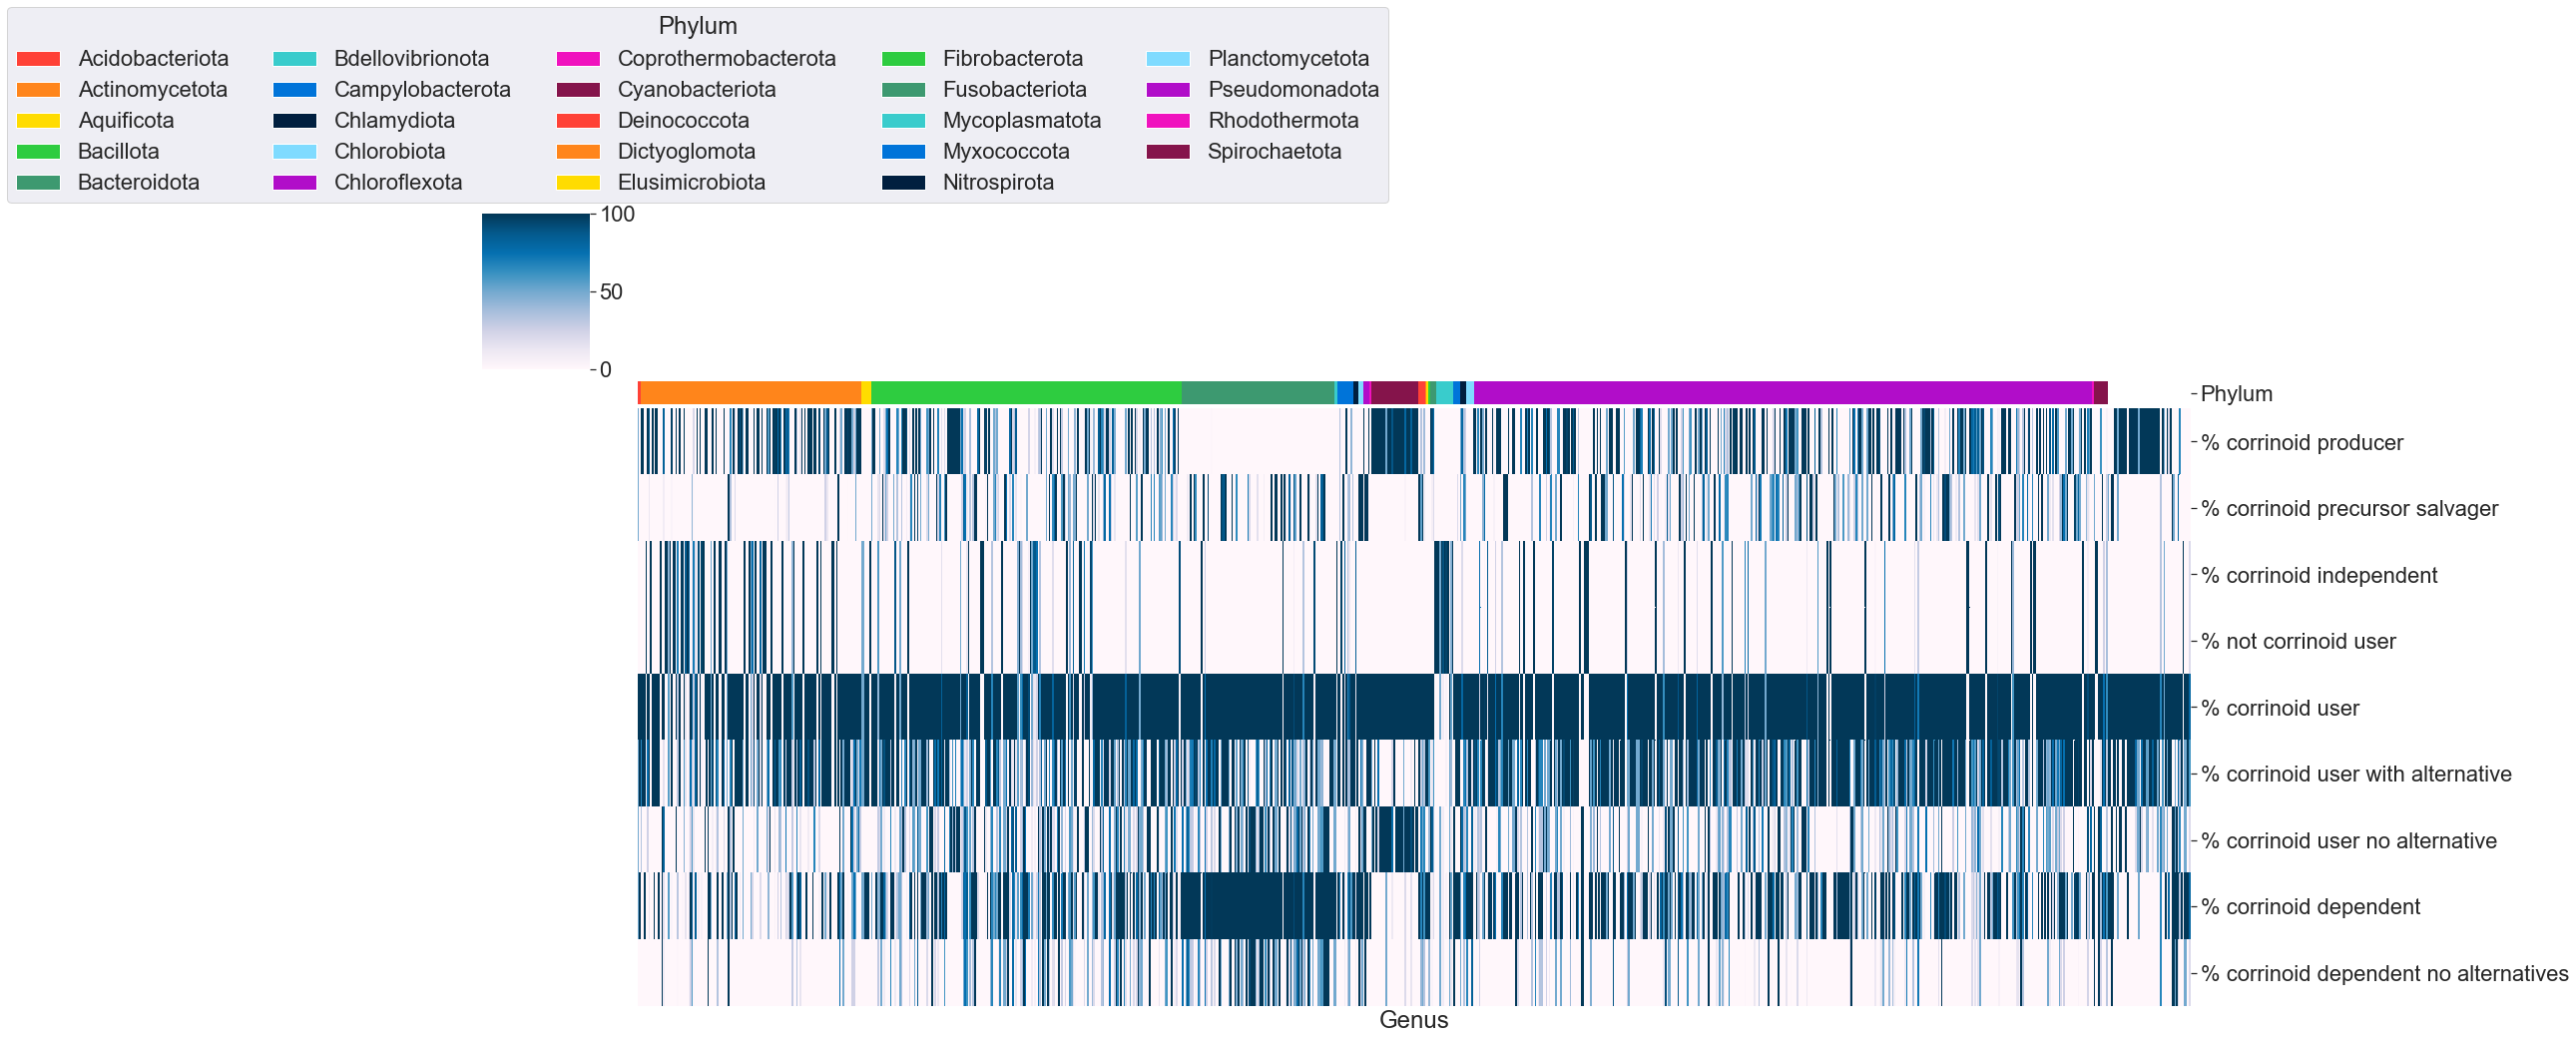

In [140]:
sns.set(font_scale=2)
sns.clustermap(data=heatmap1_gp_phylum.T,
               figsize = (30,12),
               dendrogram_ratio=(.1, .2),
               vmin = 0,
               vmax = 100,
               xticklabels = False,
               col_colors=row_colors,
               cmap = 'PuBu',
               row_cluster=False, 
               col_cluster=False,)

from matplotlib.patches import Patch
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Phylum', loc = 'lower center',
           bbox_to_anchor=(2, 1), ncol=5)
# plt.savefig('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/heatmap_by_phylum.png')

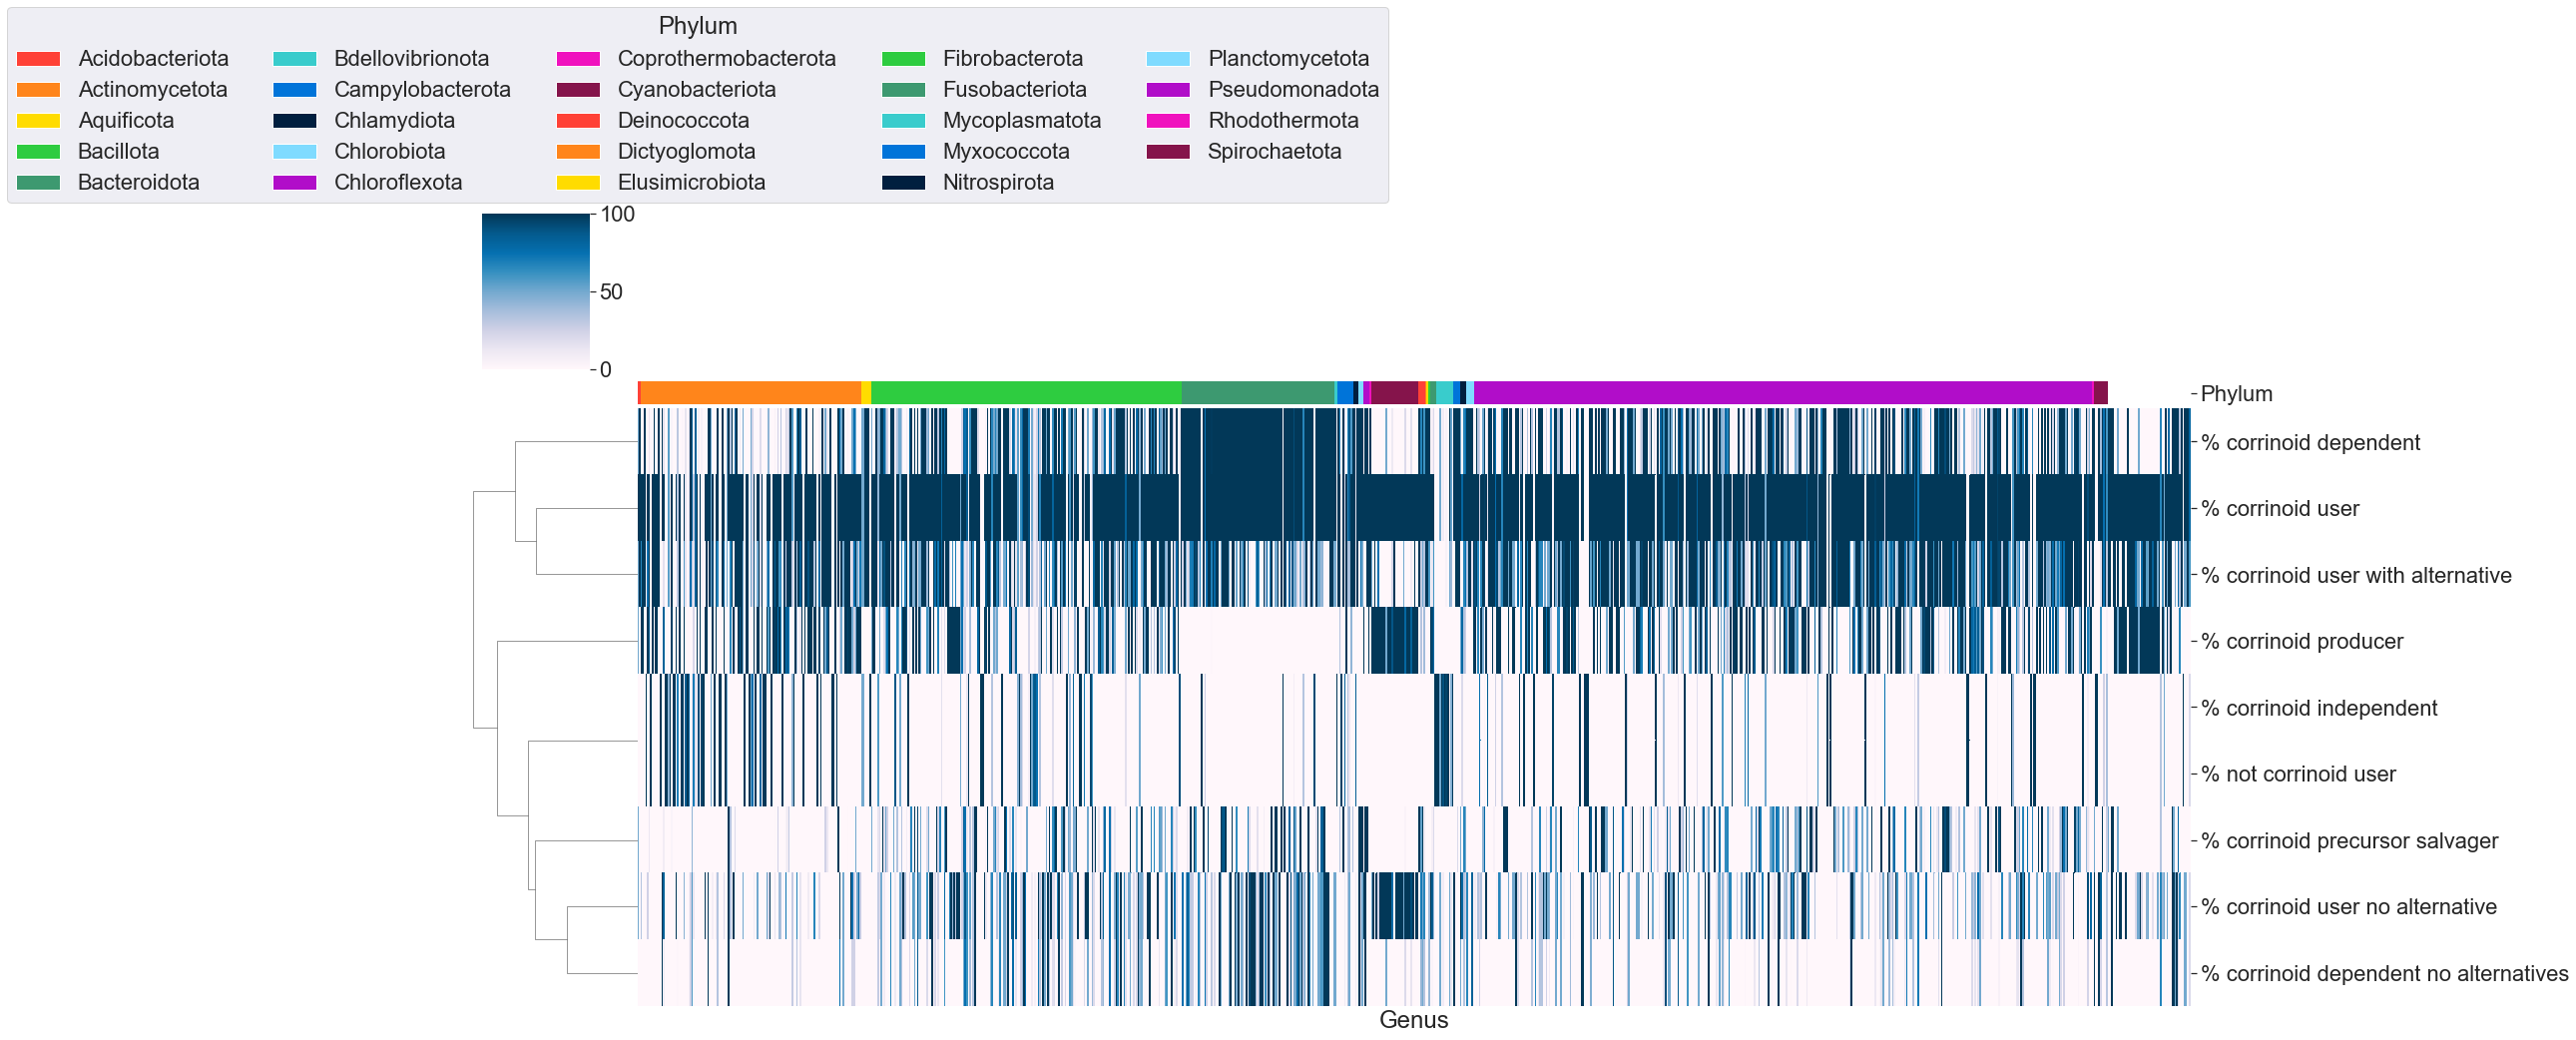

In [141]:
sns.set(font_scale=2)
sns.clustermap(data=heatmap1_gp_phylum.T,
               figsize = (30,12),
               dendrogram_ratio=(.1, .2),
               vmin = 0,
               vmax = 100,
               xticklabels = False,
               col_colors=row_colors,
               cmap = 'PuBu',
               row_cluster=True, 
               col_cluster=False,)

from matplotlib.patches import Patch
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Phylum', loc = 'lower center',
           bbox_to_anchor=(2, 1), ncol=5)
# plt.savefig('/Users/zoilaalvarez/Desktop/PhD/TAGA_LAB/16S_based_predictions/heatmap_by_phylum.png')

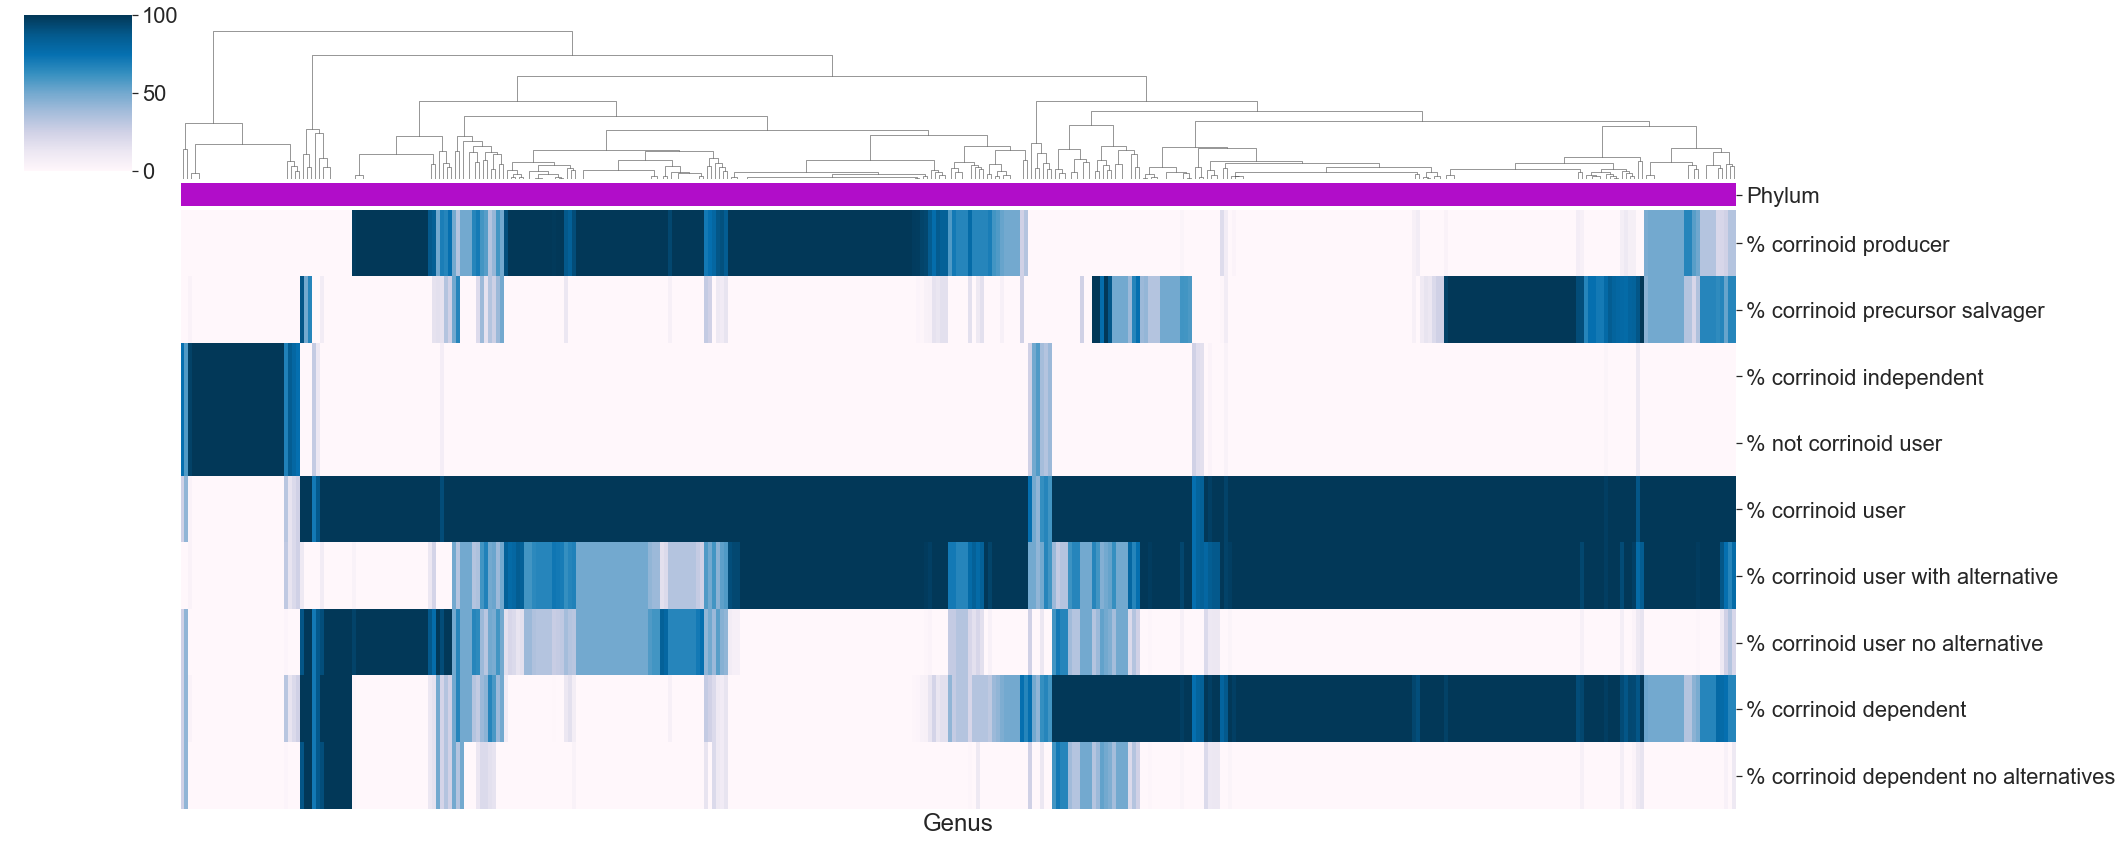

In [143]:
proteo = heatmap2_gp[heatmap2_gp['Phylum']=='Pseudomonadota']
phy = proteo.pop("Phylum")

sns.set(font_scale=2)
sns.clustermap(data=proteo.T,
               figsize = (30,12),
               dendrogram_ratio=(.1, .2),
               vmin = 0,
               vmax = 100,
               xticklabels = False,
               col_colors=row_colors,
              cmap = 'PuBu',
              row_cluster=False)

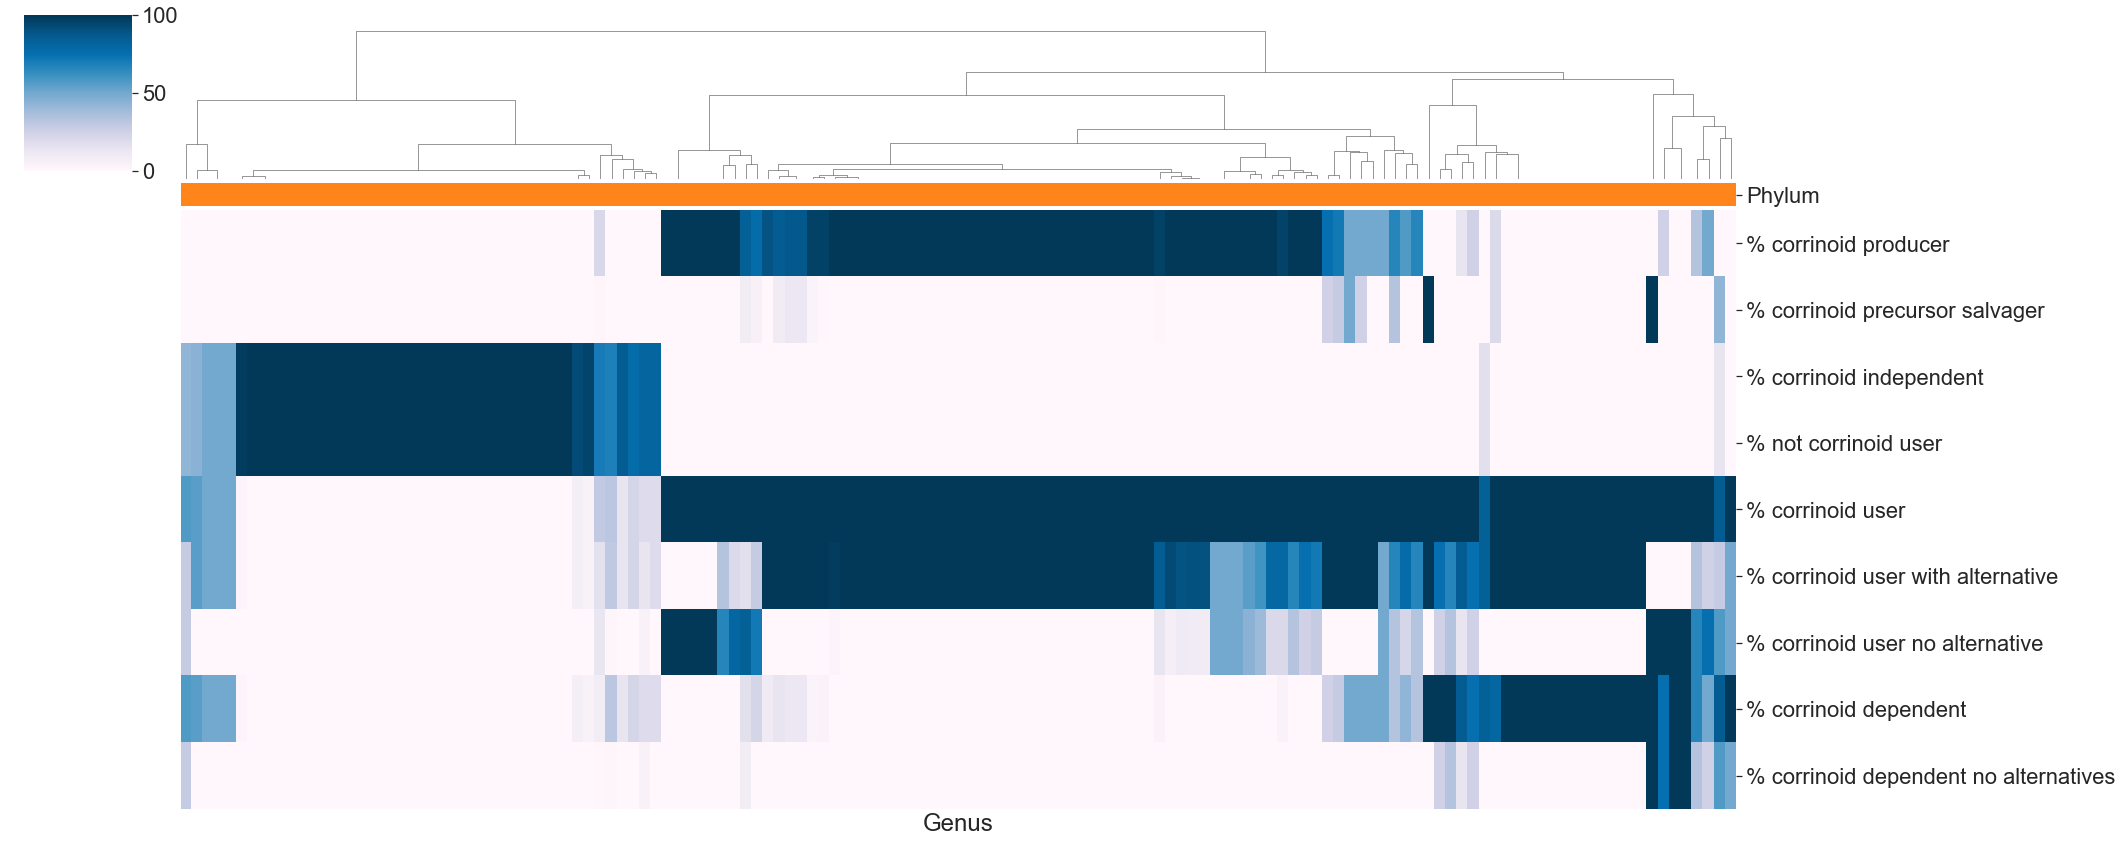

In [148]:
actino = heatmap2_gp[heatmap2_gp['Phylum']=='Actinomycetota']
phy = actino.pop("Phylum")

sns.set(font_scale=2)
sns.clustermap(data=actino.T,
               figsize = (30,12),
               dendrogram_ratio=(.1, .2),
               vmin = 0,
               vmax = 100,
               xticklabels = False,
               col_colors=row_colors,
              cmap = 'PuBu',
              row_cluster=False)

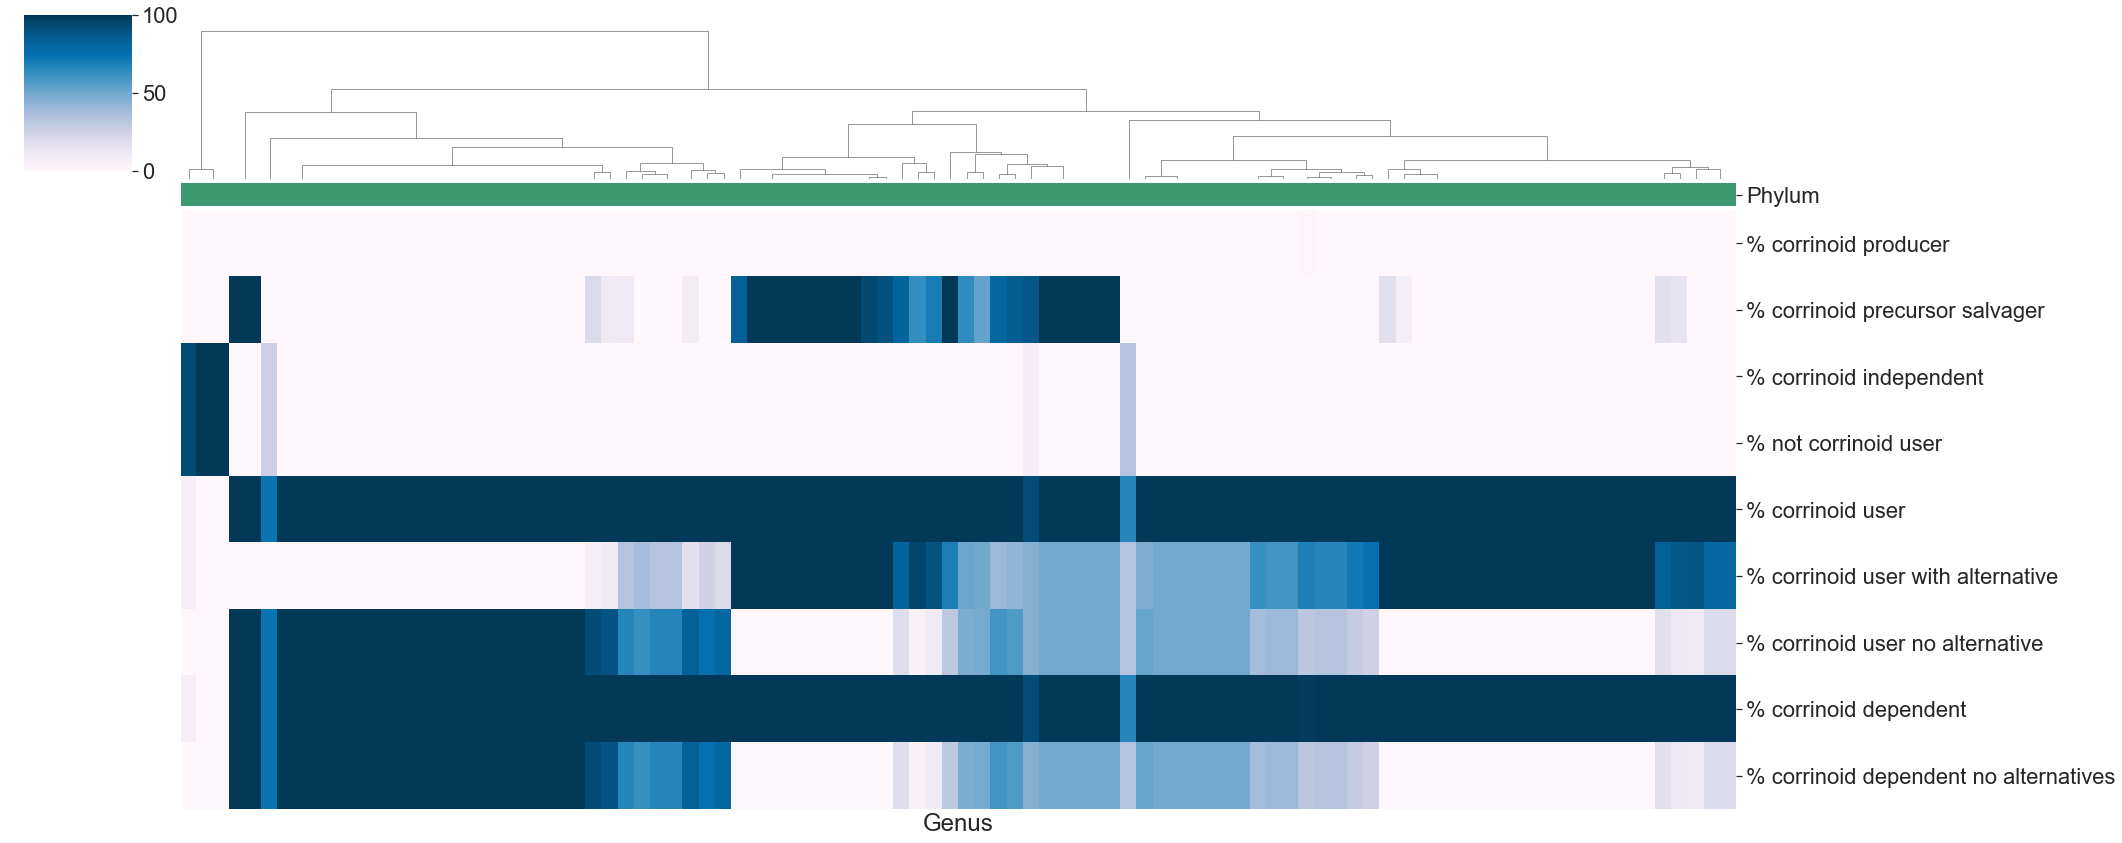

In [149]:
bact = heatmap2_gp[heatmap2_gp['Phylum']=='Bacteroidota']
phy = bact.pop("Phylum")

sns.set(font_scale=2)
sns.clustermap(data=bact.T,
               figsize = (30,12),
               dendrogram_ratio=(.1, .2),
               vmin = 0,
               vmax = 100,
               xticklabels = False,
               col_colors=row_colors,
              cmap = 'PuBu',
              row_cluster=False)

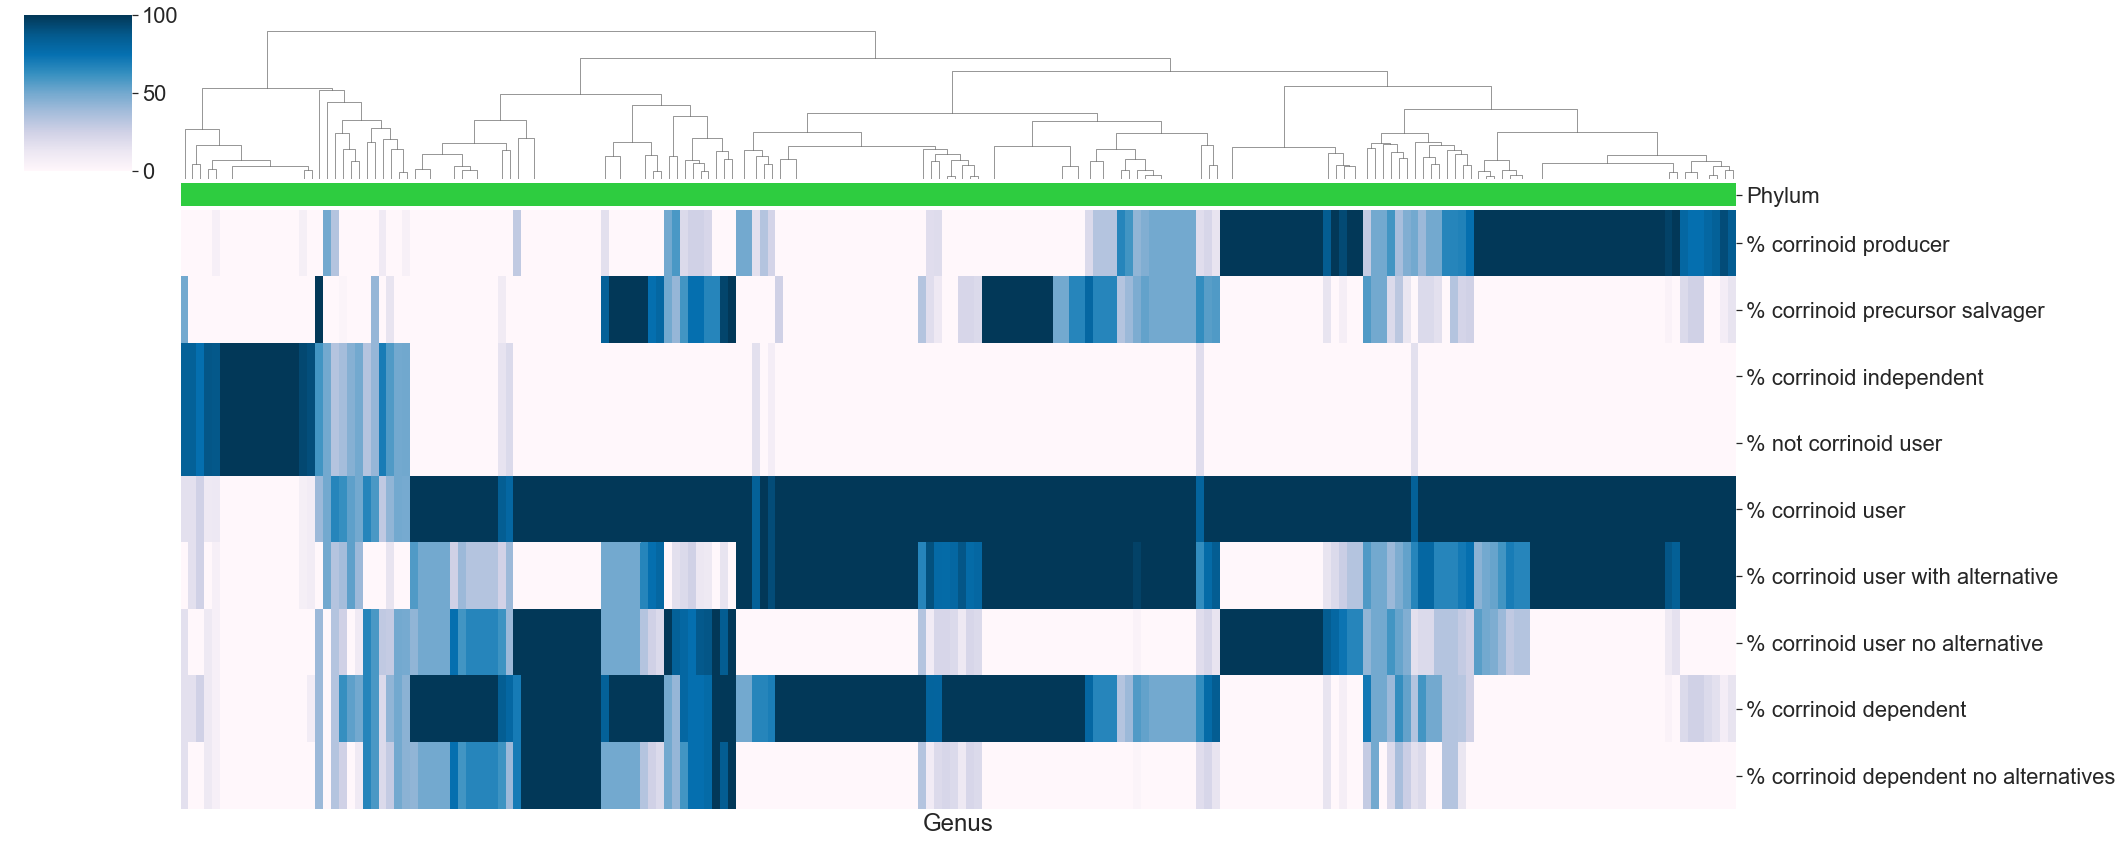

In [150]:
firmi = heatmap2_gp[heatmap2_gp['Phylum']=='Bacillota']
phy = firmi.pop("Phylum")

sns.set(font_scale=2)
sns.clustermap(data=firmi.T,
               figsize = (30,12),
               dendrogram_ratio=(.1, .2),
               vmin = 0,
               vmax = 100,
               xticklabels = False,
               col_colors=row_colors,
              cmap = 'PuBu',
              row_cluster=False)

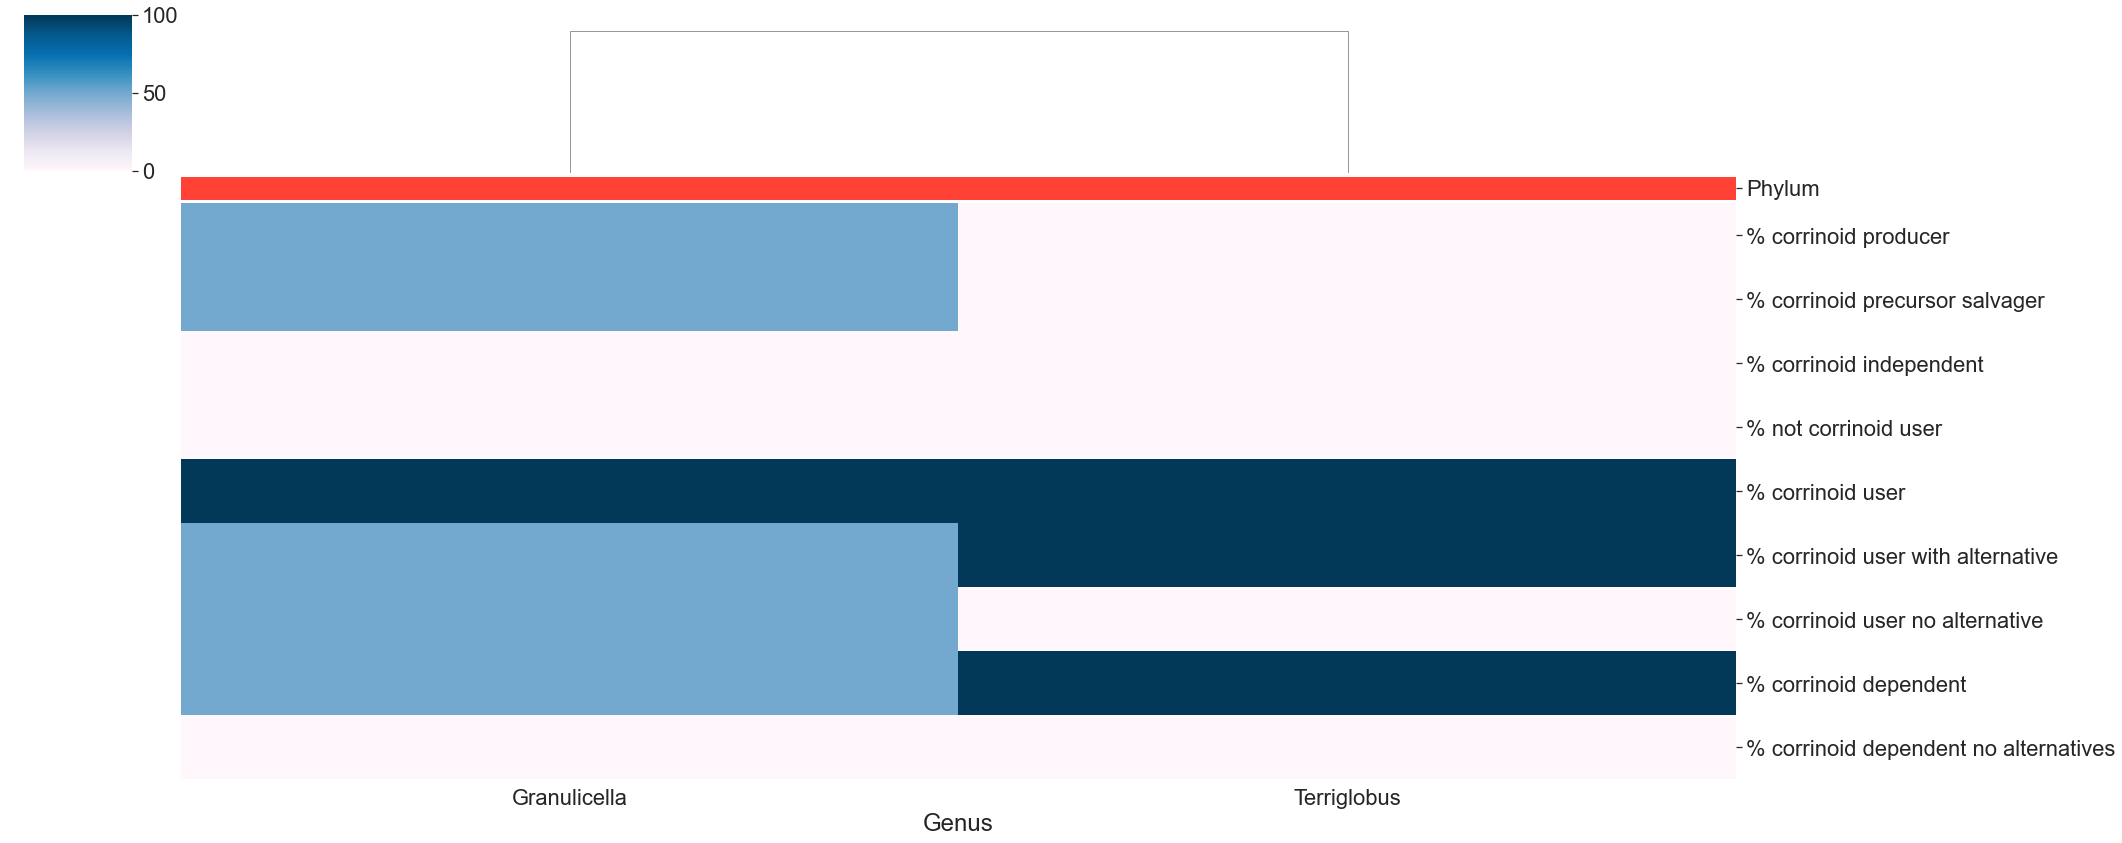

In [151]:
acido = heatmap2_gp[heatmap2_gp['Phylum']=='Acidobacteriota']
phy = acido.pop("Phylum")

sns.set(font_scale=2)
sns.clustermap(data=acido.T,
               figsize = (30,12),
               dendrogram_ratio=(.1, .2),
               vmin = 0,
               vmax = 100,
               xticklabels = True,
               col_colors=row_colors,
              cmap = 'PuBu',
              row_cluster=False)

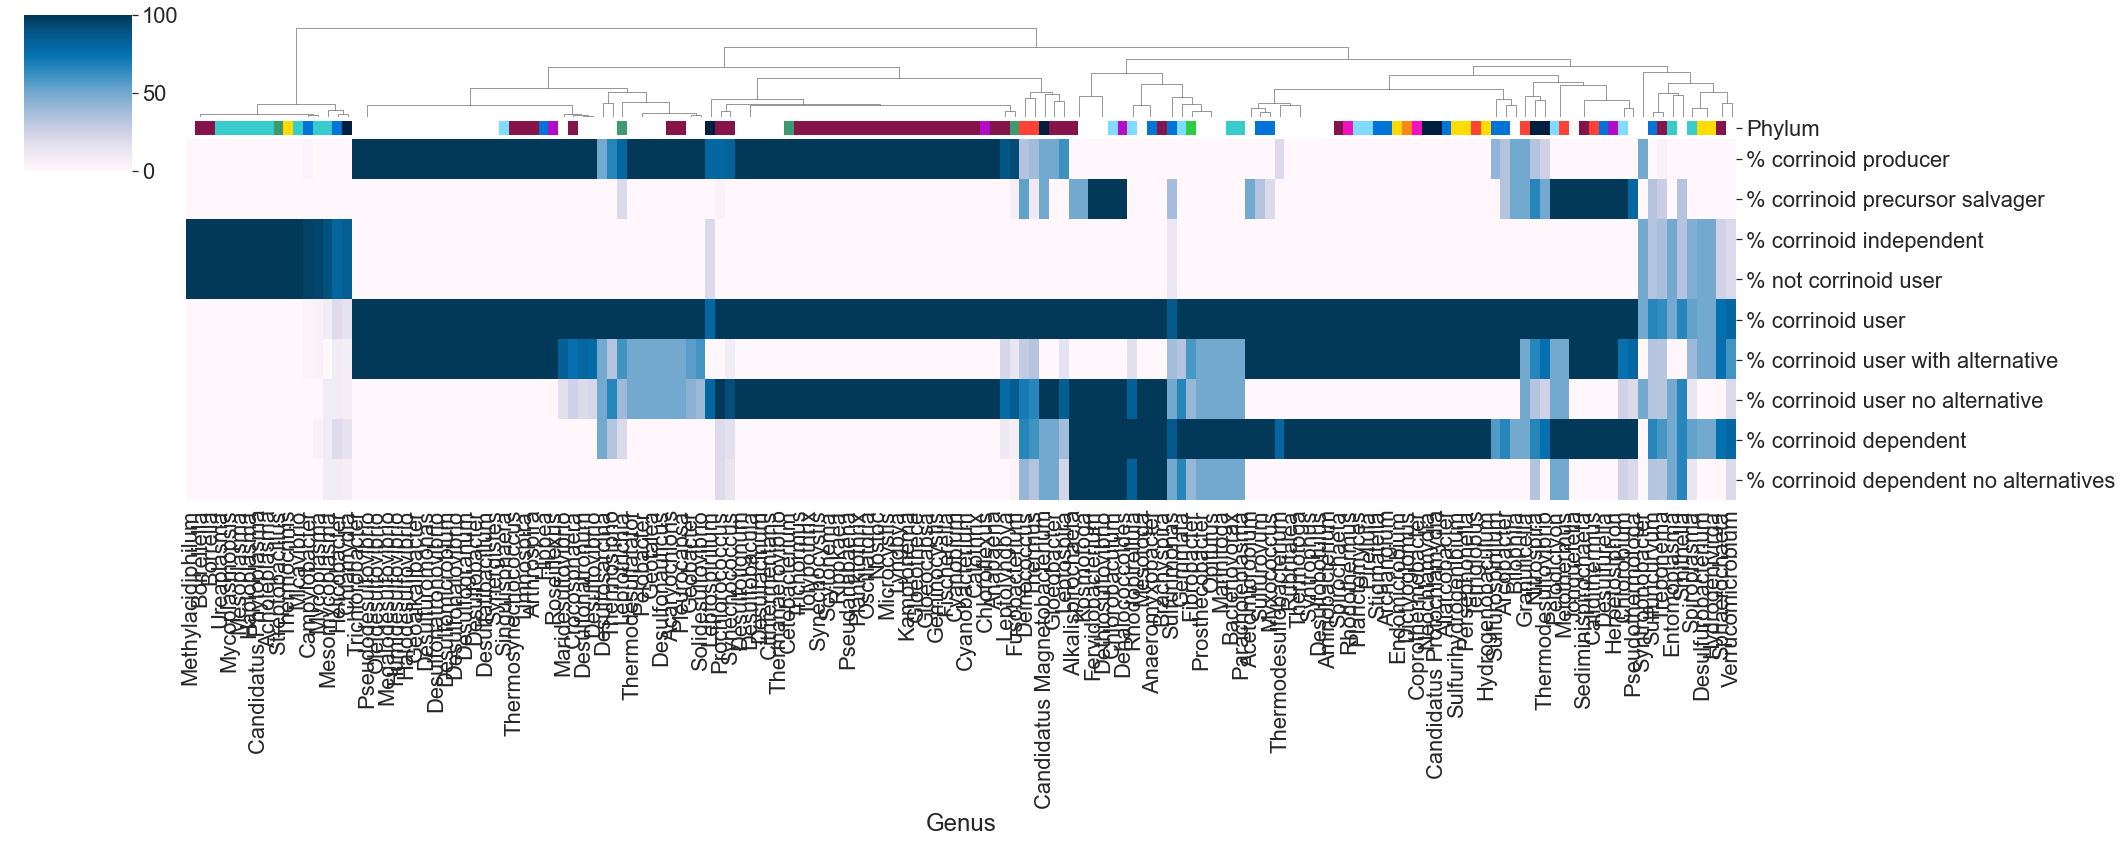

In [152]:
small = heatmap2_gp[~heatmap2_gp['Phylum'].isin(['Pseudomonadota','Actinomycetota','Bacteroidota','Bacillota'])]
phy = small.pop("Phylum")

sns.set(font_scale=2)
sns.clustermap(data=small.T,
               figsize = (30,12),
               dendrogram_ratio=(.1, .2),
               vmin = 0,
               vmax = 100,
               xticklabels = True,
               col_colors=row_colors,
              cmap = 'PuBu',
              row_cluster=False,
              col_cluster = True)

## 10.5 Producer/User scatterplots that I showed at 2023 committee meeting

In [153]:
prod = heatmap_gp[['total # of species','% corrinoid producer']]
user = heatmap_gp[['total # of species','% corrinoid user']]

In [154]:
prod['producer'] = prod['% corrinoid producer']/100
user['user'] = user['% corrinoid user']/100


<AxesSubplot:xlabel='Genus', ylabel='producer'>

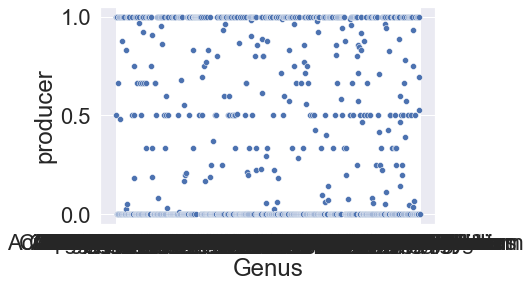

In [155]:
sns.scatterplot(data = prod, y = 'producer', x = 'Genus')

In [ ]:
# sns.scatterplot(data = prod, y = 'se_prod', x = 'Genus')

In [ ]:
# sns.scatterplot(data = user, y = 'user', x = 'Genus')

In [ ]:
# sns.scatterplot(data = user, y = 'se_user', x = 'Genus')

## 10.6 Some of Alekhya's plots

In [ ]:
sns.set_style('white')

<AxesSubplot:xlabel='Phylum'>

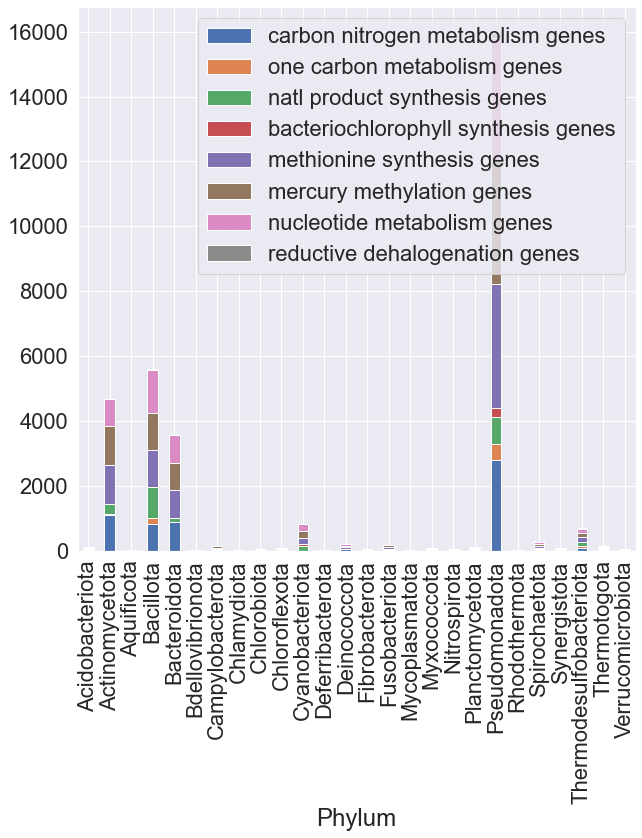

In [156]:
df_phylum[['carbon nitrogen metabolism genes',
       'one carbon metabolism genes',
       'natl product synthesis genes',
       'bacteriochlorophyll synthesis genes',
       'methionine synthesis genes',
       'mercury methylation genes',
       'nucleotide metabolism genes',
       'reductive dehalogenation genes']].plot.bar(stacked=True, figsize=(10,10))

In [ ]:
# stacked bar charts to show distribution of species for each cba category compared to total # of species

Text(0.5, 0, 'Phylum')

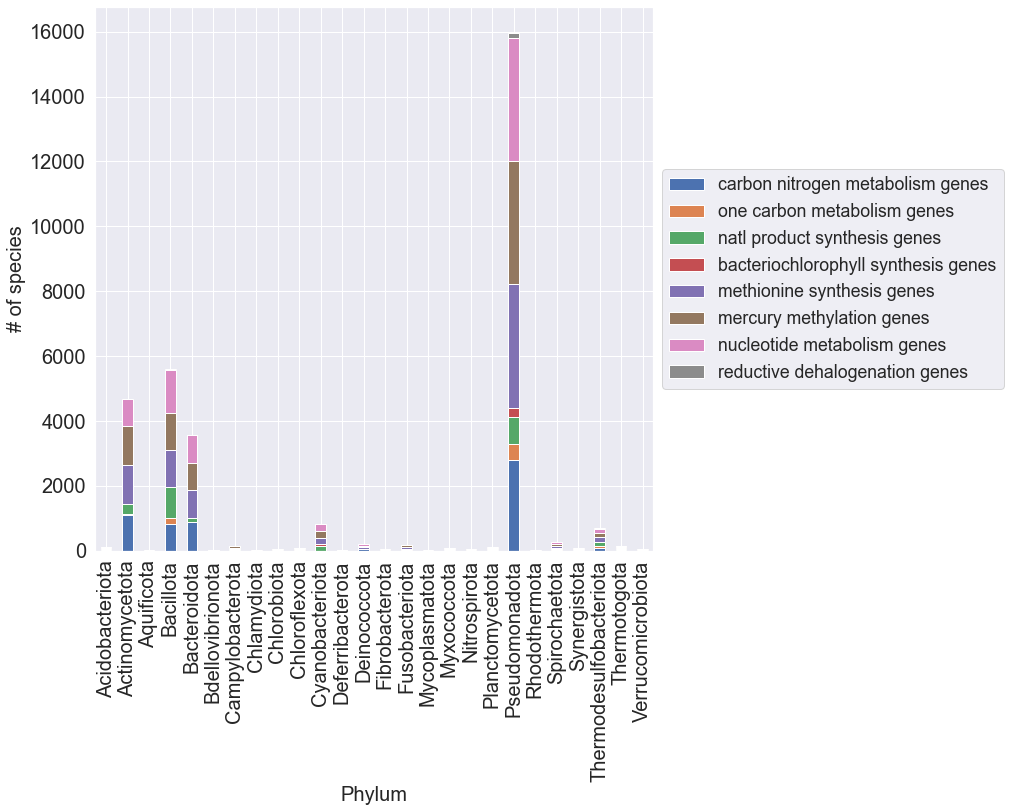

In [159]:
# cba dependent metabolisms


sns.set(font_scale=1.6)
df_phylum[['carbon nitrogen metabolism genes',
       'one carbon metabolism genes',
       'natl product synthesis genes',
       'bacteriochlorophyll synthesis genes',
       'methionine synthesis genes',
       'mercury methylation genes',
       'nucleotide metabolism genes',
       'reductive dehalogenation genes']].plot.bar(stacked=True, figsize=(10,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tick_params(labelsize = 20)
plt.ylabel('# of species', size=20)
plt.xlabel('Phylum',size=20)



Text(0.5, 0, 'Phylum')

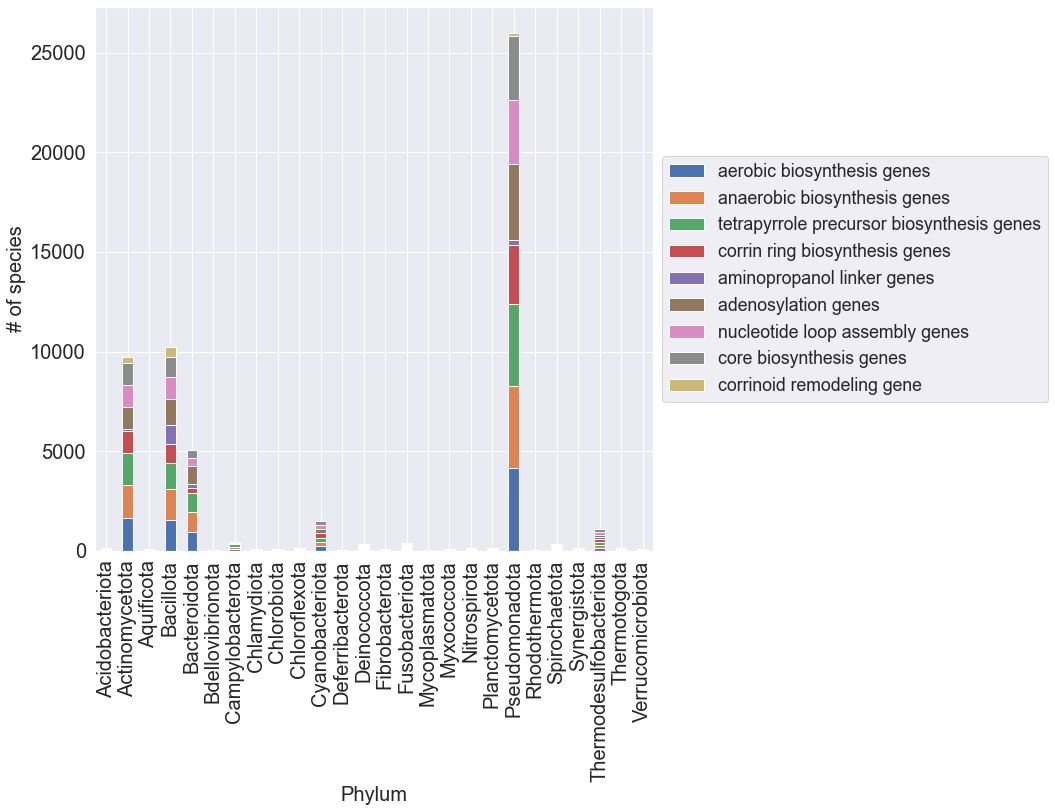

In [160]:
# cba biosynthesis 

sns.set(font_scale=1.6)
df_phylum[['aerobic biosynthesis genes',
       'anaerobic biosynthesis genes',
       'tetrapyrrole precursor biosynthesis genes',
       'corrin ring biosynthesis genes',
       'aminopropanol linker genes',
       'adenosylation genes',
       'nucleotide loop assembly genes',
       'core biosynthesis genes',
       'corrinoid remodeling gene']].plot.bar(stacked=True, figsize=(10,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tick_params(labelsize=20)
plt.ylabel('# of species', size=20)
plt.xlabel('Phylum', size=20)
